In [1]:
# Set Runname
RunName = 'CovidA21-LSTM4Analyze'
RunComment = 'April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties'

In [2]:
startbold = "\033[1m"
resetfonts = "\033[0m"
startred = '\033[31m'

startpurple = '\033[35m'
startyellowbkg = '\033[43m'

!lscpu

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
else:
  print(gpu_info)

from google.colab import drive
drive.mount('/content/gdrive')

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tqdm import tnrange, notebook, tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense

import os
import gc
from csv import reader
from csv import writer
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import io as io
import string

import time
import datetime
from datetime import timedelta,date,datetime

!pip install cloudmesh-common -U
from cloudmesh.common.StopWatch import StopWatch



     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 870kB 22.3MB/s 
     |████████████████████████████████| 133kB 38.3MB/s 
  Created wheel for python-hostlist: filename=python_hostlist-1.21-cp37-none-any.whl size=38931 sha256=9c1afc5ed0bd70456bd179dff02b2a893ca5545bcea18676c10a6d3f452bb4b1
  Stored in directory: /root/.cache/pip/wheels/0b/5b/55/ddcf52288f0b10f4564ca1b2531594ff7ccc65f487ba8dc437
Successfully built python-hostlist


In [4]:
def wraptotext(textinput,size=None):
  if size is None:
    size = 120
  textlist = wrap(textinput,size)
  textresult = textlist[0]
  for itext in range(1,len(textlist)):
    textresult += '\n'+textlist[itext]
  return textresult

def timenow():
  now = datetime.now()
  return now.strftime("%m/%d/%Y, %H:%M:%S") + " UTC"

def float32fromstrwithNaN(instr):
  if instr == 'NaN':
    return NaN
  return np.float32(instr)

def printexit(exitmessage):
  print(exitmessage)
  sys.exit()

def strrnd(value):
  return str(round(value,4))

NaN = np.float32("NaN")

ReadJuly2020Covid = False
ReadAugust2020Covid = False
ReadJan2021Covid = False
ReadApril2021Covid = False
ScaleProperties = False
ConvertDynamicPredictedQuantity = False
ConvertDynamicProperties = True
GenerateFutures = False
GenerateSequences = False
PredictionsfromInputs = False
RereadMay2020 = False
UseOLDCovariates = False
Dropearlydata = 0
NIHCovariates = False 
UseFutures = True
Usedaystart = False 
PopulationNorm = False
SymbolicWindows = False
Hydrology = False
Earthquake = False
EarthquakeImagePlots = False
AddSpecialstoSummedplots = False
UseRealDatesonplots = False
Dumpoutkeyplotsaspics = False
OutputNetworkPictures = False
CDSpecial = False
NumpredbasicperTime = 2
NumpredFuturedperTime = 2
NumTimeSeriesCalculated = 0
Dailyunit = 1
TimeIntervalUnitName = 'Day'
InitialDate = datetime(2000,1,1)
NumberofTimeunits = 0
Num_Time =0
FinalDate = datetime(2000,1,1)
GlobalTrainingLoss = 0.0
GlobalValidationLoss = 0.0

# Type of Testing
LocationBasedValidation = False
LocationValidationFraction = 0.0
LocationTrainingfraction = 1.0
RestartLocationBasedValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
Plotsplitsize = -1 # if > 1 split time in plots

GarbageCollect = True
GarbageCollectionLimit = 0

current_time = timenow()
print(startbold + startred + current_time + ' ' +RunName + ' ' + RunComment + resetfonts)

SubName = RunName[0:6]
if SubName == 'BEST14' or SubName == 'BEST15' or SubName == 'BEST16':
  UseOLDCovariates = False
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  Dropearlydata = 37
  CDSpecial = True

if SubName == 'CovidA':
  UseOLDCovariates = False
  ReadApril2021Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  UseFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  CDSpecial = True

if SubName == 'C2021A' or SubName == 'C2021B':
  UseOLDCovariates = False
  ReadJan2021Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  Dropearlydata = 0
  CDSpecial = True

if SubName == 'Hydrol':
  Hydrology = True

if SubName == 'EARTHQ':
  Earthquake = True

if RunName == 'BEST10' or RunName == 'BEST13-10D' or RunName == 'BEST12-10' or RunName == 'BEST12-Test' or RunName == 'BEST13' or RunName == 'BEST13-10' or RunName == 'BEST13-10A' or RunName == 'BEST13-10C':
  UseOLDCovariates = False
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST11' or RunName == 'BEST11A':
  UseOLDCovariates = True
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST12':
  UseOLDCovariates = True
  RereadMay2020 = True
  ReadAugust2020Covid = False
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST8' or RunName == 'BEST8A' or RunName == 'BEST12-LSTM-8':
  ReadJuly2020Covid = True


06/01/2021, 19:42:05 UTC CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties


In [6]:
# read in science data 
COLABROOTDIR="/content/gdrive/My Drive/Colab Datasets"
os.environ["COLABROOTDIR"] = COLABROOTDIR

if Hydrology:
  APPLDIR=os.path.join(COLABROOTDIR, "Hydrology")
elif Earthquake:
  APPLDIR=os.path.join(COLABROOTDIR, "EarthquakeDec2020")
else:
  APPLDIR=os.path.join(COLABROOTDIR, "COVIDJuly2020")

# Set up Checkpoints
CHECKPOINTDIR = APPLDIR + "/checkpoints/" + RunName + "dir/"
try: 
    if not os.path.exists(CHECKPOINTDIR):
      os.mkdir(CHECKPOINTDIR) 
except OSError as error: 
    print(error)
print('Checkpoint set up in directory ' + CHECKPOINTDIR)

Checkpoint set up in directory /content/gdrive/My Drive/Colab Datasets/COVIDJuly2020/checkpoints/CovidA21-LSTM4Analyzedir/


In [7]:
if ReadApril2021Covid:
  Dropearlydata = 40 # 3 more than needed by covariates so as to get "round number of days"
  NIHCovariates = True
  UseOLDCovariates = False
  LengthFutures = 0

  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2021,4,14)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days April 2021 Dataset " + str(NumberofTimeunits) + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR + '/CovidApril14-2021'

  CasesFile = DATASETDIR + '/' + 'US_daily_cumulative_cases_April14.csv'
  DeathsFile = DATASETDIR + '/' + 'US_daily_cumulative_deaths_April14.csv'
  LocationdataFile = DATASETDIR + '/Population.csv'
  VotingdataFile = DATASETDIR + '/2020votes.csv'
  AlaskaVotingdataFile = DATASETDIR + '/Alaskavoting2016.csv'

  Nloc = 3142
  NFIPS = 3142

# Set up location information
  Num_Time = NumberofTimeunits
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,2],dtype = np.float32)

# Read in  cases Data into BasicInputTimeSeries
  with open(CasesFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Cases ' + Ftype)

      iloc = 0    
      for nextrow in csv_reader:
        if (len(nextrow)< NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Cases ' + str(iloc) + ' ' +str(len(nextrow)))
        # skip first entry
        localfips = nextrow[0]
        Locationcolumns.append(localfips)
        Locationfips[iloc] = int(localfips)
        FIPSintegerlookup[int(localfips)] = iloc
        FIPSstringlookup[localfips] = iloc
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,0] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,0] = BasicInputTimeSeries[itime,iloc,0] - floatlast
        iloc += 1
# End Reading in cases data

  if iloc != Nloc:
          printexit('EXIT Inconsistent location lengths Cases ' +str(iloc) + ' ' + str(Nloc))
  print('Read Cases data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# Read in deaths Data into BasicInputTimeSeries
  with open(DeathsFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Deaths ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        if (len(nextrow)<NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Deaths ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        if (Locationfips[iloc] != int(localfips)):
          printexit('EXIT: Unexpected FIPS Deaths ' + localfips + ' ' +str(Locationfips[iloc]))
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,1] = BasicInputTimeSeries[itime,iloc,1] - floatlast
        iloc += 1
# End Reading in deaths data

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
  print('Read Deaths data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

  Locationname = ['Empty'] * NFIPS
  Locationstate = ['Empty'] * NFIPS
  Locationpopulation = np.empty(NFIPS, dtype=int)
  with open(LocationdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Prop Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationname[jloc] = nextrow[4]
          Locationstate[jloc] = nextrow[3]
          Locationpopulation[jloc] = int(nextrow[2])
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  
# END setting NFIPS location properties

  DemVoting = np.full(NFIPS, -1.0, dtype=np.float32)
  RepVoting = np.full(NFIPS, -1.0, dtype=np.float32)
  with open(VotingdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'state_name':
        printexit('EXIT: Wrong file type Voting Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[1])
        if localfips > 2900 and localfips < 2941: # Alaska not useful
          continue
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          if DemVoting[jloc] >= 0.0:
             printexit('EXIT Double Setting of FIPS ' +str(iloc) + ' ' + str(localfips))
          DemVoting[jloc] = nextrow[8]
          RepVoting[jloc] = nextrow[7]
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  

  with open(AlaskaVotingdataFile, 'r',encoding='utf-8-sig') as read_obj: # remove ufeff
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'SpecialAlaska':
        printexit('EXIT: Wrong file type Alaska Voting Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[1])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          if DemVoting[jloc] >= 0.0:
             printexit('EXIT Double Setting of FIPS ' +str(iloc) + ' ' + str(localfips))
          DemVoting[jloc] = float(nextrow[2]) * 42.77/36.5
          RepVoting[jloc] = float(nextrow[3]) * 52.83/51.3
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))

  for iloc in range(0,NFIPS):
    if DemVoting[iloc] >= 0.0:
      continue
    print(str(iloc) + ' Missing Votes ' + str(Locationfips[iloc]) + ' ' + Locationname[iloc] + ' ' + Locationstate[iloc] + ' pop ' + str( Locationpopulation[iloc]))
    DemVoting[iloc] = 0.5
    RepVoting[iloc] = 0.5

# Set Static Properties of the Nloc studied locations
# Order is Static, Dynamic, Cases, Deaths
# Voting added as 13th covariate
  NpropperTimeDynamic = 13
  NpropperTimeStatic = 0

  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic + 2   
  InputPropertyNames = [] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)

Total number of Days April 2021 Dataset 409 Dropping at start 40
Read Cases data locations 3142 Time Steps 409
Read Deaths data locations 3142 Time Steps 409
548 Missing Votes 15005 Kalawao County Hawaii pop 86


In [8]:
# Read January 2021 Covid Data

if ReadJan2021Covid:
  Dropearlydata = 37
  NIHCovariates = True
  UseOLDCovariates = False

  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2021,1,26)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days January 2021 Dataset " + str(NumberofTimeunits) + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR + '/January2021'

  CasesFile = DATASETDIR + '/' + 'US_daily_cumulative_cases.csv'
  DeathsFile = DATASETDIR + '/' + 'US_daily_cumulative_deaths.csv'
  LocationdataFile = DATASETDIR + '/Population.csv'

  Nloc = 3142
  NFIPS = 3142

# Set up location information
  Num_Time = NumberofTimeunits
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,2],dtype = np.float32)

# Read in  cases Data into BasicInputTimeSeries
  with open(CasesFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Cases ' + Ftype)

      iloc = 0    
      for nextrow in csv_reader:
        if (len(nextrow)< NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Cases ' + str(iloc) + ' ' +str(len(nextrow)))
        # skip first entry
        localfips = nextrow[0]
        Locationcolumns.append(localfips)
        Locationfips[iloc] = int(localfips)
        FIPSintegerlookup[int(localfips)] = iloc
        FIPSstringlookup[localfips] = iloc
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,0] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,0] = BasicInputTimeSeries[itime,iloc,0] - floatlast
        iloc += 1
# End Reading in cases data

  if iloc != Nloc:
          printexit('EXIT Inconsistent location lengths Cases ' +str(iloc) + ' ' + str(Nloc))
  print('Read Cases data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# Read in deaths Data into BasicInputTimeSeries
  with open(DeathsFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Deaths ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        if (len(nextrow)<NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Deaths ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        if (Locationfips[iloc] != int(localfips)):
          printexit('EXIT: Unexpected FIPS Deaths ' + localfips + ' ' +str(Locationfips[iloc]))
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,1] = BasicInputTimeSeries[itime,iloc,1] - floatlast
        iloc += 1
# End Reading in deaths data

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
  print('Read Deaths data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

  Locationname = ['Empty'] * NFIPS
  Locationstate = ['Empty'] * NFIPS
  Locationpopulation = np.empty(NFIPS, dtype=int)
  with open(LocationdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Prop Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationname[jloc] = nextrow[4]
          Locationstate[jloc] = nextrow[3]
          Locationpopulation[jloc] = int(nextrow[2])
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  
# END setting NFIPS location properties

# Set Static Properties of the Nloc studied locations
# Order is Static, Dynamic, Cases, Deaths
  NpropperTimeDynamic = 12
  NpropperTimeStatic = 0

  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic + 2   
  InputPropertyNames = [' '] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)



# Finish this after NIH Covariate

In [9]:

if ReadAugust2020Covid:
  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2020,8,13)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days August Dataset " + str(NumberofTimeunits) + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR +'/MidAugust2020Data'

  CasesFile = DATASETDIR + '/' + 'covid-cases.csv'
  DeathsFile = DATASETDIR + '/' + 'covid-deaths.csv'
  CovariatesFile = DATASETDIR + '/' + 'PVI-31July2020.csv'
  if RereadMay2020 or UseOLDCovariates:
    CovariatesFile = DATASETDIR + '/' + 'Static_316USCities_Pop.csv'
  LocationdataFile = DATASETDIR + '/' + 'Static_316USCities_Pop.csv'

  Nloc = 314
  NFIPS = 316

if RereadMay2020:
  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2020,5,25)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days May Dataset " + str(NumberofTimeunits)  + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR +'/EndMay2020fromfiles'

  CasesFile = DATASETDIR + '/' + 'Covid19-cases-110USCities.csv'
  DeathsFile = DATASETDIR + '/' + 'Covid19-deaths-110USCities.csv'
  CovariatesFile = DATASETDIR + '/' + 'PVI-31July2020.csv'
  if UseOLDCovariates:
    CovariatesFile = DATASETDIR + '/' + 'Static_316USCities_Pop.csv'
  LocationdataFile = DATASETDIR + '/' + 'Static_316USCities_Pop.csv'

  Nloc = 110
  NFIPS = 112

if ReadAugust2020Covid or RereadMay2020:

# Set up location information
  Num_Time = NumberofTimeunits
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,2],dtype = np.float32)

# Read in  cases Data into BasicInputTimeSeries
  with open(CasesFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type ' + Ftype)

      iloc = 0
      
      for nextrow in csv_reader:
        if (len(nextrow)!=NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Cases ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        Locationcolumns.append(localfips)
        Locationfips[iloc] = int(localfips)
        FIPSintegerlookup[int(localfips)] = iloc
        FIPSstringlookup[localfips] = iloc
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,0] = nextrow[itime + 1 + Dropearlydata]
        iloc += 1
# End Reading in cases data

  if iloc != Nloc:
          printexit('EXIT Inconsistent location lengths Cases ' +str(iloc) + ' ' + str(Nloc))
  print('Read Cases data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# Read in deaths Data into BasicInputTimeSeries
  with open(DeathsFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        if (len(nextrow)!=NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Deaths ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        if (Locationfips[iloc] != int(localfips)):
          printexit('EXIT: Unexpected FIPS Deaths ' + localfips + ' ' +str(Locationfips[iloc]))
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[itime + 1 + Dropearlydata]
        iloc += 1
# End Reading in deaths data

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
  print('Read Deaths data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# START setting location properties -- there are NFIPS of these
# NFIPS can be larger than Nloc. Any fips in studied group must be in fips property group
# Add missing FIPS in 315 and not 314 set are 49057  and 49053
# while 48203 is in 314 but not 315; 316 adds 48023
  Locationfips[Nloc] = 49057
  Locationfips[Nloc+1] = 49053
  Locationcolumns.append(str(Locationfips[Nloc]))
  FIPSintegerlookup[Locationfips[Nloc]] = Nloc
  FIPSstringlookup[str(Locationfips[Nloc])] = Nloc
  Locationcolumns.append(str(Locationfips[Nloc+1]))
  FIPSintegerlookup[Locationfips[Nloc+1]] = Nloc+1
  FIPSstringlookup[str(Locationfips[Nloc+1])] = Nloc+1

  Locationname = ['Empty'] * NFIPS
  Locationstate = ['Empty'] * NFIPS
  Locationpopulation = np.empty(NFIPS, dtype=int)
  with open(LocationdataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationname[jloc] = nextrow[2]
          Locationstate[jloc] = nextrow[1]
          Locationpopulation[jloc] = int(nextrow[5])
          iloc += 1 # just counting lines
       
  if iloc != Nloc+2:
    printexit('EXIT Inconsistent old static data lengths ' +str(iloc) + ' ' + str(Nloc+2))
  if 48203 in FIPSintegerlookup.keys():
    iloc = FIPSintegerlookup[48203]
    Locationname[iloc] = 'Harrison'
    Locationstate[iloc] = 'Texas'
    Locationpopulation[iloc] = 66553
# END setting NFIPS location properties

# Set Static Properties of the Nloc studied locations
# Order is Static, Dynamic, Cases, Deaths
  if NIHCovariates:
      NpropperTimeDynamic = 11
      NpropperTimeStatic = 0
  else:
      NpropperTimeDynamic = 0
      NpropperTimeStatic = 12
      if UseOLDCovariates:
        NpropperTimeStatic = 26
  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic + 2   
  InputPropertyNames = [] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)

  if not NIHCovariates:
      BasicInputStaticProps = np.empty([Nloc,NpropperTimeStatic],dtype = np.float32)
      
      with open(CovariatesFile, 'r') as read_obj:
          csv_reader = reader(read_obj)
          header = next(csv_reader)
          Ftype = header[0]
          if Ftype != 'FIPS':
              printexit('EXIT: Wrong file type ' + Ftype)
          throwaway = 2
          if UseOLDCovariates:
            throwaway = 6
          if ( len(header) != (throwaway+NpropperTimeStatic)):
              printexit('EXIT: Incorrect property header length ' + str(len(header)) + ' ' +str(2+NpropperTimeStatic))
          InputPropertyNames[:] = header[throwaway:]

          iloc = 0
          for nextrow in csv_reader:
            if (len(nextrow)!= (throwaway+NpropperTimeStatic)):
              printexit('EXIT: Incorrect row length ' + str(iloc) + ' ' + str(2+NpropperTimeStatic) + ' ' +str(len(nextrow)))
            localfips = int(nextrow[0])
            if not localfips in FIPSintegerlookup.keys():
              continue
    #           printexit('EXIT: Missing FIPS ' + str(localfips))
            jloc = FIPSintegerlookup[localfips]
            if jloc >= Nloc:
              print('FIPS ' + str(localfips) + ' skipped in property read')
              continue # skip this FIPS
            BasicInputStaticProps[jloc,:] = np.asarray(nextrow[throwaway:], dtype=np.float32)
            iloc += 1
    # End Reading in Static Properties data

      if iloc != Nloc:
        printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
      print('Read Static Properties for locations ' + str(Nloc) + ' Properties ' + str(NpropperTimeStatic))

  # August Covariates all intensive and no missing data
  # May Coviates have intensive properties missing for Harrison TX
      if UseOLDCovariates:
        Property_is_Intensive[20] = False
        Property_is_Intensive[21] = False
        Property_is_Intensive[22] = False

# Finish this after NIH Covariate

In [10]:
#
#Read and setup NIH Covariates August 2020 and January, April 2021 Data
#new collection of time dependent covariates (even if constant).
#cases and deaths and location property from previous data

if NIHCovariates:
  if ReadJan2021Covid:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Comorbidities.csv","Demographics.csv", "Disease Spread.csv", 
                     "Health Disparities.csv", "Hospital Beds.csv", "Intervention Testing.csv", "Mobility.csv", 
                     "Residential Density.csv", "Social Distancing.csv",  "Transmissible Cases.csv"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities",  "Demographics", "Disease Spread", 
                 "Health Disparities", "Hospital Beds", "Intervention Testing", "Mobility", "Residential Density", 
                 "Social Distancing", "Transmissible Cases"]

  elif ReadApril2021Covid:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Comorbidities.csv","Demographics.csv", "Disease Spread.csv", 
                     "Health Disparities.csv", "Hospital Beds.csv", "Mobility.csv", 
                     "Residential Density.csv", "Social Distancing.csv", "Testing.csv", "Transmissible Cases.csv","NOFILE"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities",  "Demographics", "Disease Spread", 
                 "Health Disparities", "Hospital Beds",  "Mobility", "Residential Density", 
                 "Social Distancing", "Testing","Transmissible Cases","voting"]
  else:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Co-morbidities.csv", "Health Disparities.csv", "Hospital Beds.csv", "Pop Demographics.csv", "Pop Mobility.csv", "Residential Density.csv", "Social Distancing.csv", "Testing.csv", "Transmissible Cases.csv"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities", "Health Disparities", "Hospital Beds", "Pop Demographics", "Pop Mobility", "Residential Density", "Social Distancing", "Testing", "Transmissible Cases"]
  
  NIHDATADIR = DATASETDIR + '/' 
  numberfiles = len(Propnames)
  NpropperTimeStatic = 0
  if NpropperTimeDynamic != numberfiles:
    printexit('EXIT: Dynamic Properties set wrong ' + str(numberfiles) + ' ' + str(NpropperTimeDynamic))
  DynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,numberfiles],dtype = np.float32)
  enddifference = NaN

  for ifiles in range(0,numberfiles):
    InputPropertyNames.append(Propnames[ifiles])
    if Propfilenames[ifiles] == 'NOFILE': # Special case of Voting Data
      for iloc in range(0,Nloc):
        Demsize = DemVoting[iloc]
        RepSize = RepVoting[iloc]
        Votingcovariate = Demsize/(RepSize+Demsize)
        DynamicPropertyTimeSeries[:,iloc,ifiles] = Votingcovariate
      continue # over ifile loop

    DynamicPropFile = NIHDATADIR + Propfilenames[ifiles]
    if not (ReadJan2021Covid or ReadApril2021Covid):
      DynamicPropFile = DATASETDIR + '/ThirdCovariates/' + Propfilenames[ifiles]

    # Read in  Covariate Data into DynamicPropertyTimeSeries
    with open(DynamicPropFile, 'r') as read_obj:
        csv_reader = reader(read_obj)
        header = next(csv_reader)
        skip = 1
        if ReadJan2021Covid or ReadApril2021Covid:
          skip = 2
          Ftype = header[0]
          if Ftype != 'Name':
            printexit('EXIT: Wrong file type ' + Ftype)
        Ftype = header[skip-1]
        if Ftype != 'FIPS':
          printexit('EXIT: Wrong file type ' + Ftype)
        # Check Date
        hformat = '%m-%d-%Y'
        if ReadJan2021Covid or ReadApril2021Covid:
          hformat = '%Y-%m-%d'
        firstdate = datetime.strptime(header[skip], hformat)
        tdelta = (firstdate-InitialDate).days 
        if tdelta > 0:
          printexit('Missing Covariate Data start -- adjust Dropearlydata ' + str(tdelta))
        lastdate = datetime.strptime(header[len(header)-1], hformat)
        enddifference1 = (FinalDate-lastdate).days
        if math.isnan(enddifference):
          enddifference = enddifference1
          print('Missing days at the end ' + str(enddifference))
        else:
          if enddifference != enddifference1:
            printexit('EXIT: Incorrect time length ' + Propnames[ifiles] + ' expected ' + str(enddifference) + ' actual ' +str(enddifference1))
        iloc = 0
        
        for nextrow in csv_reader:
          if (len(nextrow)!=NumberofTimeunits + skip -enddifference-tdelta):
            printexit('EXIT: Incorrect row length ' + Propnames[ifiles] + ' Location ' + str(iloc) + ' ' +str(len(nextrow)))
          localfips = nextrow[skip-1]
          jloc = FIPSstringlookup[localfips] 
          for itime in range(0, NumberofTimeunits - enddifference):
            DynamicPropertyTimeSeries[itime,jloc,ifiles] = nextrow[itime + skip - tdelta]
        # Use previous week value for missing data at the end
          for itime in range(NumberofTimeunits - enddifference, NumberofTimeunits):
            DynamicPropertyTimeSeries[itime,jloc,ifiles] = DynamicPropertyTimeSeries[itime-7,jloc,ifiles]
          iloc += 1
# End Reading in dynamic property data

    if iloc != Nloc:
            printexit('EXIT Inconsistent location lengths ' + Propnames[ifiles] + str(iloc) + ' ' + str(Nloc))
    print('Read ' + Propnames[ifiles] + ' data for locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time) + ' Days dropped at start ' + str(-tdelta))

  if ReadApril2021Covid:
    CovidPopulationCut = 0 # Use this if NumberCut = 0
    NumberCut = 2642
    uselocation = np.full(Nloc, True, dtype = np.bool)
    if (CovidPopulationCut > 0) or (NumberCut > 0):
      if NumberCut >0:
        smalllocations = np.argsort(Locationpopulation)
        for jloc in range(0,NumberCut):
          uselocation[smalllocations[jloc]] = False
        CovidPopulationCut = Locationpopulation[smalllocations[NumberCut]]
      else:
        NumberCut =0
        for iloc in range(0,Nloc):
          if Locationpopulation[iloc] < CovidPopulationCut:
            uselocation[iloc] = False
            NumberCut += 1
      print(' Population Cut ' + str(CovidPopulationCut) + ' removes ' + str(NumberCut) + ' of ' + str(Nloc))
    if(NumberCut > 0):
      NewNloc = Nloc - NumberCut
      NewNFIPS = NewNloc
      NewLocationfips = np.empty(NewNFIPS, dtype=int) # integer version of FIPs
      NewLocationcolumns = [] # String version of FIPS
      NewFIPSintegerlookup = {}
      NewFIPSstringlookup = {}
      NewBasicInputTimeSeries = np.empty([Num_Time,NewNloc,2],dtype = np.float32)
      NewLocationname = ['Empty'] * NewNFIPS
      NewLocationstate = ['Empty'] * NewNFIPS
      NewLocationpopulation = np.empty(NewNFIPS, dtype=int)
      NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,numberfiles],dtype = np.float32) 

      Newiloc = 0
      for iloc in range(0,Nloc):
        if not uselocation[iloc]:
          continue
        NewBasicInputTimeSeries[:,Newiloc,:] = BasicInputTimeSeries[:,iloc,:]
        NewDynamicPropertyTimeSeries[:,Newiloc,:] = DynamicPropertyTimeSeries[:,iloc,:]
        localfips = Locationcolumns[iloc]
        NewLocationcolumns.append(localfips)
        NewLocationfips[Newiloc] = int(localfips)
        NewFIPSintegerlookup[int(localfips)] = Newiloc
        NewFIPSstringlookup[localfips] = Newiloc 
        NewLocationpopulation[Newiloc] = Locationpopulation[iloc]
        NewLocationstate[Newiloc] = Locationstate[iloc]
        NewLocationname[Newiloc] = Locationname[iloc]
        Newiloc +=1

      BasicInputTimeSeries = NewBasicInputTimeSeries
      DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
      Locationname = NewLocationname
      Locationstate = NewLocationstate
      Locationpopulation = NewLocationpopulation
      FIPSstringlookup = NewFIPSstringlookup
      FIPSintegerlookup = NewFIPSintegerlookup
      Locationcolumns = NewLocationcolumns
      Locationfips = NewLocationfips
      NFIPS = NewNFIPS
      Nloc = NewNloc


Missing days at the end 0
Read Age Distribution data for locations 3142 Time Steps 409 Days dropped at start 3
Read Air Pollution data for locations 3142 Time Steps 409 Days dropped at start 3
Read Co-morbidities data for locations 3142 Time Steps 409 Days dropped at start 3
Read Demographics data for locations 3142 Time Steps 409 Days dropped at start 3
Read Disease Spread data for locations 3142 Time Steps 409 Days dropped at start 3
Read Health Disparities data for locations 3142 Time Steps 409 Days dropped at start 3
Read Hospital Beds data for locations 3142 Time Steps 409 Days dropped at start 3
Read Mobility data for locations 3142 Time Steps 409 Days dropped at start 3
Read Residential Density data for locations 3142 Time Steps 409 Days dropped at start 3
Read Social Distancing data for locations 3142 Time Steps 409 Days dropped at start 3
Read Testing data for locations 3142 Time Steps 409 Days dropped at start 3
Read Transmissible Cases data for locations 3142 Time Steps 409 

In [11]:
# Convert Cumulative to Daily
# Convert  cumulative to Daily. 
# Replace negative daily values by zero
# remove daily to sqrt(daily)  and Then normalize maximum to 1
if ConvertDynamicPredictedQuantity:
  NewBasicInputTimeSeries = np.empty_like(BasicInputTimeSeries, dtype=np.float32)
  Zeroversion = np.zeros_like(BasicInputTimeSeries, dtype=np.float32)
  Rolleddata = np.roll(BasicInputTimeSeries, 1, axis=0)
  Rolleddata[0,:,:] = Zeroversion[0,:,:]
  NewBasicInputTimeSeries = np.maximum(np.subtract(BasicInputTimeSeries,Rolleddata),Zeroversion)
  originalnumber = np.sum(BasicInputTimeSeries[NumberofTimeunits-1,:,:],axis=0)
  newnumber = np.sum(NewBasicInputTimeSeries,axis=(0,1))
  print('Original summed counts ' + str(originalnumber) + ' become ' + str(newnumber)+ ' Cases, Deaths')

  BasicInputTimeSeries = NewBasicInputTimeSeries


Original summed counts [23553836.   416232.] become [23588870.   420675.] Cases, Deaths


In [12]:
#Static and Dynamic specials for COVID
#except case where Romeo data read

# Remove special status of Cases and Deaths
if CDSpecial:

  NewNpropperTimeDynamic = NpropperTimeDynamic + 2
  NewNpropperTime = NpropperTimeStatic + NewNpropperTimeDynamic   

  NewProperty_is_Intensive = np.full(NewNpropperTime, True, dtype = np.bool)
  NewInputPropertyNames = []
  NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,NewNpropperTimeDynamic],dtype = np.float32)

  for casesdeaths in range(0,2):
    NewDynamicPropertyTimeSeries[:,:,casesdeaths] = BasicInputTimeSeries[:,:,casesdeaths]
  BasicInputTimeSeries = None

  for iprop in range(0,NpropperTimeStatic):
    NewInputPropertyNames.append(InputPropertyNames[iprop])
    NewProperty_is_Intensive[iprop] = Property_is_Intensive[iprop]
  NewProperty_is_Intensive[NpropperTimeStatic] = False
  NewProperty_is_Intensive[NpropperTimeStatic+1] = False
  NewInputPropertyNames.append('Cases')
  NewInputPropertyNames.append('Deaths')
  for ipropdynamic in range(0,NpropperTimeDynamic):
    Newiprop = NpropperTimeStatic+2+ipropdynamic
    iprop = NpropperTimeStatic+ipropdynamic
    NewDynamicPropertyTimeSeries[:,:,Newiprop] = DynamicPropertyTimeSeries[:,:,iprop]
    NewInputPropertyNames.append(InputPropertyNames[iprop])
    NewProperty_is_Intensive[Newiprop] = Property_is_Intensive[iprop]
  
  NpropperTimeDynamic = NewNpropperTimeDynamic
  NpropperTime = NewNpropperTime
  DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
  InputPropertyNames = NewInputPropertyNames
  Property_is_Intensive = NewProperty_is_Intensive

In [13]:
# Execute under all COVID circumstances properties generated here
if CDSpecial:
  if NpropperTimeStatic > 0:
    Num_Extensive = 0
    for iprop in range(0,NpropperTimeStatic):
      if not Property_is_Intensive[iprop]:
        Num_Extensive +=1
    print(startbold + startred + ' Number of Extensive parameters ' + str(Num_Extensive) + resetfonts)
    for iprop in range(0,NpropperTimeStatic):
      if not Property_is_Intensive[iprop]:
        print(InputPropertyNames[iprop])

    # Convert Extensive covariates to SQRT(Population normed)
    # Replace negatives by mean of positives and zeroes
    positivemean = np.zeros(NpropperTimeStatic, dtype = np.float32)
    countvalidentries = np.zeros(NpropperTimeStatic, dtype = np.float32)
    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeStatic):
        if not Property_is_Intensive[iprop]:
          BasicInputStaticProps[iloc,iprop] = np.sqrt(BasicInputStaticProps[iloc,iprop]/Locationpopulation[iloc])
        else:
          if BasicInputStaticProps[iloc,iprop] >= 0:
            positivemean[iprop] += BasicInputStaticProps[iloc,iprop]
            countvalidentries[iprop] += 1.0

    for iprop in range(0,NpropperTimeStatic):
        if Property_is_Intensive[iprop]:
          positivemean[iprop] /= countvalidentries[iprop]

    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeStatic):
        if Property_is_Intensive[iprop]:
          if BasicInputStaticProps[iloc,iprop] < 0:
            BasicInputStaticProps[iloc,iprop] = positivemean[iprop]

In [14]:
#Normalize All Static and Dynamic Properties
#for Static Properties BasicInputStaticProps[Nloc,NpropperTimeStatic] converts to NormedInputStaticProps[Nloc,NpropperTimeStatic]
def SetTakeroot(x,n):
    if np.isnan(x):
      return NaN   
    if n == 3:
      return np.cbrt(x)
    elif n == 2:
      if x <= 0.0:
        return 0.0
      return np.sqrt(x) 
    return x 

def DynamicPropertyScaling(InputTimeSeries):
    Results = np.full(7, 0.0,dtype=np.float32)
    Results[1] = np.nanmax(InputTimeSeries, axis = (0,1))
    Results[0] = np.nanmin(InputTimeSeries, axis = (0,1))
    Results[3] = np.nanmean(InputTimeSeries, axis = (0,1))
    Results[4] = np.nanstd(InputTimeSeries, axis = (0,1))
    Results[2] = np.reciprocal(np.subtract(Results[1],Results[0]))
    Results[5] = np.multiply(Results[2],np.subtract(Results[3],Results[0]))
    Results[6] = np.multiply(Results[2],Results[4])
    return Results

NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated  
if ScaleProperties:
  QuantityTakeroot = np.full(NpropperTimeMAX,1,dtype=np.int)
  if Hydrology:
    QuantityTakeroot[27] = 3
    QuantityTakeroot[32] = 3
  if CDSpecial:
    QuantityTakeroot[NpropperTimeStatic] =2
    QuantityTakeroot[NpropperTimeStatic+1] =2

# Scale data by roots if requested
  for iprop in range(0, NpropperTimeMAX):
    if QuantityTakeroot[iprop] >= 2:
      if iprop < NpropperTimeStatic:
        for iloc in range(0,Nloc):
          BasicInputStaticProps[iloc,iprop] = SetTakeroot(BasicInputStaticProps[iloc,iprop],QuantityTakeroot[iprop])
      elif iprop < NpropperTime:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic] = SetTakeroot(
                DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic],QuantityTakeroot[iprop])
      else:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            CalculatedTimeSeries[itime,iloc,iprop-NpropperTime] =SetTakeroot(
                CalculatedTimeSeries[itime,iloc,iprop-NpropperTime],QuantityTakeroot[iprop])

  QuantityStatisticsNames = ['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
  QuantityStatistics = np.zeros([NpropperTimeMAX,7], dtype=np.float32)
  if NpropperTimeStatic > 0:  
    print(BasicInputStaticProps.shape)
    max_value = np.amax(BasicInputStaticProps, axis = 0)
    min_value = np.amin(BasicInputStaticProps, axis = 0)
    mean_value = np.mean(BasicInputStaticProps, axis = 0)
    std_value = np.std(BasicInputStaticProps, axis = 0)
    normval = np.reciprocal(np.subtract(max_value,min_value))
    normed_mean = np.multiply(normval,np.subtract(mean_value,min_value))
    normed_std = np.multiply(normval,std_value)
    QuantityStatistics[0:NpropperTimeStatic,0] = min_value
    QuantityStatistics[0:NpropperTimeStatic,1] = max_value
    QuantityStatistics[0:NpropperTimeStatic,2] = normval
    QuantityStatistics[0:NpropperTimeStatic,3] = mean_value
    QuantityStatistics[0:NpropperTimeStatic,4] = std_value
    QuantityStatistics[0:NpropperTimeStatic,5] = normed_mean
    QuantityStatistics[0:NpropperTimeStatic,6] = normed_std

    NormedInputStaticProps =np.empty_like(BasicInputStaticProps)
    for iloc in range(0,Nloc):
      NormedInputStaticProps[iloc,:] = np.multiply((BasicInputStaticProps[iloc,:] - min_value[:]),normval[:])

  if (NpropperTimeDynamic > 0) or (NumTimeSeriesCalculated>0):
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      QuantityStatistics[iprop,:] = DynamicPropertyScaling(DynamicPropertyTimeSeries[:,:,iprop-NpropperTimeStatic])
    for iprop in range(0,NumTimeSeriesCalculated):
      QuantityStatistics[iprop+NpropperTime,:] = DynamicPropertyScaling(CalculatedTimeSeries[:,:,iprop]) 

    NormedDynamicPropertyTimeSeries = np.empty_like(DynamicPropertyTimeSeries)
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      NormedDynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic] = np.multiply((DynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
    
    if NumTimeSeriesCalculated > 0:
      NormedCalculatedTimeSeries = np.empty_like(CalculatedTimeSeries)
      for iprop in range(NpropperTime,NpropperTimeMAX):
        NormedCalculatedTimeSeries[:,:,iprop - NpropperTime] = np.multiply((CalculatedTimeSeries[:,:,iprop - NpropperTime]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
      CalculatedTimeSeries = None
  
    BasicInputStaticProps = None
    DynamicPropertyTimeSeries = None
    print(startbold + "Properties scaled" +resetfonts)

  line = 'Name   '
  for propval in range (0,7):
    line += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold +startpurple + line + resetfonts)
  for iprop in range(0,NpropperTimeMAX):
    if iprop == NpropperTimeStatic:
      print('\n')
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[iprop] + resetfonts  + ' Root ' + str(QuantityTakeroot[iprop])
    for propval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[iprop,propval],3))
    print(line)

Properties scaled

Name   Min    Max    Norm    Mean    Std    Normed Mean    Normed Std    


0 Cases Root 2 0.0 171.531 0.006 7.735 7.451 0.045 0.043
1 Deaths Root 2 0.0 39.408 0.025 0.783 1.202 0.02 0.03
2 Age Distribution Root 1 0.248 1.0 1.33 0.507 0.091 0.345 0.121
3 Air Pollution Root 1 0.0 1.0 1.0 0.413 0.115 0.413 0.115
4 Co-morbidities Root 1 0.029 0.581 1.813 0.285 0.099 0.463 0.179
5 Demographics Root 1 0.189 1.0 1.233 0.503 0.112 0.388 0.139
6 Disease Spread Root 1 0.0 1.0 1.0 0.234 0.243 0.234 0.243
7 Health Disparities Root 1 0.004 0.848 1.184 0.264 0.158 0.308 0.187
8 Hospital Beds Root 1 0.0 1.0 1.0 0.456 0.086 0.456 0.086
9 Mobility Root 1 0.499 1.0 1.996 0.683 0.07 0.367 0.14
10 Residential Density Root 1 0.016 0.994 1.023 0.577 0.264 0.574 0.27
11 Social Distancing Root 1 0.0 1.0 1.0 0.904 0.166 0.904 0.166
12 Testing Root 1 0.0 1.0 1.0 0.569 0.228 0.569 0.228
13 Transmissible Cases Root 1 0.0 1.0 1.0 0.527 0.166 0.527 0.166
14 voting Root 1 0.144 0.945 1.249 0.514 

In [15]:
#Set up Futures
#-- currently at daily level 
class Future:
    def __init__(self, name, daystart = 0, days =[], wgt=1.0, classweight = 1.0):
        self.name = name
        self.days = np.array(days)
        self.daystart = daystart
        self.wgts = np.full_like(self.days,wgt,dtype=float)
        self.size = len(self.days)
        self.classweight = classweight

LengthFutures = 0
if GenerateFutures: # daystart overwritten
  Secondday = Future('day2',daystart = 23, days=[2],classweight=1./14.)
  Thirdday = Future('day3', daystart = 24, days=[3],classweight=1./14.)
  Fourthday = Future('day4', daystart = 25, days=[4],classweight=1./14.)
  Fifthday = Future('day5', daystart = 26, days=[5],classweight=1./14.)
  Sixthday = Future('day6', daystart = 27, days=[6],classweight=1./14.)
  Seventhday = Future('day7', daystart = 27, days=[7],classweight=1./14.)
  day8 = Future('day8', daystart = 28, days=[8],classweight=1./14.)
  day9 =  Future('day9', daystart = 29, days=[9],classweight=1./14.)
  day10 =  Future('day10', daystart = 30, days=[10],classweight=1./14.)
  day11 =  Future('day11', daystart = 31, days=[11],classweight=1./14.)
  day12 =  Future('day12', daystart = 32, days=[12],classweight=1./14.)
  day13 =  Future('day13', daystart = 33, days=[13],classweight=1./14.)
  day14 =  Future('day14', daystart = 34, days=[14],classweight=1./14.)
  day15 =  Future('day15', daystart = 35, days=[15],classweight=1./14.)
  # Secondweek = Future('week2', daystart= 19, days=[9,10,11,12,13,14,15],wgt=1./7.,classweight=0.25)
  # Thirdweek = Future('week3', daystart= 26, days=[16,17,18,19,20,21,22],wgt=1./7.,classweight=0.25)
  # Fourthweek = Future('week4', daystart = 33, days=[23,24,25,26,27,28,29],wgt=1./7.,classweight=0.25)
  # Fifthweek = Future('week5', daystart = 40, days=[30,31,32,33,34,35,36],wgt=1./7.,classweight=0.25)
  
  Futures = [ Secondday,Thirdday,Fourthday,Fifthday,Sixthday,Seventhday,day8,day9,day10,day11,day12,day13,day14,day15]
  LengthFutures = len(Futures)
  Futuresmaxday = 0
  Futuresmaxweek = 0
  for i in range(0,LengthFutures):
      j = len(Futures[i].days)
      if j == 1:
          Futuresmaxday = max(Futuresmaxday, Futures[i].days[0])
      else:
          Futuresmaxweek = max(Futuresmaxweek, Futures[i].days[j-1])
      Futures[i].daystart -= Dropearlydata
      if Futures[i].daystart < 0: Futures[i].daystart = 0
      if Earthquake:
        Futures[i].daystart = 0


In [16]:
#Set up mappings of locations
#In next cell, we map locations for BEFORE location etc added
#In cell after that we do same for sequences

OriginalNloc = Nloc
if Earthquake:
  MapLocation = True

  MappedDynamicPropertyTimeSeries =  np.empty([Num_Time,MappedNloc,NpropperTimeDynamic],dtype = np.float32)
  MappedNormedInputStaticProps = np.empty([MappedNloc,NpropperTimeStatic],dtype = np.float32)
  MappedCalculatedTimeSeries =  np.empty([Num_Time,MappedNloc,NumTimeSeriesCalculated],dtype = np.float32)
  
  print(LookupLocations)
  MappedDynamicPropertyTimeSeries[:,:,:] = NormedDynamicPropertyTimeSeries[:,LookupLocations,:]
  NormedDynamicPropertyTimeSeries = None
  NormedDynamicPropertyTimeSeries = MappedDynamicPropertyTimeSeries
  
  MappedCalculatedTimeSeries[:,:,:] = NormedCalculatedTimeSeries[:,LookupLocations,:]
  NormedCalculatedTimeSeries = None
  NormedCalculatedTimeSeries = MappedCalculatedTimeSeries

  MappedNormedInputStaticProps[:,:] = NormedInputStaticProps[LookupLocations,:]
  NormedInputStaticProps = None
  NormedInputStaticProps = MappedNormedInputStaticProps

  Nloc = MappedNloc
  if GarbageCollect:
    gc.collect()
  print('Number of locations reduced to ' + str(Nloc))

else:
  MappedLocations = np.arange(0,Nloc, dtype=np.int)
  LookupLocations = np.arange(0,Nloc, dtype=np.int)
  MappedNloc = Nloc

In [17]:
# Set Requested Properties Predictions Encodings

if ReadApril2021Covid:
  InputSource = ['Dynamic']*15
  InputSourceNumber = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

  PredSource = ['Dynamic','Dynamic']
  PredSourceNumber = [0,1]
  FuturedPred = [1,1]

  # Encodings
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PropValues = [0, 0, 1, 2, 3,4, 0]

  PredTypes = Types = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PredValues = [0, 0, 1, 2, 3,4, 0]

In [18]:
# Choose Input and Predicted Quantities

if len(InputSource) != len(InputSourceNumber):
  printexit(' Inconsistent Source Lengths ' + str(len(InputSource)) + str(len(InputSourceNumber)) )
if len(PredSource) != len(PredSourceNumber):
  printexit(' Inconsistent Rediction Lengths ' + str(len(PredSource)) + str(len(PredSourceNumber)) )

# Executed by all even if GenerateFutures false except for direct Romeo data
if (not ReadJuly2020Covid) and not (ReadJan2021Covid) and not (ReadApril2021Covid):
  if not UseFutures:
      LengthFutures = 0
  print(startbold + "Number of Futures -- separate for each regular prediction " +str(LengthFutures) + resetfonts)
  Usedaystart = False

if len(PredSource) > 0: # set up Predictions
  NumpredbasicperTime = len(PredSource)
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)
  NumpredFuturedperTime = 0
  NumpredfromInputsperTime = 0
  for ipred in range(0,len(PredSource)):
    if PredSource[ipred] == 'Dynamic':
      NumpredfromInputsperTime += 1
  countinputs = 0
  countcalcs = 0
  for ipred in range(0,len(PredSource)):
    if not(PredSource[ipred] == 'Dynamic' or PredSource[ipred] == 'Calc'):
      printexit('Illegal Prediction ' + str(ipred) + ' ' + PredSource[ipred])
    if PredSource[ipred] == 'Dynamic':
      countinputs += 1 
    else:
      countcalcs += 1
    if FuturedPred[ipred] >= 0:
      if LengthFutures > 0:
        FuturedPred[ipred] = NumpredFuturedperTime
        FuturedPointer[ipred] = NumpredFuturedperTime
        NumpredFuturedperTime += 1
      else:
        FuturedPred[ipred] = -1

else: # Set defaults
  NumpredfromInputsperTime = NumpredFuturedperTime
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)
  PredSource =[]
  PredSourceNumber = []
  FuturedPred =[]
  futurepos = 0
  for ipred in range(0,NumpredFuturedperTime): 
    PredSource.append('Dynamic')
    PredSourceNumber.append(ipred)
    futured = -1
    if LengthFutures > 0:
      futured = futurepos
      FuturedPointer[ipred] = futurepos
      futurepos += 1
    FuturedPred.append(futured)
  for ipred in range(0,NumTimeSeriesCalculated):
    PredSource.append('Calc')
    PredSourceNumber.append(ipred)
    FuturedPred.append(-1) 
  print('Number of Predictions ' + str(len(PredSource)))   


PropertyNameIndex = np.empty(NpropperTime, dtype = np.int32)
PropertyAverageValuesPointer = np.empty(NpropperTime, dtype = np.int32)
for iprop in range(0,NpropperTime):
  PropertyNameIndex[iprop] = iprop # names
  PropertyAverageValuesPointer[iprop] = iprop # normalizations

# Reset Source -- if OK as read don't set InputSource InputSourceNumber
# Reset NormedDynamicPropertyTimeSeries and NormedInputStaticProps
# Reset NpropperTime = NpropperTimeStatic + NpropperTimeDynamic
if len(InputSource) > 0: # Reset Input Source
  NewNpropperTimeStatic = 0
  NewNpropperTimeDynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      NewNpropperTimeStatic += 1
    if InputSource[isource] == 'Dynamic':
      NewNpropperTimeDynamic += 1
  NewNormedDynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,NewNpropperTimeDynamic],dtype = np.float32)  
  NewNormedInputStaticProps = np.empty([Nloc,NewNpropperTimeStatic],dtype = np.float32)
  NewNpropperTime = NewNpropperTimeStatic + NewNpropperTimeDynamic
  NewPropertyNameIndex = np.empty(NewNpropperTime, dtype = np.int32)
  NewPropertyAverageValuesPointer = np.empty(NewNpropperTime, dtype = np.int32)
  countstatic = 0
  countdynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      OldstaticNumber = InputSourceNumber[isource]
      NewNormedInputStaticProps[:,countstatic] = NormedInputStaticProps[:,OldstaticNumber]
      NewPropertyNameIndex[countstatic] = PropertyNameIndex[OldstaticNumber]
      NewPropertyAverageValuesPointer[countstatic] = PropertyAverageValuesPointer[OldstaticNumber]
      countstatic += 1

    elif InputSource[isource] == 'Dynamic':
      OlddynamicNumber =InputSourceNumber[isource]
      NewNormedDynamicPropertyTimeSeries[:,:,countdynamic] = NormedDynamicPropertyTimeSeries[:,:,OlddynamicNumber]
      NewPropertyNameIndex[countdynamic+NewNpropperTimeStatic] = PropertyNameIndex[OlddynamicNumber+NpropperTimeStatic]
      NewPropertyAverageValuesPointer[countdynamic+NewNpropperTimeStatic] = PropertyAverageValuesPointer[OlddynamicNumber+NpropperTimeStatic]
      countdynamic += 1
    
    else:
     printexit('Illegal Property ' + str(isource) + ' ' + InputSource[isource]) 

else: # pretend data altered
  NewPropertyNameIndex = PropertyNameIndex
  NewPropertyAverageValuesPointer = PropertyAverageValuesPointer
  NewNpropperTime = NpropperTime
  NewNpropperTimeStatic = NpropperTimeStatic
  NewNpropperTimeDynamic = NpropperTimeDynamic

  NewNormedInputStaticProps = NormedInputStaticProps
  NewNormedDynamicPropertyTimeSeries = NormedDynamicPropertyTimeSeries

In [19]:
# Order of Predictions *****************************
# Basic "futured" Predictions from property dynamic arrays
# Additional predictions without futures and NOT in property arrays including Calculated time series
# LengthFutures predictions for first NumpredFuturedperTime predictions
# Special predictions (temporal, positional) added later
NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
Npredperseq = NpredperTime
Predictionbasicname = [' '] * NumpredbasicperTime
for ipred in range(0,NumpredbasicperTime):
  if PredSource[ipred] == 'Dynamic':
    Predictionbasicname[ipred] = InputPropertyNames[PredSourceNumber[ipred]+NpropperTimeStatic]
  else:
    Predictionbasicname[ipred]= NamespredCalculated[PredSourceNumber[ipred]]

TotalFutures = 0
if NumpredFuturedperTime <= 0:
  GenerateFutures = False
if GenerateFutures:
  TotalFutures = NumpredFuturedperTime * LengthFutures
print(startbold + 'Predictions Total ' + str(Npredperseq) + ' Basic ' + str(NumpredbasicperTime) + ' Of which futured are '
  + str(NumpredFuturedperTime) + ' Giving number explicit futures ' + str(TotalFutures) + resetfonts )
Predictionname = [' '] * Npredperseq
Predictionnametype = [' '] * Npredperseq
Predictionoldvalue = np.empty(Npredperseq, dtype=int)
Predictionnewvalue = np.empty(Npredperseq, dtype=int)
Predictionday = np.empty(Npredperseq, dtype=int)
PredictionAverageValuesPointer = np.empty(Npredperseq, dtype=int)
Predictionwgt = [1.0] * Npredperseq
for ipred in range(0,NumpredbasicperTime):
  Predictionnametype[ipred] = PredSource[ipred]
  Predictionoldvalue[ipred] = PredSourceNumber[ipred]
  Predictionnewvalue[ipred] = ipred
  if PredSource[ipred] == 'Dynamic':
    PredictionAverageValuesPointer[ipred] = NpropperTimeStatic + Predictionoldvalue[ipred]
  else:
    PredictionAverageValuesPointer[ipred] = NpropperTime + PredSourceNumber[ipred]
  Predictionwgt[ipred] = 1.0
  Predictionday[ipred] = 1
  extrastring =''
  Predictionname[ipred] = 'Next ' + Predictionbasicname[ipred]
  if FuturedPred[ipred] >= 0:
    extrastring = ' Explicit Futures Added '   
  print(str(ipred)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[ipred]) + ' ' + Predictionname[ipred]
      + ' Weight ' + str(round(Predictionwgt[ipred],3)) + ' Day ' + str(Predictionday[ipred]) + extrastring )

for ifuture in range(0,LengthFutures):
  for ipred in range(0,NumpredbasicperTime):
    if FuturedPred[ipred] >= 0:
      FuturedPosition = NumpredbasicperTime + NumpredFuturedperTime*ifuture + FuturedPred[ipred]
      Predictionname[FuturedPosition] = Predictionbasicname[ipred] + Futures[ifuture].name
      Predictionday[FuturedPosition] = Futures[ifuture].days[0]
      Predictionwgt[FuturedPosition] = Futures[ifuture].classweight
      Predictionnametype[FuturedPosition] = Predictionnametype[ipred]
      Predictionoldvalue[FuturedPosition] = Predictionoldvalue[ipred]
      Predictionnewvalue[FuturedPosition] = Predictionnewvalue[ipred]
      PredictionAverageValuesPointer[FuturedPosition] = NpropperTimeStatic + PredictionAverageValuesPointer[ipred]
      print(str(iprop)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[FuturedPosition]) + ' ' + 
        Predictionname[FuturedPosition] + ' Weight ' + str(round(Predictionwgt[FuturedPosition],3))
         + ' Day ' + str(Predictionday[FuturedPosition]) + ' This is Explicit Future' )

Predictionnamelookup = {}
print(startbold + '\nBasic Predicted Quantities' + resetfonts)
for i in range(0,Npredperseq):
  Predictionnamelookup[Predictionname[i]] = i

  iprop = Predictionnewvalue[i]
  line = Predictionbasicname[iprop]
  line += ' Weight ' + str(round(Predictionwgt[i],4))
  if (iprop < NumpredFuturedperTime) or (iprop >= NumpredbasicperTime):
    line += ' Day= ' + str(Predictionday[i])
    line += ' Name ' + Predictionname[i]
  print(line)

  # Note that only Predictionwgt and Predictionname defined for later addons

Predictions Total 30 Basic 2 Of which futured are 2 Giving number explicit futures 28
0 Internal Property # 0 Next Cases Weight 1.0 Day 1 Explicit Futures Added 
1 Internal Property # 1 Next Deaths Weight 1.0 Day 1 Explicit Futures Added 
14 Internal Property # 0 Casesday2 Weight 0.071 Day 2 This is Explicit Future
14 Internal Property # 1 Deathsday2 Weight 0.071 Day 2 This is Explicit Future
14 Internal Property # 0 Casesday3 Weight 0.071 Day 3 This is Explicit Future
14 Internal Property # 1 Deathsday3 Weight 0.071 Day 3 This is Explicit Future
14 Internal Property # 0 Casesday4 Weight 0.071 Day 4 This is Explicit Future
14 Internal Property # 1 Deathsday4 Weight 0.071 Day 4 This is Explicit Future
14 Internal Property # 0 Casesday5 Weight 0.071 Day 5 This is Explicit Future
14 Internal Property # 1 Deathsday5 Weight 0.071 Day 5 This is Explicit Future
14 Internal Property # 0 Casesday6 Weight 0.071 Day 6 This is Explicit Future
14 Internal Property # 1 Deathsday6 Weight 0.071 Day 6 

In [20]:
if PredictionsfromInputs:
  InputPredictionsbyTime = np.zeros([Num_Time, Nloc, Npredperseq], dtype = np.float32)
  for ipred in range (0,NumpredbasicperTime):
    if Predictionnametype[ipred] == 'Dynamic':
      InputPredictionsbyTime[:,:,ipred] = NormedDynamicPropertyTimeSeries[:,:,Predictionoldvalue[ipred]]
    else:
      InputPredictionsbyTime[:,:,ipred] = NormedCalculatedTimeSeries[:,:,Predictionoldvalue[ipred]]

  # Add Futures based on Futured properties
  if LengthFutures > 0:
    NaNall = np.full([Nloc],NaN,dtype = np.float32)
    daystartveto = 0
    atendveto = 0
    allok = NumpredbasicperTime 
    for ifuture in range(0,LengthFutures):
      for itime in range(0,Num_Time):
        ActualTime = itime+Futures[ifuture].days[0]-1
        if ActualTime >= Num_Time:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall
          atendveto +=1
        elif Usedaystart and (itime < Futures[ifuture].daystart):
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall 
          daystartveto +=1     
        else:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              if Predictionnametype[ipred] == 'Dynamic':
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedDynamicPropertyTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
              else:
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedCalculatedTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
          allok += NumpredFuturedperTime
    print(startbold + 'Futures Added: Predictions set from inputs OK ' +str(allok) + 
          ' Veto at end ' + str(atendveto) +  ' Veto at start ' + str(daystartveto) + ' Times number of locations' + resetfonts)

Futures Added: Predictions set from inputs OK 11244 Veto at end 105 Veto at start 0 Times number of locations


In [21]:
#Clean-up Input quantities
def checkNaN(y):
  countNaN = 0
  countnotNaN = 0
  ctprt = 0
  if y is None:
    return
  if len(y.shape) == 2:
    for i in range(0,y.shape[0]):
        for j in range(0,y.shape[1]):
            if(np.math.isnan(y[i,j])):
                countNaN += 1
            else:
                countnotNaN += 1
  else:
    for i in range(0,y.shape[0]):
      for j in range(0,y.shape[1]):
        for k in range(0,y.shape[2]):
          if(np.math.isnan(y[i,j,k])):
              countNaN += 1
              ctprt += 1
              print(str(i) + ' ' + str(j) + ' ' + str(k))
              if ctprt > 10:
                sys.exit(0)
          else:
              countnotNaN += 1

  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))

# Clean-up Input Source
if len(InputSource) > 0: 
  PropertyNameIndex = NewPropertyNameIndex
  NewPropertyNameIndex = None
  PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
  NewPropertyAverageValuesPointer = None

  NormedInputStaticProps = NewNormedInputStaticProps
  NewNormedInputStaticProps = None
  NormedDynamicPropertyTimeSeries = NewNormedDynamicPropertyTimeSeries
  NewNormedDynamicPropertyTimeSeries = None

  NpropperTime = NewNpropperTime
  NpropperTimeStatic = NewNpropperTimeStatic
  NpropperTimeDynamic = NewNpropperTimeDynamic

print('Static Properties')
if NpropperTimeStatic > 0 :
  checkNaN(NormedInputStaticProps)
else:
  print(' None Defined')
print('Dynamic Properties')
checkNaN(NormedDynamicPropertyTimeSeries)

Static Properties
 None Defined
Dynamic Properties
 is NaN  0  percent  0.0  not NaN  3067500


In [22]:
# Covid Data: Agree on Tseq Sequence Length
if ReadAugust2020Covid or RereadMay2020:
  Tseq = 9
if ReadJan2021Covid or ReadAugust2020Covid or ReadApril2021Covid:
  Tseq = 13

In [23]:
# Generate Sequences from Time labelled data
# given Tseq set above

# If SymbolicWindows, sequences are not made but we use same array with that dimension set to 1
# reshape can get rid of it
# Predictions are associated with sequence number which is first time value used in sequence
# if SymbolicWindows false then sequences are labelled by sequence # and contain time values from sequence # to sequence# + Tseq-1
# if SymbolicWindows True then sequences are labelled by time # and contain one value
RawInputSeqDimension = Tseq
Num_SeqExtra = 0
if SymbolicWindows:
  RawInputSeqDimension = 1
  Num_SeqExtra =  Tseq-1

if GenerateSequences:
  UseProperties = np.full(NpropperTime, True, dtype=np.bool)
  if Hydrology:
    UseProperties[NpropperTime-1] = False
  Npropperseq = 0
  IndexintoPropertyArrays = np.empty(NpropperTime, dtype = np.int)
  for iprop in range(0,NpropperTime):
    if UseProperties[iprop]:
      IndexintoPropertyArrays[Npropperseq] = iprop
      Npropperseq +=1
  Num_Seq = Num_Time - Tseq
  RawInputSequences = np.zeros([Num_Seq + Num_SeqExtra, Nloc, RawInputSeqDimension, Npropperseq], dtype =np.float32)
  RawInputPredictions = np.zeros([Num_Seq, Nloc, Npredperseq], dtype =np.float32)

  locationarray = np.empty(Nloc, dtype=np.float32)
  for iseq in range(0,Num_Seq  + Num_SeqExtra):
    for windowposition in range(0,RawInputSeqDimension):
      itime = iseq + windowposition
      for usedproperty  in range (0,Npropperseq):
        iprop = IndexintoPropertyArrays[usedproperty]
        if iprop>=NpropperTimeStatic:
          jprop =iprop-NpropperTimeStatic
          locationarray = NormedDynamicPropertyTimeSeries[itime,:,jprop]
        else:
          locationarray = NormedInputStaticProps[:,iprop]
        RawInputSequences[iseq,:,windowposition,usedproperty] = locationarray
    if iseq < Num_Seq:
      RawInputPredictions[iseq,:,:] = InputPredictionsbyTime[iseq+Tseq,:,:]
  print(startbold + 'Sequences set from Time values Num Seq ' + str(Num_Seq) + ' Time ' +str(Num_Time) + resetfonts)  

NormedInputTimeSeries = None
NormedDynamicPropertyTimeSeries = None
if GarbageCollect:
  gc.collect()

GlobalTimeMask = np.empty([1,1,1,Tseq,Tseq],dtype =np.float32)

Sequences set from Time values Num Seq 396 Time 409


Transfer Data defining COVID problem May 2020 Dataset from Romeo

Read from Romeo dump NOT processed ab initio

In [25]:
if ReadJuly2020Covid:
  !ls /content/gdrive/'My Drive'/'Colab Datasets'/COVIDJuly2020
  XFile = APPLDIR + '/' + 'InputSequences14F1.csv'
  yFile = APPLDIR + '/' + 'Predictions14F1.csv'
  PropnameFile = APPLDIR + '/' + 'Propname14F.csv'
  PredictionnameFile = APPLDIR + '/' + 'Predictionname14F.csv'
  LocationdataFile = APPLDIR + '/' + 'Locationdata14F.csv'

  InitialDate = datetime(2020,2,1)
  FinalDate = datetime(2020,5,25)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days " + str(NumberofTimeunits))
  Dropearlydata = 10 # already dropped on input taken from Romeo

 # Read in Information about locations
  with open(LocationdataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Nloc = int(header[1])
      Locationname = []
      Locationstate = []
      Locationcolumns = [] # String version of FIPS
      Locationfips = np.empty(Nloc, dtype=int)
      Locationpopulation = np.empty(Nloc, dtype=int)
      Locationindex = np.empty(Nloc, dtype=int)
      FIPSintegerlookup = {}
      FIPSstringlookup = {}
      print(startbold + '\nLocation Data' + resetfonts)

      for nextrow in csv_reader:
        i = int(nextrow[0])
        Locationindex[i] = i
        Locationname.append(nextrow[3])
        Locationstate.append(nextrow[2])
        Locationfips[i] = int(nextrow[1])
        Locationcolumns.append(str(Locationfips[i]))
        FIPSintegerlookup[Locationfips[i]] = i
        FIPSstringlookup [str(Locationfips[i])] = i
        Locationpopulation[i] = int(nextrow[4])
        print(str(i) + ' FIPS '+ str(Locationfips[i]) + ' Pop ' + str(Locationpopulation[i]) + ' State ' + str(Locationstate[i]) + ' Region ' + str(Locationname[i]))

  # Read in property names into Propname[]
  with open(PropnameFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Npropperseq = int(header[1])
      PopulationNorm = False
      if header[2] == 'True':
        PopulationNorm = True
      CASESMAX = float(header[3])
      DEATHMAX = float(header[4])
      InputPropertyNames = next(csv_reader)
      if InputPropertyNames[len(InputPropertyNames)-1] == '':
        InputPropertyNames.pop()
      if len(InputPropertyNames) != Npropperseq:
        printexit('EXIT Inconsistent Property Lengths ' +str(len(InputPropertyNames)) + ' ' + str(Npropperseq))
      QuantityStatistics = np.empty([Npropperseq,7], dtype=float)
      for quantity in range(0,7): #['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
        nextrow = next(csv_reader)
        for i in range (0, Npropperseq-2):
          QuantityStatistics[i,quantity] = nextrow[i]
  for i in range (Npropperseq-2,Npropperseq): # Cases and Deaths
    for quantity in range(0,7):
      QuantityStatistics[i,quantity] = 0
  QuantityStatistics[Npropperseq-2, 1] = float(CASESMAX)
  QuantityStatistics[Npropperseq-1, 1] = float(DEATHMAX)
  QuantityStatistics[Npropperseq-2, 2] = 1.0/float(CASESMAX)
  QuantityStatistics[Npropperseq-1, 2] = 1.0/float(DEATHMAX)
  NpropperTimeStatic = Npropperseq-2
  NpropperTime = Npropperseq
  PredictionAverageValuesPointer = np.arange(0,NpropperTime)
  QuantityTakeroot = np.full(NpropperTime,1,dtype=np.int)
  QuantityTakeroot[Npropperseq-2, 1] = 2
  QuantityTakeroot[Npropperseq-1, 1] = 2

  line = startbold + 'Name   Min , Max , Norm , Mean , Std , Normed Mean , Normed Std' + resetfonts
  print("\n" + line)
  for i in range(0,Npropperseq):
    line = str(i) + ' ' + InputPropertyNames[i] + ' : '
    for quantity in range(0,7):
      line += strrnd(QuantityStatistics[i,quantity]) + ', '
    print(line)

  # Read in prediction names into Predictionname[] etc.
  with open(PredictionnameFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Npredperseq = int(header[1])
      Predictionname = []
      Predictionlocaltype = np.empty(Npredperseq, dtype=int)
      Predictionday = np.empty(Npredperseq, dtype=int)
      Predictionwgt = []
      i = 0
      Predictionnamelookup = {}
      for nextrow in csv_reader:
        stredit = nextrow[3].replace('Next ','Next')
        finalname = stredit.replace(' ','')
        Predictionname.append(finalname)
        Predictionnamelookup[finalname] = i
        Predictionlocaltype[i] = int(nextrow[0])
        Predictionday[i] = int(nextrow[1])
        Predictionwgt.append(float(nextrow[2]))
        i += 1

  print('\nPredicted Quantities')
  for i in range(0,Npredperseq):
    line = ' Cases'
    if Predictionlocaltype[i] == 1:
      line = 'Deaths'
    line += ' Day= ' + str(Predictionday[i])
    line += ' Weight ' + str(Predictionwgt[i])
    line += ' Name ' + Predictionname[i]
    print(line)

  # Read in  sequence Data into RawInputSequences
  with open(XFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'X':
        printexit('EXIT: Wrong file type ' + Ftype)

      numdims = int(header[1])
      if numdims != 4:
        printexit('EXIT: Wrong number of dimensions ' + str(numdims))
      
      Num_Seq = int(header[3])
      Nloc1 = int(header[2])
      if Nloc != Nloc:
        printexit('EXIT Inconsistent Location Numbers ' + str(Nloc) + ' ' + str(Nloc1))
      Tseq = int(header[4])
      Npropperseq1 = int(header[5])
      if Npropperseq != Npropperseq1:
        printexit('EXIT Inconsistent Property Lists ' + str(Npropperseq) + ' ' + str(Npropperseq1))
      RawInputSequences = np.zeros([Num_Seq, Nloc, Tseq, Npropperseq], dtype =np.float32)
      print("Input Sequences, Locations, members sequence, input variables ",np.shape(RawInputSequences))
      
      totinput = 0
      totnan = 0
      for nextrow in csv_reader:
        i = int(nextrow[1]) 
        j = int(nextrow[0])
        k = int(nextrow[2])
        for l in range(0,Npropperseq):
          val = float32fromstrwithNaN(nextrow[3+l])
          if np.isnan(val):
            totnan +=1
          RawInputSequences[i,j,k,l] = val
        totinput += Npropperseq
      print("Number of Sequences ",totinput," Number of input NaN", totnan)
      if totnan != 0:
        printexit('EXIT: NaN in sequence input ' + str(totnan))
      totinputexpected = Num_Seq * Nloc * Tseq * Npropperseq
      if totinput != totinputexpected:
        printexit('EXIT: missing sequence input ' + str(totinputexpected) + ' ' + str(totinput))
  
  # Read in prediction Data into RawInputPredictions
  with open(yFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'y':
        printexit('EXIT: Wrong file type ' + Ftype)
      numdims = int(header[1])
      if numdims != 3:
        printexit('EXIT: Wrong number of dimensions ' + str(numdims))     
      Num_Seq1 = int(header[3])
      if Num_Seq1 != Num_Seq:
        printexit('EXIT: Wrong number of Sequences ' + str(Num_Seq) + ' ' + str(Num_Seq1))
      Nloc1 = int(header[2])
      if Nloc1 != Nloc:
        printexit('EXIT: Wrong number of locations ' + str(Nloc) + ' ' + str(Nloc1))

      Npredperseq1 = int(header[4])
      if Npredperseq1 != Npredperseq:
        printexit('EXIT Inconsistent Numbers of Predictions ' + str(Npredperseq) + ' ' + str(Npredperseq1))
      RawInputPredictions = np.zeros([Num_Seq, Nloc, Npredperseq], dtype =np.float32)
      print("Input Sequences, Locations, Predictions per sequence", np.shape(RawInputPredictions))
      
      totinput = 0
      totnan = 0
      for nextrow in csv_reader:
        i = int(nextrow[1]) 
        j = int(nextrow[0])
        for k in range(0, Npredperseq):
          val = float32fromstrwithNaN(nextrow[2+k])
          if np.isnan(val):
            totnan +=1
          RawInputPredictions[i,j,k] = val
        totinput +=  Npredperseq

      print("Number of Predictions ",totinput," including number of NaN (missing prediction)", totnan)
      totinputexpected = Num_Seq * Nloc * Npredperseq
      if totinput != totinputexpected:
        printexit('EXIT: missing sequence input ' + str(totinputexpected) + ' ' + str(totinput))
      
      LengthFutures = int(round((Npredperseq-2)/2))
      SymbolicWindows = False
      RawInputSeqDimension = Tseq
      CDSpecial = True

In [26]:
# Define Possible Temporal and Spatial Positional Encodings
def LinearLocationEncoding(TotalLoc):
  linear = np.empty(TotalLoc, dtype=float)
  for i in range(0,TotalLoc):
    linear[i] = float(i)/float(TotalLoc)
  return linear

def LinearTimeEncoding(Dateslisted):
  Firstdate = Dateslisted[0]
  numtofind = len(Dateslisted)
  dayrange = (Dateslisted[numtofind-1]-Firstdate).days + 1
  linear = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    linear[i] = float((Dateslisted[i]-Firstdate).days)/float(dayrange)
  return linear

def P2TimeEncoding(numtofind):
  P2 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P2[i] = 0.5*(3*x*x-1)
  return P2

def P3TimeEncoding(numtofind):
  P3 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P3[i] = 0.5*(5*x*x-3)*x
  return P3

def P4TimeEncoding(numtofind):
  P4 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P4[i] = 0.125*(35*x*x*x*x - 30*x*x + 3)
  return P4

def WeeklyTimeEncoding(Dateslisted):
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    j = Dateslisted[i].date().weekday()
    theta = float(j)*2.0*math.pi/7.0
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def AnnualTimeEncoding(Dateslisted): 
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    runningdate = Dateslisted[i]
    year = runningdate.year
    datebeginyear = datetime(year, 1, 1)
    displacement = (runningdate-datebeginyear).days
    daysinyear = (datetime(year,12,31)-datebeginyear).days+1
    if displacement >= daysinyear:
      printexit("EXIT Bad Date ", runningdate)
    theta = float(displacement)*2.0*math.pi/float(daysinyear)
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def ReturnEncoding(numtofind,Typeindex, Typevalue):
  Dummy = costheta = np.empty(0, dtype=float)
  if Typeindex == 1:
    return LinearoverLocationEncoding, Dummy, ('LinearSpace',0.,1.0,0.5,0.2887), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 2:
    if Dailyunit == 1:
      return CosWeeklytimeEncoding, SinWeeklytimeEncoding, ('CosWeekly',-1.0, 1.0, 0.,0.7071), ('SinWeekly',-1.0, 1.0, 0.,0.7071)
    else:
      return Dummy, Dummy, ('Dummy',0.,0.,0.,0.), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 3:
    return CosAnnualtimeEncoding, SinAnnualtimeEncoding, ('CosAnnual',-1.0, 1.0, 0.,0.7071), ('SinAnnual',-1.0, 1.0, 0.,0.7071)
  if Typeindex == 4:
    if Typevalue == 0:
      ConstArray = np.full(numtofind,0.5, dtype = float)
      return ConstArray, Dummy, ('Constant',0.5,0.5,0.5,0.0), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 1:
      return LinearovertimeEncoding, Dummy, ('LinearTime',0., 1.0, 0.5,0.2887), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 2:
      return P2TimeEncoding(numtofind), Dummy, ('P2-Time',-1.0, 1.0, 0.,0.4472), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 3:
      return P3TimeEncoding(numtofind), Dummy, ('P3-Time',-1.0, 1.0, 0.,0.3780), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 4:
      return P4TimeEncoding(numtofind), Dummy, ('P4-Time',-1.0, 1.0, 0.,0.3333), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 5:
      costheta = np.empty(numtofind, dtype=float)
      sintheta = np.empty(numtofind, dtype=float)
      j = 0
      for i in range(0,numtofind):
        theta = float(j)*2.0*math.pi/Typevalue
        costheta[i] = math.cos(theta)
        sintheta[i] = math.sin(theta)
        j += 1
        if j >= Typevalue:
          j = 0
      return costheta, sintheta,('Cos '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071), ('Sin '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071)

# Dates set up in Python datetime format as Python LISTS
# All encodings are Numpy arrays
print("Total number of Time Units " + str(NumberofTimeunits) + ' ' + TimeIntervalUnitName)
if NumberofTimeunits != (Num_Seq + Tseq):
  printexit("EXIT Wrong Number of Time Units " + str(Num_Seq + Tseq))

Dateslist = []
for i in range(0,NumberofTimeunits):
  Dateslist.append(InitialDate+timedelta(days=i*Dailyunit))

LinearoverLocationEncoding = LinearLocationEncoding(Nloc)
LinearovertimeEncoding = LinearTimeEncoding(Dateslist)

if Dailyunit == 1:
  CosWeeklytimeEncoding, SinWeeklytimeEncoding = WeeklyTimeEncoding(Dateslist)
CosAnnualtimeEncoding, SinAnnualtimeEncoding = AnnualTimeEncoding(Dateslist)


# Encodings

# linearlocationposition
# Supported Time Dependent Probes that can be in properties and/or predictions
# Special
# Annual
# Weekly
# 
# Top Down
# TD0 Constant at 0.5
# TD1 Linear from 0 to 1
# TD2 P2(x) where x goes from -1 to 1 as time goes from start to end
# 
# Bottom Up
# n-way Cos and sin theta where n = 4 7 8 16 24 32

EncodingTypes = {'Spatial':1, 'Weekly':2,'Annual':3,'TopDown':4,'BottomUp':5}

PropIndex =[]
PropNameMeanStd = []
PropMeanStd = []
PropArray = []
PropPosition = []

PredIndex =[]
PredNameMeanStd = []
PredArray = []
PredPosition = []

Numberpropaddons = 0
propposition = Npropperseq
Numberpredaddons = 0
predposition = Npredperseq

numprop = len(PropTypes)
if numprop != len(PropValues):
  printexit('Error in property addons ' + str(numprop) + ' ' + str(len(PropValues)))
for newpropinlist in range(0,numprop):
  Typeindex = EncodingTypes[PropTypes[newpropinlist]]
  a,b,c,d = ReturnEncoding(Num_Time,Typeindex, PropValues[newpropinlist])
  if c[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(c)
    InputPropertyNames.append(c[0])
    PropArray.append(a)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(a[ipr],4)) + ' '
    print('c'+line)
  if d[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(d)
    InputPropertyNames.append(d[0])
    PropArray.append(b)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(b[ipr],4)) + ' '
    print('d'+line)

numpred = len(PredTypes)
if numpred != len(PredValues):
  printexit('Error in prediction addons ' + str(numpred) + ' ' + str(len(PredValues)))
for newpredinlist in range(0,numpred):
  Typeindex = EncodingTypes[PredTypes[newpredinlist]]
  a,b,c,d = ReturnEncoding(Num_Time,Typeindex, PredValues[newpredinlist])
  if c[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(c)
    PredArray.append(a)
    Predictionname.append(c[0])
    Predictionnamelookup[c] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)
  if d[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(d)
    PredArray.append(b)
    Predictionname.append(d[0])
    Predictionnamelookup[d[0]] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)

Total number of Time Units 409 Day
c 0.0 0.002 0.004 0.006 0.008 0.01 0.012 0.014 0.016 0.018 0.02 0.022 0.024 0.026 0.028 0.03 0.032 0.034 0.036 0.038 
c 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 
c 0.0 0.0024 0.0049 0.0073 0.0098 0.0122 0.0147 0.0171 0.0196 0.022 0.0244 0.0269 0.0293 0.0318 0.0342 0.0367 0.0391 0.0416 0.044 0.0465 
c 1.0 0.9853 0.9707 0.9562 0.9418 0.9274 0.9131 0.8988 0.8847 0.8706 0.8565 0.8426 0.8287 0.8149 0.8012 0.7875 0.7739 0.7604 0.747 0.7336 
c -1.0 -0.9708 -0.9419 -0.9134 -0.8852 -0.8574 -0.83 -0.8028 -0.7761 -0.7497 -0.7236 -0.6979 -0.6725 -0.6475 -0.6228 -0.5984 -0.5743 -0.5506 -0.5273 -0.5042 
c 1.0 0.9515 0.9041 0.8578 0.8124 0.7682 0.7249 0.6827 0.6414 0.6011 0.5618 0.5235 0.4861 0.4497 0.4141 0.3795 0.3458 0.313 0.2811 0.25 
c 1.0 0.6235 -0.2225 -0.901 -0.901 -0.2225 0.6235 1.0 0.6235 -0.2225 -0.901 -0.901 -0.2225 0.6235 1.0 0.6235 -0.2225 -0.901 -0.901 -0.2225 
d 0.0 0.7818 0.9749 0.4339 -0.4339 -0.9749 -0.7818 0

In [27]:
# Add in Temporal and Spatial Encoding

def SetNewAverages(InputList): # name min max mean std
  results = np.empty(7, dtype = np.float32)
  results[0] = InputList[1]
  results[1] = InputList[2]
  results[2] = 1.0
  results[3] = InputList[3]
  results[4] = InputList[4]
  results[5] = InputList[3]
  results[6] = InputList[4]
  return results


NpropperseqTOT = Npropperseq + Numberpropaddons

# These include both Property and Prediction Variables
NpropperTimeMAX =len(QuantityTakeroot)
NewNpropperTimeMAX = NpropperTimeMAX + Numberpropaddons + Numberpredaddons  
NewQuantityStatistics = np.zeros([NewNpropperTimeMAX,7], dtype=np.float32)
NewQuantityTakeroot = np.full(NewNpropperTimeMAX,1,dtype=np.int) # All new ones aare 1 and are set here
NewQuantityStatistics[0:NpropperTimeMAX,:] = QuantityStatistics[0:NpropperTimeMAX,:]
NewQuantityTakeroot[0:NpropperTimeMAX] = QuantityTakeroot[0:NpropperTimeMAX]

# Lookup for property names
NewPropertyNameIndex = np.empty(NpropperseqTOT, dtype = np.int32)
NumberofNames = len(InputPropertyNames)-Numberpropaddons
NewPropertyNameIndex[0:Npropperseq] = PropertyNameIndex[0:Npropperseq]

NewPropertyAverageValuesPointer = np.empty(NpropperseqTOT, dtype = np.int32)
NewPropertyAverageValuesPointer[0:Npropperseq] = PropertyAverageValuesPointer[0:Npropperseq]

for propaddons in range(0,Numberpropaddons):
  NewPropertyNameIndex[Npropperseq+propaddons] = NumberofNames + propaddons
  NewPropertyAverageValuesPointer[Npropperseq+propaddons] = NpropperTimeMAX + propaddons
  NewQuantityStatistics[NpropperTimeMAX + propaddons,:] = SetNewAverages(PropNameMeanStd[propaddons])

# Set extra Predictions metadata for Sequences
NpredperseqTOT = Npredperseq + Numberpredaddons

NewPredictionAverageValuesPointer = np.empty(NpredperseqTOT, dtype = np.int32)
NewPredictionAverageValuesPointer[0:Npredperseq] = PredictionAverageValuesPointer[0:Npredperseq]

for predaddons in range(0,Numberpredaddons):
  NewPredictionAverageValuesPointer[Npredperseq +predaddons] = NpropperTimeMAX + +Numberpropaddons + predaddons
  NewQuantityStatistics[NpropperTimeMAX + Numberpropaddons + predaddons,:] = SetNewAverages(PredNameMeanStd[predaddons])

RawInputSequencesTOT = np.empty([Num_Seq  + Num_SeqExtra, Nloc, RawInputSeqDimension, NpropperseqTOT], dtype =np.float32)
flsize = np.float(Num_Seq  + Num_SeqExtra)*np.float(Nloc)*np.float(RawInputSeqDimension)* np.float(NpropperseqTOT)* 4.0
print('Total storage ' +str(round(flsize,0)) + ' Bytes')

for iprop in range(0,Npropperseq):
  RawInputSequencesTOT[:,:,:,iprop] = RawInputSequences[:,:,:,iprop]

kincrement = Tseq- RawInputSeqDimension
for i in range(0,Num_Seq  + Num_SeqExtra):
    for k in range(0,RawInputSeqDimension):
      for iprop in range(0, Numberpropaddons):
        if PropIndex[iprop] == 1:
          continue
        RawInputSequencesTOT[i,:,k,PropPosition[iprop]] = PropArray[iprop][i+k]

for iprop in range(0, Numberpropaddons):
  if PropIndex[iprop] == 1:
    for j in range(0,Nloc):       
        RawInputSequencesTOT[:,j,:,PropPosition[iprop]] = PropArray[iprop][j]

# Set extra Predictions for Sequences
RawInputPredictionsTOT = np.empty([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)

for ipred in range(0,Npredperseq):
  RawInputPredictionsTOT[:,:,ipred] = RawInputPredictions[:,:,ipred]

for i in range(0,Num_Seq):
  for ipred in range(0, Numberpredaddons):
    if PredIndex[ipred] == 1:
      continue
    actualarray = PredArray[ipred]
    RawInputPredictionsTOT[i,:,PredPosition[ipred]] = actualarray[i+Tseq]

for ipred in range(0, Numberpredaddons):
  if PredIndex[ipred] == 1:
    for j in range(0,Nloc):
      RawInputPredictionsTOT[:,j,PredPosition[ipred]] = PredArray[ipred][j]

PropertyNameIndex  = None
PropertyNameIndex = NewPropertyNameIndex
QuantityStatistics = None
QuantityStatistics = NewQuantityStatistics
QuantityTakeroot = None
QuantityTakeroot = NewQuantityTakeroot
PropertyAverageValuesPointer = None
PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
PredictionAverageValuesPointer = None
PredictionAverageValuesPointer = NewPredictionAverageValuesPointer

print('Time and Space encoding added to input and predictions')

if SymbolicWindows:
  SymbolicInputSequencesTOT = np.empty([Num_Seq, Nloc], dtype =np.int32)
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):
      SymbolicInputSequencesTOT[iseq,iloc] = np.left_shift(iseq,16) + iloc
  ReshapedSequencesTOT = np.transpose(RawInputSequencesTOT,(1,0,3,2))
  ReshapedSequencesTOT = np.reshape(ReshapedSequencesTOT,(Nloc,Num_Time-1,NpropperseqTOT))

# To calculate masks (identical to Symbolic windows)
SpacetimeforMask = np.empty([Num_Seq, Nloc], dtype =np.int32)
for iseq in range(0,Num_Seq):
  for iloc in range(0,Nloc):
    SpacetimeforMask[iseq,iloc] = np.left_shift(iseq,16) + iloc
    
print(PropertyNameIndex)
print(InputPropertyNames)
for iprop in range(0,NpropperseqTOT):
  print('Property ' + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]])
for ipred in range(0,NpredperseqTOT):
  print('Prediction ' + str(ipred) + ' ' + Predictionname[ipred] + ' ' + str(round(Predictionwgt[ipred],3)))



RawInputPredictions = None
RawInputSequences = None
if SymbolicWindows:
  RawInputSequencesTOT = None
if GarbageCollect:
  gc.collect()

Total storage 236808000.0 Bytes
Time and Space encoding added to input and predictions
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
['Cases', 'Deaths', 'Age Distribution', 'Air Pollution', 'Co-morbidities', 'Demographics', 'Disease Spread', 'Health Disparities', 'Hospital Beds', 'Mobility', 'Residential Density', 'Social Distancing', 'Testing', 'Transmissible Cases', 'voting', 'LinearSpace', 'Constant', 'LinearTime', 'P2-Time', 'P3-Time', 'P4-Time', 'CosWeekly', 'SinWeekly']
Property 0 Cases
Property 1 Deaths
Property 2 Age Distribution
Property 3 Air Pollution
Property 4 Co-morbidities
Property 5 Demographics
Property 6 Disease Spread
Property 7 Health Disparities
Property 8 Hospital Beds
Property 9 Mobility
Property 10 Residential Density
Property 11 Social Distancing
Property 12 Testing
Property 13 Transmissible Cases
Property 14 voting
Property 15 LinearSpace
Property 16 Constant
Property 17 LinearTime
Property 18 P2-Time
Property 19 P3-Time
Property 20 P4

In [28]:
#Set up NNSE Normalized Nash Sutcliffe Efficiency
CalculateNNSE = np.full(NpredperseqTOT, False, dtype = np.bool)
for ipred in range(0,NumpredbasicperTime):
  CalculateNNSE[ipred] = True

In [29]:
#Location Based Validation

LocationBasedValidation = True
LocationValidationFraction = 0.0
RestartLocationBasedValidation = False
RestartRunName = RunName
RestartRunName = 'EARTHQN-Transformer3'
FullSetValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
if not LocationBasedValidation:
  SeparateValandTrainingPlots = False
  LocationValidationFraction = 0.0
NlocValplusTraining = Nloc
ListofTrainingLocs = np.arange(Nloc, dtype = np.int32)
ListofValidationLocs = np.full(Nloc, -1, dtype = np.int32)
MappingtoTraining = np.arange(Nloc, dtype = np.int32)
MappingtoValidation = np.full(Nloc, -1, dtype = np.int32)
TrainingNloc = Nloc
ValidationNloc = 0
if LocationBasedValidation:
  if RestartLocationBasedValidation:
      InputFileName = APPLDIR + '/Validation' + RestartRunName
      with open(InputFileName, 'r', newline='') as inputfile:
        Myreader = reader(inputfile, delimiter=',')
        header = next(Myreader)
        LocationValidationFraction = np.float32(header[0])
        TrainingNloc = np.int32(header[1])
        ValidationNloc = np.int32(header[2])     

        ListofTrainingLocs = np.empty(TrainingNloc, dtype = np.int32)
        ListofValidationLocs = np.empty(ValidationNloc,  dtype = np.int32)
        nextrow = next(Myreader)
        for iloc in range(0, TrainingNloc):
          ListofTrainingLocs[iloc] = np.int32(nextrow[iloc])
        nextrow = next(Myreader)
        for iloc in range(0, ValidationNloc):
          ListofValidationLocs[iloc] = np.int32(nextrow[iloc])

      LocationTrainingfraction = 1.0 - LocationValidationFraction
      if TrainingNloc + ValidationNloc != Nloc:
        printexit('EXIT: Inconsistent location counts for Location Validation ' +str(Nloc)
          + ' ' + str(TrainingNloc) + ' ' + str(ValidationNloc))
      print(' Validation restarted Fraction ' +str(round(LocationValidationFraction,4)) + ' ' + RestartRunName)

  else:
    LocationTrainingfraction = 1.0 - LocationValidationFraction
    TrainingNloc = math.ceil(LocationTrainingfraction*Nloc)
    ValidationNloc = Nloc - TrainingNloc
    np.random.shuffle(ListofTrainingLocs)
    ListofValidationLocs = ListofTrainingLocs[TrainingNloc:Nloc]
    ListofTrainingLocs = ListofTrainingLocs[0:TrainingNloc]

  for iloc in range(0,TrainingNloc):
    jloc = ListofTrainingLocs[iloc]
    MappingtoTraining[jloc] = iloc
    MappingtoValidation[jloc] = -1
  for iloc in range(0,ValidationNloc):
    jloc = ListofValidationLocs[iloc]
    MappingtoValidation[jloc] = iloc
    MappingtoTraining[jloc] = -1
  if ValidationNloc <= 0:
    SeparateValandTrainingPlots = False

  if not RestartLocationBasedValidation:
    OutputFileName = APPLDIR + '/Validation' + RunName
    with open(OutputFileName, 'w', newline='') as outputfile:
      Mywriter = writer(outputfile, delimiter=',')
      Mywriter.writerow([LocationValidationFraction, TrainingNloc, ValidationNloc] )
      Mywriter.writerow(ListofTrainingLocs)
      Mywriter.writerow(ListofValidationLocs)

  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc))
  if ValidationNloc <=0:
    LocationBasedValidation = False


if Earthquake:
  StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + int(Dailyunit/2),'D')
  dayrange = np.timedelta64(Dailyunit,'D')
  Numericaldate = np.empty(numberspecialeqs, dtype=np.float32)
  PrimaryTrainingList = []
  SecondaryTrainingList = []
  PrimaryValidationList = []
  SecondaryValidationList = []
  for iquake in range(0,numberspecialeqs):
    Numericaldate[iquake] = max(0,math.floor((Specialdate[iquake] - StartDate)/dayrange))
    Trainingsecondary = False
    Validationsecondary = False
    for jloc in range(0,Nloc):
      iloc = LookupLocations[jloc] # original location
      result = quakesearch(iquake, iloc)
      if result == 0:
        continue
      kloc = MappingtoTraining[jloc]
      if result == 1: # Primary
        if kloc >= 0:
          PrimaryTrainingList.append(iquake)
          Trainingsecondary = True
        else:
          PrimaryValidationList.append(iquake)
          Validationsecondary = True
      else: # Secondary
        if kloc >= 0:
          if Trainingsecondary:
            continue
          Trainingsecondary = True
          SecondaryTrainingList.append(iquake)
        else:
          if Validationsecondary:
            continue
          Validationsecondary = True
          SecondaryValidationList.append(iquake) 
    iloc = Specialxpos[iquake] + 60*Specialypos[iquake]
    jloc = MappedLocations[iloc]
    kloc = -2
    if jloc >= 0:
      kloc = LookupLocations[jloc]
    line = str(iquake) + " " + str(Trainingsecondary) + " " + str(Validationsecondary) + " "
    line += str(iloc) + " " + str(jloc) + " " + str(kloc) + " " + str(round(Specialmags[iquake],1)) + ' ' + Specialeqname[iquake]
    print(line)      


  PrimaryTrainingvetoquake = np.full(numberspecialeqs,True, dtype = np.bool) 
  SecondaryTrainingvetoquake = np.full(numberspecialeqs,True, dtype = np.bool)
  PrimaryValidationvetoquake = np.full(numberspecialeqs,True, dtype = np.bool)
  SecondaryValidationvetoquake = np.full(numberspecialeqs,True, dtype = np.bool) 
  for jquake in PrimaryTrainingList:
    PrimaryTrainingvetoquake[jquake] = False
  for jquake in PrimaryValidationList:
    PrimaryValidationvetoquake[jquake] = False
  for jquake in SecondaryTrainingList:
    if not PrimaryTrainingvetoquake[jquake]:
      continue
    SecondaryTrainingvetoquake[jquake] = False
  for jquake in SecondaryValidationList:
    if not PrimaryValidationvetoquake[jquake]:
      continue
    SecondaryValidationvetoquake[jquake] = False

  for iquake in range(0,numberspecialeqs):
    iloc = Specialxpos[iquake] + 60*Specialypos[iquake]
    line = str(iquake) + " Loc " + str(iloc) + " " + str(MappedLocations[iloc]) + " Date " + str(Specialdate[iquake]) + " " + str(Numericaldate[iquake]) 
    line +=  " " + str(PrimaryTrainingvetoquake[iquake]) + " " + str(SecondaryTrainingvetoquake[iquake])
    line +=  " Val " + str(PrimaryValidationvetoquake[iquake]) + " " + str(SecondaryValidationvetoquake[iquake])
    print(line)

Training Locations 500 Validation Locations 0


In [30]:
# General Control Parameters
OuterBatchDimension = Num_Seq * TrainingNloc
IndividualPlots = False
Plotrealnumbers = False
PlotsOnlyinTestFIPS = True
ListofTestFIPS = ['36061','53033']
if Hydrology:
  ListofTestFIPS = ['6224000','6622700']
  ListofTestFIPS = ['','']
if Earthquake:
  ListofTestFIPS = ['','']
  Plotrealnumbers = True

StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + int(Dailyunit/2),'D')
if Earthquake: 
  dayrange = np.timedelta64(Dailyunit,'D')
  CutoffDate = np.datetime64('1989-01-01')
  NumericalCutoff = math.floor((CutoffDate - StartDate)/dayrange)
else:
  NumericalCutoff = int(Num_Seq/2)
  CutoffDate = StartDate + np.timedelta64(NumericalCutoff*Dailyunit,'D')
print('Start ' + str(StartDate) + ' Cutoff ' + str(CutoffDate) + " sequence index " + str(NumericalCutoff))

TimeCutLabel = [' All Time ',' Start ',' End ']

Start 2020-03-15 Cutoff 2020-09-29 sequence index 198


In [31]:
print("Size of sequence window Tseq ", str(Tseq))
print("Number of Sequences in time Num_Seq ", str(Num_Seq))
print("Number of locations Nloc ", str(Nloc))
print("Number of Training Sequences in Location and Time ", str(OuterBatchDimension))
print("Number of internal properties per sequence including static or dynamic Npropperseq ", str(Npropperseq))
print("Number of internal properties per sequence adding in explicit space-time encoding ", str(NpropperseqTOT))
print("Total number of predictions per sequence NpredperseqTOT ", str(NpredperseqTOT))

Size of sequence window Tseq  13
Number of Sequences in time Num_Seq  396
Number of locations Nloc  500
Number of Training Sequences in Location and Time  198000
Number of internal properties per sequence including static or dynamic Npropperseq  15
Number of internal properties per sequence adding in explicit space-time encoding  23
Total number of predictions per sequence NpredperseqTOT  38


In [32]:

def DLprediction(Xin, yin, DLmodel, modelflag, LabelFit =''):
  # modelflag = 0 LSTM = 1 Transformer
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
    current_time = timenow()
    print(startbold + startred + current_time + ' ' + RunName + " DLPrediction " +RunComment + resetfonts)

    FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    # Compare to RawInputPredictionsTOT

    RMSEbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSETRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSEVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    ObsVbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    Predbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    countbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countTRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    totalcount = 0
    overcount = 0
    weightedcount = 0.0
    weightedovercount = 0.0
    weightedrmse1 = 0.0
    weightedrmse1TRAIN = 0.0
    weightedrmse1VAL = 0.0

    closs = 0.0
    dloss = 0.0
    eloss = 0.0
    floss = 0.0
    sw = np.empty([Nloc,NpredperseqTOT],dtype = np.float32)
    for iloc in range(0,Nloc):
      for k in range(0,NpredperseqTOT):
        sw[iloc,k] = Predictionwgt[k]

    global tensorsw
    tensorsw = tf.convert_to_tensor(sw, np.float32)
    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    samplebar = notebook.trange(Num_Seq,  desc='Predict loop', unit  = 'sequences')
    countingcalls = 0

    for iseq in range(0, Num_Seq):
      StopWatch.start('label1')
      if SymbolicWindows:
          InputVector = Xin[:,iseq:iseq+Tseq,:]
      else:
        InputVector = Xin[iseq]
      Time = None
      if modelflag == 0:
        InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
      else:
        InputVector = np.reshape(InputVector,(1,Tseq*Nloc,NpropperseqTOT))
        BasicTimes = np.full(Nloc,iseq, dtype=np.int32)
        Time = SetSpacetime(np.reshape(BasicTimes,(1,-1)))
      StopWatch.stop('label1')
      Ctime1 += StopWatch.get('label1', digits=4)
      
      StopWatch.start('label2')
      PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time)
      StopWatch.stop('label2')
      Ctime2 += StopWatch.get('label2', digits=4)
      StopWatch.start('label3')
      PredictedVector = np.reshape(PredictedVector,(Nloc,NpredperseqTOT))
      TrueVector = yin[iseq]
      functionval = numpycustom_lossGCF1(TrueVector,PredictedVector,sw)
      closs += functionval
      PredictedVector_t = tf.convert_to_tensor(PredictedVector)
      yin_t = tf.convert_to_tensor(TrueVector)
      dloss += weightedcustom_lossGCF1(yin_t,PredictedVector_t,tensorsw)
      eloss += custom_lossGCF1spec(yin_t,PredictedVector_t) 
      OutputLoss = 0.0
      FitPredictions[iseq] = PredictedVector
      for iloc in range(0,Nloc):
        yy = yin[iseq,iloc]
        yyhat = PredictedVector[iloc]

        sum1 = 0.0
        for i in range(0,NpredperseqTOT):
          overcount += 1
          weightedovercount += Predictionwgt[i]

          if(math.isnan(yy[i])):
            continue
          weightedcount += Predictionwgt[i]
          totalcount += 1
          mse1 = ((yy[i]-yyhat[i])**2)
          mse = mse1*sw[iloc,i]
          if i < Npredperseq:
            floss += mse
          sum1 += mse
          AbsEbyclass[i] += abs(yy[i] - yyhat[i])
          RMSVbyclass[i] += yy[i]**2
          AbsVbyclass[i] += abs(yy[i])
          RMSEbyclass[i,0] += mse
          countbyclass[i,0] += 1.0
          if iseq < NumericalCutoff:
            countbyclass[i,1] += 1.0
            RMSEbyclass[i,1] += mse
          else:
            countbyclass[i,2] += 1.0
            RMSEbyclass[i,2] += mse
          if LocationBasedValidation:
            if MappingtoTraining[iloc] >= 0:
              RMSETRAINbyclass[i,0] += mse
              countTRAINbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSETRAINbyclass[i,1] += mse
                countTRAINbyclass[i,1] += 1.0
              else:
                RMSETRAINbyclass[i,2] += mse
                countTRAINbyclass[i,2] += 1.0
            if MappingtoValidation[iloc] >= 0:
              RMSEVALbyclass[i,0] += mse
              countVALbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSEVALbyclass[i,1] += mse
                countVALbyclass[i,1] += 1.0
              else:
                RMSEVALbyclass[i,2] += mse
                countVALbyclass[i,2] += 1.0
          ObsVbytimeandclass [iseq,i] += abs(yy[i])
          Predbytimeandclass [iseq,i] += abs(yyhat[i])
        weightedrmse1 += sum1
        if LocationBasedValidation:
          if MappingtoTraining[iloc] >= 0:
            weightedrmse1TRAIN += sum1
          if MappingtoValidation[iloc] >= 0:
            weightedrmse1VAL += sum1
        OutputLoss += sum1
      StopWatch.stop('label3')
      Ctime3 += StopWatch.get('label3', digits=4)
      OutputLoss /= Nloc
      countingcalls += 1
      samplebar.update(1)
      samplebar.set_postfix( Call = countingcalls, TotalLoss = OutputLoss)

    print('Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)))
    weightedrmse1 /= (Num_Seq * Nloc)
    floss /= (Num_Seq * Nloc)
    if LocationBasedValidation:
      weightedrmse1TRAIN /= (Num_Seq * TrainingNloc)
      if ValidationNloc>0:
        weightedrmse1VAL /= (Num_Seq * ValidationNloc)
    dloss = dloss.numpy()
    eloss = eloss.numpy()
    closs /= Num_Seq
    dloss /= Num_Seq
    eloss /= Num_Seq

    current_time = timenow()
    line1 = ''
    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    GlobalLoss = weightedrmse1
    if LocationBasedValidation:
      line1 = ' Training ' + str(round(weightedrmse1TRAIN,6)) + ' Validation ' + str(round(weightedrmse1VAL,6))
      GlobalTrainingLoss = weightedrmse1TRAIN
      GlobalValidationLoss = weightedrmse1VAL
    print( startbold + startred + current_time + ' DLPrediction Averages' + ' ' + RunName + ' ' + RunComment +  resetfonts)
    line = LabelFit + ' ' + RunName + ' Weighted sum over predicted values ' + str(round(weightedrmse1,6))
    line += ' No Encoding Preds ' + str(round(floss,6)) + line1
    line += ' from loss function ' + str(round(closs,6)) + ' TF version ' + str(round(dloss,6)) + ' TFspec version ' + str(round(eloss,6))  
    print(wraptotext(line))
    print('Count ignoring NaN ' +str(round(weightedcount,4))+ ' Counting NaN ' + str(round(weightedovercount,4)), 70 )
    print(' Unwgt Count no NaN ',totalcount, ' Unwgt Count with NaN ',overcount, ' Number Sequences ', Nloc*Num_Seq)

    ObsvPred = np.sum( np.abs(ObsVbytimeandclass-Predbytimeandclass) , axis=0)
    TotalObs = np.sum( ObsVbytimeandclass , axis=0)
    SummedEbyclass = np.divide(ObsvPred,TotalObs)
    RMSEbyclass1 = np.divide(RMSEbyclass,countbyclass) # NO SQRT
    RMSEbyclass2 = np.sqrt(np.divide(RMSEbyclass[:,0],RMSVbyclass))
    RelEbyclass = np.divide(AbsEbyclass, AbsVbyclass)
    extracomments = []

    line1 = '\nErrors by Prediction Components -- class weights not included except in final Loss components\n Name Count without NaN, '
    line2 = 'Loss wgt * sum errors**2/count, sqrt(sum errors**2/sum target**2), sum(abs(error)/sum(abs(value), abs(sum(abs(value)-abs(pred)))/sum(abs(pred)'
    print(wraptotext(startbold + startred + line1 + line2 + resetfonts))
    
    for i in range(0,NpredperseqTOT):
      line = startbold + startred + ' Loss Coeffs '
      for timecut in range(0,3):
        line += TimeCutLabel[timecut] + 'Full ' + str(round(RMSEbyclass1[i,timecut],6)) + resetfonts
      if LocationBasedValidation:
        RTRAIN = np.divide(RMSETRAINbyclass[i],countTRAINbyclass[i])
        RVAL = np.full(3,0.0, dtype =np.float32)
        if countVALbyclass[i,0] > 0:
          RVAL = np.divide(RMSEVALbyclass[i],countVALbyclass[i])
        for timecut in range(0,3):
          line += startbold + startpurple + TimeCutLabel[timecut] + 'TRAIN ' + resetfonts + str(round(RTRAIN[timecut],6))
          line += startbold + ' VAL ' + resetfonts + str(round(RVAL[timecut],6))
      else:
        RTRAIN = RMSEbyclass1[i]
        RVAL = np.full(3,0.0, dtype =np.float32)
        for timecut in range(0,3):
          line += TimeCutLabel[timecut] + 'FULL ' + str(round(RTRAIN[timecut],6))   
      print(wraptotext(str(i) + ' ' + startbold + Predictionname[i] + resetfonts + ' All Counts ' + str(round(countbyclass[i,0],0)) + ' '
       + str(round(100.0*RMSEbyclass2[i],4)) + ' ' + str(round(100.0*RelEbyclass[i],4)) + ' ' + str(round(100.0*SummedEbyclass[i],4)) +line ))
      extracomments.append(['Loss Coeffs F=' + str(round(RTRAIN[0],5)) + ' S=' + str(round(RTRAIN[1],5))+ ' E=' + str(round(RTRAIN[2],5)),
                            'Loss Coeffs F=' + str(round(RVAL[0],5)) + ' S=' + str(round(RVAL[1],5))+ ' E=' + str(round(RVAL[2],5))])

# Don't use DLPrediction for Transformer Plots. Wait for DL2B,D,E
    if modelflag == 1:
      return FitPredictions
    

    print('\n Next plots come from DLPrediction')
    Location_summed_plot(yin, FitPredictions, extracomments = extracomments, Dumpplot = True)  
    FindNNSE(yin, FitPredictions)

    if IndividualPlots:
      ProduceIndividualPlots(yin, FitPredictions)

    if Earthquake and EarthquakeImagePlots:
      ProduceSpatialQuakePlot(yin, FitPredictions)

# Call DLprediction2F here if modelflag=0
    DLprediction2F(Xin, yin, DLmodel, modelflag)

    return FitPredictions   

In [33]:
def ProduceIndividualPlots(Observations, FitPredictions):
  current_time = timenow()
  print(startbold + startred + current_time + ' Produce Individual Plots ' + RunName + ' ' + RunComment + resetfonts)
# Find Best and Worst Locations
  fips_b, fips_w = bestandworst(Observations, FitPredictions)
  if Hydrology or Earthquake:
    plot_by_fips(fips_b, Observations, FitPredictions)
    plot_by_fips(fips_w, Observations, FitPredictions)
  else:
    plot_by_fips(6037, Observations, FitPredictions)
    plot_by_fips(36061, Observations, FitPredictions)
    plot_by_fips(17031, Observations, FitPredictions)
    plot_by_fips(53033, Observations, FitPredictions)
    if (fips_b!=6037) and (fips_b!=36061) and (fips_b!=17031) and (fips_b!=53033):
        plot_by_fips(fips_b, Observations, FitPredictions)
    if (fips_w!=6037) and (fips_w!=36061) and (fips_w!=17031) and (fips_w!=53033):
        plot_by_fips(fips_w, Observations, FitPredictions)

  # Plot top 10 largest cities
    sortedcities = np.flip(np.argsort(Locationpopulation))
    for pickout in range (0,10):
      Locationindex = sortedcities[pickout]
      fips = Locationfips[Locationindex]
      if not(Hydrology or Earthquake):
        if (fips == 6037 or fips == 36061 or fips == 17031 or fips == 53033):
          continue
      if (fips == fips_b or fips == fips_w):
        continue
      plot_by_fips(fips, Observations, FitPredictions)
      
  if LengthFutures > 1:
      plot_by_futureindex(2, Observations, FitPredictions)
  if LengthFutures > 6:
      plot_by_futureindex(7, Observations, FitPredictions)
  if LengthFutures > 11:
      plot_by_futureindex(12, Observations, FitPredictions)
  return

def bestandworst(Observations, FitPredictions):
    current_time = timenow()
    print(startbold +  startred + current_time + ' ' + RunName + " Best and Worst " +RunComment + resetfonts)

    keepabserrorvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    keepRMSEvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    testabserrorvalues = np.zeros(Nloc, dtype=np.float64)
    testRMSEvalues = np.zeros(Nloc, dtype=np.float64)

    real = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64)
    predictsmall = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64) 
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
 
  
    for icity in range(0,Nloc):
      validcounts = np.zeros([NumpredbasicperTime], dtype=np.float64) 
      RMSE = np.zeros([NumpredbasicperTime], dtype=np.float64)
      for PredictedQuantity in range(0,NumpredbasicperTime):
        for itime in range (0,Num_Seq):
          if not math.isnan(Observations[itime, icity, PredictedQuantity]):
            real[PredictedQuantity,itime] = Observations[itime, icity, PredictedQuantity]
            predictsmall[PredictedQuantity,itime] = FitPredictions[itime, icity, PredictedQuantity]
            validcounts[PredictedQuantity] += 1.0
            RMSE[PredictedQuantity] += (Observations[itime, icity, PredictedQuantity]-FitPredictions[itime, icity, PredictedQuantity])**2
        c_error_props[PredictedQuantity] = cumulative_error(predictsmall[PredictedQuantity], real[PredictedQuantity]) # abs(error) as percentage
        keepabserrorvalues[icity,PredictedQuantity] = c_error_props[PredictedQuantity]
        keepRMSEvalues[icity,PredictedQuantity] = RMSE[PredictedQuantity] *100. / validcounts[PredictedQuantity]

      testabserror = 0.0
      testRMSE = 0.0
      for PredictedQuantity in range(0,NumpredbasicperTime):
         testabserror += c_error_props[PredictedQuantity]
         testRMSE += keepRMSEvalues[icity,PredictedQuantity]
      testabserrorvalues[icity] = testabserror
      testRMSEvalues[icity] = testRMSE
    
    sortingindex = np.argsort(testabserrorvalues)
    bestindex = sortingindex[0]
    worstindex = sortingindex[Nloc-1]
    fips_b = Locationfips[bestindex]
    fips_w = Locationfips[worstindex]

    current_time = timenow()
    print( startbold + "\n" + current_time + " Best " + str(fips_b) + " " + Locationname[bestindex] + " " + Locationstate[bestindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[bestindex],2)) + ' RMSE ' + str(round(testRMSEvalues[bestindex],2)) + resetfonts)
     
    for topcities in range(0,10):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] + " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for topcities in range(0,9):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)

    print( startbold + "\n" + current_time + " Worst " + str(fips_w) + " " + Locationname[worstindex] + " " + Locationstate[worstindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[worstindex],2)) + ' RMSE ' + str(round(testRMSEvalues[worstindex],2)) + resetfonts)
 
    for badcities in range(Nloc-1,Nloc-11,-1):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for badcities in range(0,9):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)
 
    return fips_b,fips_w  

In [34]:
def setValTrainlabel(iValTrain):

  if SeparateValandTrainingPlots:
    if iValTrain == 0:
      Overalllabel = 'Training ' 
      if GlobalTrainingLoss > 0.0001:
        Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
    if iValTrain == 1:
      Overalllabel = 'Validation '
      if GlobalValidationLoss > 0.0001:
        Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
  else:
    Overalllabel = 'Full ' + str(round(GlobalLoss,5)) + ' '
  Overalllabel += RunName + ' '
  return Overalllabel

def Location_summed_plot(Observations, FitPredictions,  fill=True, otherlabs= [], otherfits=[], extracomments = None, Dumpplot = False):
    # Only deal with futures as days; plot sum over locations
    current_time = timenow()
    print(wraptotext(startbold + startred + current_time + ' Location_summed_plot ' + RunName + ' ' + RunComment + resetfonts))
    otherlen = len(otherlabs)
    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    if extracomments is None:
      extracomments = []
      for PredictedQuantity in range(0,NumpredbasicperTime):
        extracomments.append([' ',''])

    NumberValTrainLoops = 1
    if SeparateValandTrainingPlots:
      NumberValTrainLoops = 2
        
    real = np.zeros([NumpredbasicperTime,NumberValTrainLoops,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,NumberValTrainLoops,basiclength])
    predict = np.zeros([NumpredbasicperTime,NumberValTrainLoops,totallength])
    if otherlen!=0:
      otherpredict = np.zeros([otherlen,NumpredbasicperTime,NumberValTrainLoops, totallength])  

      
    for PredictedQuantity in range(0,NumpredbasicperTime):
      for iValTrain in range(0,NumberValTrainLoops):

        for iloc in range(0,Nloc):
          if SeparateValandTrainingPlots:
            if iValTrain == 0:
              if MappingtoTraining[iloc] < 0:
                continue
            if iValTrain == 1:
              if MappingtoTraining[iloc] >= 0:
                continue
          for itime in range (0,Num_Seq):
            if np.math.isnan(Observations[itime, iloc, PredictedQuantity]):
              real[PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity]
            else:
              real[PredictedQuantity,iValTrain,itime] += Observations[itime, iloc, PredictedQuantity]
            predict[PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity]
            for others in range (0,otherlen):
              otherpredict[others,PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity] + otherfits[others,itime, iloc, PredictedQuantity]
          if FuturedPointer[PredictedQuantity] >= 0:
            for ifuture in range(0,LengthFutures):
              jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
              predict[PredictedQuantity,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, 
                                      FuturedPointer[PredictedQuantity] + jfuture] 
              for others in range (0,otherlen):
                otherpredict[others,PredictedQuantity,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, PredictedQuantity + jfuture] + otherfits[others, itime, iloc, PredictedQuantity + jfuture]
        for itime in range(0,basiclength):
            predictsmall[PredictedQuantity,iValTrain,itime] = predict[PredictedQuantity,iValTrain,itime]
          
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PredictedQuantity = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        if iValTrain == 0:
          PredictedQuantity +=1
          if PredictedQuantity > (NumpredbasicperTime-1):
            PredictedQuantity = NumpredbasicperTime-1          
        Overalllabel = setValTrainlabel(iValTrain)
        
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        
        Overalllabel = 'Full '
        if SeparateValandTrainingPlots:
          if iValTrain == 0:
            Overalllabel = 'Training ' 
            if GlobalTrainingLoss > 0.0001:
              Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
          if iValTrain == 1:
            Overalllabel = 'Validation '
            if GlobalValidationLoss > 0.0001:
              Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
        else:
          Overalllabel += RunName + ' ' + str(round(GlobalLoss,5)) + ' '

        maxplot = np.float32(totallength)
        if UseRealDatesonplots:
          StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + math.floor(Dailyunit/2),'D')
          EndDate = StartDate + np.timedelta64(totallength*Dailyunit)
          datemin, datemax = makeadateplot(figure,eachplt, datemin=StartDate, datemax=EndDate)
          Dateplot = True
          Dateaxis = np.empty(totallength, dtype = 'datetime64[D]')
          Dateaxis[0] = StartDate
          for idate in range(1,totallength):
            Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
        else:
          Dateplot = False
          datemin = 0.0
          datemax = maxplot

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[PredictedQuantity,iValTrain,itime])
          sumerror += error[PredictedQuantity,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        if UseRealDatesonplots:
          eachplt.plot(Dateaxis[0:real.shape[-1]],real[PredictedQuantity,iValTrain,:], label=f'real')
          eachplt.plot(Dateaxis,predict[PredictedQuantity,iValTrain,:], label='prediction')            
          eachplt.plot(Dateaxis[0:error.shape[-1]],error[PredictedQuantity,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(Dateaxis[0:otherpredict.shape[-1]],otherpredict[others,PredictedQuantity,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(Dateaxis[0:predictsmall.shape[-1]], predictsmall[PredictedQuantity,iValTrain,:], 
                                 real[PredictedQuantity,iValTrain,:], alpha=0.1, color="grey")
            eachplt.fill_between(Dateaxis[0:error.shape[-1]], error[PredictedQuantity,iValTrain,:], alpha=0.05, color="red")

        else:
          eachplt.plot(real[PredictedQuantity,iValTrain,:], label=f'real')
          eachplt.plot(predict[PredictedQuantity,iValTrain,:], label='prediction')
          eachplt.plot(error[PredictedQuantity,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(otherpredict[others,PredictedQuantity,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(xsmall, predictsmall[PredictedQuantity,iValTrain,:], real[PredictedQuantity,iValTrain,:], 
                                 alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[PredictedQuantity,iValTrain,:], alpha=0.05, color="red")

        
        if Earthquake and AddSpecialstoSummedplots:
          if NumberValTrainLoops == 2:
            if iValTrain == 0:
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryTrainingvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryTrainingvetoquake)
            else:
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryValidationvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryValidationvetoquake)
          else:
            vetoquake = np.full(numberspecialeqs,False, dtype = np.bool)
            Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                vetoquake = vetoquake)
          
        extrastring = Overalllabel + current_time + ' ' + RunName + " " 
        extrastring += f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[PredictedQuantity]}, "
        extrastring += extracomments[PredictedQuantity][iValTrain]
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        if Dateplot:
          eachplt.set_xlabel('Years')
        else:
          eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedQuantity])
        eachplt.grid(False)
        eachplt.legend()
      figure.tight_layout()
      if Dumpplot and Dumpoutkeyplotsaspics:
        VT = 'Both'
        if NumberValTrainLoops == 1:
          VT='Full'
        plt.savefig(APPLDIR +'/Outputs/DLResults' + VT + str(PredictedQuantity) +RunName + '.png ',format='png')
      plt.show()

# Produce more detailed plots in time
    splitsize = Plotsplitsize
    if splitsize <= 1:
      return
    Numpoints = math.floor((Num_Seq+0.001)/splitsize)
    extraone = Num_Seq%Numpoints

    neededrows = math.floor((splitsize*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PredictedQuantity = 0
    iseqnew = 0
    counttimes = 0
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        Overalllabel = setValTrainlabel(iValTrain)
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0

        if iValTrain == 0:
          iseqold = iseqnew
          iseqnew = iseqold + Numpoints
          if counttimes < extraone:
            iseqnew +=1
          counttimes += 1
        for itime in range(iseqold,iseqnew):
          sumreal += abs(real[PredictedQuantity,iValTrain,itime])
          sumerror += error[PredictedQuantity,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(xsmall[iseqold:iseqnew],predict[PredictedQuantity,iValTrain,iseqold:iseqnew], label='prediction')
        eachplt.plot(xsmall[iseqold:iseqnew],real[PredictedQuantity,iValTrain,iseqold:iseqnew], label=f'real')
        eachplt.plot(xsmall[iseqold:iseqnew],error[PredictedQuantity,iValTrain,iseqold:iseqnew], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall[iseqold:iseqnew], predictsmall[PredictedQuantity,iValTrain,iseqold:iseqnew], real[PredictedQuantity,iseqold:iseqnew], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall[iseqold:iseqnew], error[PredictedQuantity,iValTrain,iseqold:iseqnew], alpha=0.05, color="red")

        extrastring = Overalllabel + current_time + ' ' + RunName + " " + f"Range={iseqold}, {iseqnew} Rel Error {c_error} Location Summed Results {Predictionbasicname[PredictedQuantity]}, "
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedQuantity])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()

def normalizeforplot(casesdeath,Locationindex,value):

    if np.math.isnan(value):
      return value
    if Plotrealnumbers:
      predaveragevaluespointer = PredictionAverageValuesPointer[casesdeath]
      newvalue = value/QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]
      rootflag = QuantityTakeroot[predaveragevaluespointer]
      if rootflag == 2:
        newvalue = newvalue**2
      if rootflag == 3:
        newvalue = newvalue**3
    else:
      newvalue = value
    if PopulationNorm:
      newvalue *= Locationpopulation[Locationindex]
    return newvalue

# PLOT individual city data
def plot_by_fips(fips, Observations, FitPredictions, dots=True, fill=True):
    Locationindex = FIPSintegerlookup[fips]
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by location ' + str(Locationindex) + ' ' + str(fips) + ' ' + Locationname[Locationindex] + ' ' +RunName + ' ' + RunComment + resetfonts)

    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    real = np.zeros([NumpredbasicperTime,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,basiclength])
    predict = np.zeros([NumpredbasicperTime,totallength]) 

    for PredictedQuantity in range(0,NumpredbasicperTime):
      for itime in range (0,Num_Seq):
        if np.math.isnan(Observations[itime, Locationindex, PredictedQuantity]):
          Observations[itime, Locationindex, PredictedQuantity] = FitPredictions[itime, Locationindex, PredictedQuantity]
        else:
          real[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, Observations[itime, Locationindex, PredictedQuantity])
          predict[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, Locationindex, PredictedQuantity])
      if FuturedPointer[PredictedQuantity] >= 0:
        for ifuture in range(0,LengthFutures):
          jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
          predict[PredictedQuantity,Num_Seq+ifuture] += normalizeforplot(PredictedQuantity,Locationindex, 
                                          FitPredictions[itime, Locationindex, FuturedPointer[PredictedQuantity] + jfuture])
      for itime in range(0,basiclength):
          predictsmall[PredictedQuantity,itime] = predict[PredictedQuantity,itime]
        
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)
        RMSEstring = ''
        if not Plotrealnumbers:
          sumRMSE = 0.0
          count = 0.0
          for itime in range(0,Num_Seq):
            sumRMSE += (real[iplot,itime] - predict[iplot,itime])**2
            count += 1.0
          RMSE_error = round(100.0*sumRMSE/count,4)
          RMSEstring = ' RMSE ' + str(RMSE_error)

        x = list(range(0, totallength))
        if dots:
            eachplt.scatter(x, predict[iplot])
            eachplt.scatter(xsmall, real[iplot])

        eachplt.plot(predict[iplot], label=f'{fips} prediction')
        eachplt.plot(real[iplot], label=f'{fips} real')
        eachplt.plot(error[iplot], label=f'{fips} error', color="red")
        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot], real[iplot], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot], alpha=0.05, color="red")

        name = Locationname[Locationindex]
        if Plotrealnumbers:
            name = "Actual Numbers " + name
        stringpopulation = " "
        if not Hydrology:
          stringpopulation = " Population " +str(Locationpopulation[Locationindex])

        titlestring = current_time + ' ' + RunName + f" {name}, Label={fips}" + stringpopulation + f" Length={Num_Seq}, Abs Rel Error={c_error}%" + RMSEstring + ' ' + RunName
        eachplt.set_title('\n'.join(wrap(titlestring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()

      figure.tight_layout()
      plt.show();


def cumulative_error(real,predicted):
  error = np.absolute(real-predicted).sum()
  basevalue = np.absolute(real).sum()
  return 100.0*error/basevalue

# Plot summed results by Prediction Type
# selectedfuture one more than usual future index
def plot_by_futureindex(selectedfuture, Observations, FitPredictions, fill=True, extrastring=''):
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by Future Index ' + str(selectedfuture) + ' ' + RunName + ' ' + RunComment + resetfonts)

    selectedfield = NumpredbasicperTime + NumpredFuturedperTime*(selectedfuture-1)
    if selectedfuture == 0:
      selectedfield = 0
    real = np.zeros([NumpredFuturedperTime,Num_Seq])
    predictsmall = np.zeros([NumpredFuturedperTime,Num_Seq])
    validdata = 0

    for PredictedQuantity in range(0,NumpredFuturedperTime):
      for iloc in range(0,Nloc):
        for itime in range (0,Num_Seq):
          real[PredictedQuantity,itime] += Observations[itime, iloc, selectedfield+PredictedQuantity]
          predictsmall[PredictedQuantity,itime] += FitPredictions[itime, iloc, selectedfield+PredictedQuantity]
      for itime in range (0,Num_Seq):
        if np.math.isnan(real[PredictedQuantity,itime]):
            real[PredictedQuantity,itime] = predictsmall[PredictedQuantity,itime]
        else:
            if PredictedQuantity == 0:
              validdata += 1    

    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredFuturedperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(predictsmall[iplot,:], label='prediction')
        eachplt.plot(real[iplot,:], label=f'real')
        eachplt.plot(error[iplot,:], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot,:], real[iplot,:], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot,:], alpha=0.05, color="red")
        errorstring= " Error % " + str(c_error)
        printstring = current_time + " Future Index " + str(selectedfuture) + " " + RunName 
        printstring += " " + f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[iplot]}, " + errorstring + " " + extrastring
        eachplt.set_title('\n'.join(wrap(printstring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()


In [35]:
# Calculate NNSE
# Sum (Obsevations - Mean)^2 / [Sum (Obsevations - Mean)^2 + Sum(Observations-Predictions)^2]
def FindNNSE(Observations, FitPredictions, Label=''):

  NNSEList = np.empty(NpredperseqTOT, dtype = np.int)
  NumberNNSEcalc = 0
  for ipred in range(0,NpredperseqTOT):
    if CalculateNNSE[ipred]:
      NNSEList[NumberNNSEcalc] = ipred
      NumberNNSEcalc +=1
  if NumberNNSEcalc == 0:
    return
  StoreNNSE = np.zeros([Nloc,NumberNNSEcalc], dtype = np.float64)
  basiclength = Num_Seq

  current_time = timenow()
  print(wraptotext(startbold + startred + current_time + ' Calculate NNSE ' + Label + ' ' +RunName + ' ' + RunComment + resetfonts))
  for NNSEpredindex in range(0,NumberNNSEcalc):
    PredictedQuantity = NNSEList[NNSEpredindex]
    averageNNSE = 0.0
    averageNNSETraining = 0.0
    averageNNSEValidation = 0.0
    line = ''
    for Locationindex in range(0, Nloc):
      QTObssq = 0.0
      QTDiffsq = 0.0
      QTObssum = 0.0
      for itime in range (0,Num_Seq):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        real = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        predict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        QTObssq += real**2
        QTDiffsq += (real-predict)**2
        QTObssum += real
      Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
      StoreNNSE[Locationindex,NNSEpredindex] =  Obsmeasure / (Obsmeasure +QTDiffsq )
      if MappingtoTraining[Locationindex] >= 0:
        averageNNSETraining += StoreNNSE[Locationindex,NNSEpredindex]
      if MappingtoValidation[Locationindex] >= 0:
        averageNNSEValidation += StoreNNSE[Locationindex,NNSEpredindex]
      averageNNSE += StoreNNSE[Locationindex,NNSEpredindex]
      line += str(round(StoreNNSE[Locationindex,NNSEpredindex],3)) + ' '
    
    if ValidationNloc > 0:
      averageNNSEValidation = averageNNSEValidation / ValidationNloc
    averageNNSETraining = averageNNSETraining / TrainingNloc
    averageNNSE = averageNNSE / Nloc

# Location Summed    
    QTObssq = 0.0
    QTDiffsq = 0.0
    QTObssum = 0.0
    QTObssqT = 0.0
    QTDiffsqT = 0.0
    QTObssumT = 0.0
    QTObssqV = 0.0
    QTDiffsqV = 0.0
    QTObssumV = 0.0
    for itime in range (0,Num_Seq):
      real = 0.0
      predict = 0.0
      realT = 0.0
      predictT = 0.0
      realV = 0.0
      predictV = 0.0
      for Locationindex in range(0, Nloc):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        localreal = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        localpredict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        real += localreal
        predict += localpredict
        if MappingtoTraining[Locationindex] >= 0:
          realT += localreal
          predictT += localpredict
        if MappingtoValidation[Locationindex] >= 0:
          realV  += localreal
          predictV += localpredict

      QTObssq += real**2
      QTDiffsq += (real-predict)**2
      QTObssum += real
      QTObssqT += realT**2
      QTDiffsqT += (realT-predictT)**2
      QTObssumT += realT
      QTObssqV += realV**2
      QTDiffsqV += (realV-predictV)**2
      QTObssumV += realV
    Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
    SummedNNSE =  Obsmeasure / (Obsmeasure +QTDiffsq )
    ObsmeasureT = QTObssqT - (QTObssumT**2 / Num_Seq )
    SummedNNSET =  ObsmeasureT / (ObsmeasureT +QTDiffsqT )
    ObsmeasureV = QTObssqV - (QTObssumV**2 / Num_Seq )
    if ValidationNloc > 0:
      SummedNNSEV =  ObsmeasureV / (ObsmeasureV +QTDiffsqV )
    else:
      SummedNNSEV =  0.0

    print(wraptotext('NNSE ' + startbold + Label + ' ' + str(PredictedQuantity) + ' ' + Predictionname[PredictedQuantity] + startred + ' Averaged ' +
          str(round(averageNNSE,3)) + resetfonts + ' Training ' + str(round(averageNNSETraining,3)) +
          ' Validation ' + str(round(averageNNSEValidation,3)) + startred + startbold + ' Summed ' +  
          str(round(SummedNNSE,3)) + resetfonts + ' Training ' + str(round(SummedNNSET,3)) +
          ' Validation ' + str(round(SummedNNSEV,3))))


In [36]:
def custom_lossGCF1(y_actual,y_pred):
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.math.square(y_actual-y_pred))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

@tf.autograph.experimental.do_not_convert
def custom_lossGCF1spec(y_actual,y_pred):
    global tensorsw
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = tensorsw[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def custom_lossGCF1A(y_actual,y_pred):
    print(np.shape(y_actual), np.shape(y_pred))
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.square(y_actual-y_pred)
    return tf.math.reduce_mean(tensordiff)

# Basic TF does NOT supply sample_weight
def custom_lossGCF1B(y_actual,y_pred,sample_weight=None):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff
    
def custom_lossGCF4(y_actual,y_pred):
    tensordiff = y_actual-y_pred
    newtensordiff = tf.where(tf.math.is_nan(tensordiff), tf.zeros_like(tensordiff), tensordiff)
    return tf.math.reduce_mean(tf.math.square(newtensordiff))

In [37]:
def SetSpacetime(BasicTimes):
  global GlobalTimeMask
  Time = None
  if (MaskingOption == 0) or (not GlobalSpacetime):
    return Time
  NumTOTAL = BasicTimes.shape[1]
  BasicTimes = BasicTimes.astype(np.int16)
  BasicTimes = np.reshape(BasicTimes,(BasicTimes.shape[0],NumTOTAL,1))
  addons = np.arange(0,Tseq,dtype =np.int16)
  addons = np.reshape(addons,(1,1,Tseq))
  Time = BasicTimes+addons
  Time = np.reshape(Time,(BasicTimes.shape[0], NumTOTAL*Tseq))
  BasicPureTime = np.arange(0,Tseq,dtype =np.int16) 
  BasicPureTime = np.reshape(BasicPureTime,(Tseq,1))
  GlobalTimeMask = tf.where( (BasicPureTime-np.transpose(BasicPureTime))>0, 0.0,1.0)
  GlobalTimeMask = np.reshape(GlobalTimeMask,(1,1,1,Tseq,Tseq))
  return Time

def shuffleDLinput(Xin,yin,AuxiliaryArray=None, Spacetime=None):
 # Auxiliary array could be weight or location/time tracker
 # These are per batch so sorted axis is first
  
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  trainingorder = list(range(0, len(Xin)))
  random.shuffle(trainingorder)

  Xinternal = list()
  yinternal = list()
  if AuxiliaryArray is not None:
    AuxiliaryArrayinternal = list()
  if Spacetime is not None:
    Spacetimeinternal = list()
  for i in trainingorder:
    Xinternal.append(Xin[i])
    yinternal.append(yin[i])
    if AuxiliaryArray is not None:
      AuxiliaryArrayinternal.append(AuxiliaryArray[i])
    if Spacetime is not None:
      Spacetimeinternal.append(Spacetime[i])
  X = np.array(Xinternal)
  y = np.array(yinternal)
  if (AuxiliaryArray is None) and (Spacetime is None):
    return X, y
  if (AuxiliaryArray is not None) and (Spacetime is None):
    AA = np.array(AuxiliaryArrayinternal)
    return X,y,AA
  if (AuxiliaryArray is None) and (Spacetime is not None):
    St = np.array(Spacetimeinternal)
    return X,y,St
  AA = np.array(AuxiliaryArrayinternal)
  St = np.array(Spacetimeinternal)
  return X,y,AA,St

# Simple Plot of Loss from history
def finalizeDL(ActualModel, recordtrainloss, recordvalloss, validationfrac, X_in, y_in, modelflag, LabelFit =''):
  
  if len(recordtrainloss) == 0:
    recordtrainloss = [0]

  histlen = len(recordtrainloss)

  trainloss = recordtrainloss[histlen-1]
  plt.rcParams["figure.figsize"] = [8,6]
  plt.plot(recordtrainloss)
  if (validationfrac > 0.001) and len(recordvalloss) > 0:
    valloss = recordvalloss[histlen-1]
    plt.plot(recordvalloss)
  else:
    valloss = 0.0
  
  current_time = timenow()
  print(startbold + startred + current_time + ' ' + RunName + ' finalizeDL ' + RunComment +resetfonts)
  plt.title(LabelFit + ' ' + RunName+' model loss ' + str(round(trainloss,7)) + ' Val ' + str(round(valloss,7)))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.yscale("log")
  plt.grid(True)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  FitPredictions = DLprediction(X_in, y_in,ActualModel,modelflag, LabelFit = LabelFit)
  for debugfips in ListofTestFIPS:
    if debugfips != '': 
      debugfipsoutput(debugfips, FitPredictions, X_in, y_in)
  return

def debugfipsoutput(debugfips, FitPredictions, Xin, Observations):

  print(startbold + startred + 'debugfipsoutput for ' + str(debugfips) + RunName + ' ' + RunComment +resetfonts)
# Set Location Number in Arrays
  LocationNumber = FIPSstringlookup[debugfips]

  # Sequences to look at
  Seqcount = 5
  Seqnumber =  np.empty(Seqcount, dtype = np.int)
  Seqnumber[0] = 0
  Seqnumber[1] = int(Num_Seq/4)-1
  Seqnumber[2] = int(Num_Seq/2)-1
  Seqnumber[3] = int((3*Num_Seq)/4) -1
  Seqnumber[4] = Num_Seq-1

  # Window Positions to look at
  Wincount = 5
  Winnumber = np.empty(Wincount, dtype = np.int)
  Winnumber[0] = 0
  Winnumber[1] = int(Tseq/4)-1
  Winnumber[2] = int(Tseq/2)-1
  Winnumber[3] = int((3*Tseq)/4) -1
  Winnumber[4] = Tseq-1

  if SymbolicWindows:
    InputSequences = np.empty([Seqcount,Wincount, NpropperseqTOT], dtype=np.float32)
    for jseq in range(0,Seqcount):
      iseq = Seqnumber[jseq]
      for jwindow in range(0,Wincount):
        window = Winnumber[jwindow]
        InputSequences[jseq,jwindow] = Xin[LocationNumber,iseq+jseq]
  else:
    InputSequences = Xin 

  # Location Info
 
  print('\n' + startbold + startred + debugfips + ' # ' + str(LocationNumber) + ' ' +
        Locationname[LocationNumber] + ' ' + Locationstate[LocationNumber] + ' Pop '
        + str(Locationpopulation[LocationNumber]) + resetfonts)
  plot_by_fips(int(debugfips), Observations, FitPredictions)
 
  if PlotsOnlyinTestFIPS:
    return
    
  # Print Input Data to Test
  # Static Properties
  print(startbold + startred + 'Static Properties ' + debugfips + ' ' +
         Locationname[LocationNumber] + resetfonts)
  line = ''
  for iprop in range(0,NpropperTimeStatic):
    if SymbolicWindows:
      val = InputSequences[0,0,iprop]
    else:
      val = InputSequences[0,LocationNumber,0,iprop]
    line += startbold + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts + ' ' + str(round(val,3)) + ' '
  print('\n'.join(wrap(line,200)))

 # Dynamic Properties
  for iprop in range(NpropperTimeStatic, NpropperTime):
    print('\n')
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + InputPropertyNames[PropertyNameIndex[iprop]] + ' W= '+str(window) +resetfonts
      for jseq in range(0,Seqcount):
        iseq = Seqnumber[jseq]
        line += startbold + startred + ' ' + str(iseq) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        line +=   ' ' + str(round(val,3))
      print('\n'.join(wrap(line,200)))
  

  # Total Input
  print('\n')
  line = startbold + 'Props: ' + resetfonts 
  for iprop in range(0,NpropperseqTOT):
    if iprop%5 == 0:
      line += startbold + startred + ' ' + str(iprop) + ')' + resetfonts     
    line += ' ' + InputPropertyNames[PropertyNameIndex[iprop]]
  print('\n'.join(wrap(line,200)))
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + 'Input: All in Seq ' + str(iseq) + ' W= ' + str(window) + resetfonts
      for iprop in range(0,NpropperseqTOT):
        if iprop%5 == 0:
          line += startbold + startred + ' ' + str(iprop) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        result = str(round(val,3))
        line += ' ' + result
      print('\n'.join(wrap(line,200)))

  # Total Prediction
  print('\n')
  line = startbold + 'Preds: ' + resetfonts 
  for ipred in range(0,NpredperseqTOT):
    if ipred%5 == 0:
      line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
    line += ' ' + Predictionname[ipred]
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    line = startbold + 'Preds: All in Seq ' + str(iseq) + resetfonts
    for ipred in range(0,NpredperseqTOT):
      fred = Observations[iseq,LocationNumber,ipred]
      if np.math.isnan(fred):
        result = 'NaN'
      else:
        result = str(round(fred,3))
      if ipred%5 == 0:
          line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
      line += ' ' + result
    print('\n'.join(wrap(line,200)))   





In [38]:

def printloss(name,mean,var,SampleSize, lineend =''):
  mean /= SampleSize
  var /= SampleSize
  std = math.sqrt(var - mean**2)
  print(name + ' Mean ' + str(round(mean,5)) + ' Std Deviation ' + str(round(std,7)) + ' ' + lineend)
  
def DLprediction2E(Xin, yin, DLmodel, modelflag):
  # Form restricted Attention separately over Training and Validation

  if not LocationBasedValidation:
    return
  if UsedTransformervalidationfrac < 0.001 or ValidationNloc <= 0:
    return
  if SkipDL2E:
    return
  if GarbageCollect:
    gc.collect()

  SampleSize = 1
  FitRanges_PartialAtt = np.zeros([Num_Seq, Nloc, NpredperseqTOT,5], dtype =np.float32)
  FRanges = np.full((NpredperseqTOT), 1.0, dtype = np.float32)
  # 0 count 1 mean 2 Standard Deviation 3 Min 4 Max

  print(wraptotext(startbold+startred+ 'DLPrediction2E Partial Attention ' +current_time + ' ' + RunName + RunComment +  resetfonts))

  global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample

  global FullSetValidation
  saveFullSetValidation = FullSetValidation
  FullSetValidation = False
  X_predict, y_predict, Spacetime_predict, X_val, y_val, Spacetime_val = setSeparateDLinput(1, Spacetime = True)
  FullSetValidation = saveFullSetValidation

  Nloc_sample = TrainingNloc
  OuterBatchDimension = Num_Seq
  d_sample = Tseq * TrainingNloc
  max_d_sample = d_sample
  UsedValidationNloc = ValidationNloc

  if SymbolicWindows:
    X_Transformertraining = np.reshape(X_predict, (OuterBatchDimension, Nloc_sample))
  else:
    X_Transformertraining = np.reshape(X_predict, (OuterBatchDimension, d_sample, NpropperseqTOT))
  y_Transformertraining = np.reshape(y_predict, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
  Spacetime_Transformertraining = np.reshape(Spacetime_predict, (OuterBatchDimension, Nloc_sample))

  if SymbolicWindows:
    X_Transformerval = np.reshape(X_val, (OuterBatchDimension, UsedValidationNloc))
  else:
    X_Transformerval = np.reshape(X_val, (OuterBatchDimension, UsedValidationNloc*Tseq, NpropperseqTOT))
  y_Transformerval = np.reshape(y_val, (OuterBatchDimension, UsedValidationNloc, NpredperseqTOT))
  Spacetime_Transformerval = np.reshape(Spacetime_val, (OuterBatchDimension, UsedValidationNloc))

  if UseClassweights:     
    sw_Transformertraining = np.empty_like(y_predict, dtype=np.float32)
    for i in range(0,sw_Transformertraining.shape[0]):
      for j in range(0,sw_Transformertraining.shape[1]):
        for k in range(0,NpredperseqTOT):
          sw_Transformertraining[i,j,k] = Predictionwgt[k]
    sw_Transformerval = np.empty_like(y_val, dtype=np.float32)
    for i in range(0,sw_Transformerval.shape[0]):
      for jloc in range(0,sw_Transformerval.shape[1]):
        for k in range(0,NpredperseqTOT):
          sw_Transformerval[i,jloc,k] = Predictionwgt[k]  
  else:
    sw_Transformertraining = []
    sw_Transformerval = []

  if SymbolicWindows:
    X_Transformertrainingflat2 = np.reshape(X_Transformertraining, (-1, TrainingNloc))
    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1))
  else:
    X_Transformertrainingflat2 = np.reshape(X_Transformertraining, (-1, TrainingNloc,Tseq, NpropperseqTOT))
    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1, Tseq, NpropperseqTOT))
  y_Transformertrainingflat1 = np.reshape(y_Transformertraining, (-1,NpredperseqTOT) )
  Spacetime_Transformertrainingflat1 = np.reshape(Spacetime_Transformertraining,(-1))   
  if UseClassweights: 
    sw_Transformertrainingflat1 = np.reshape(sw_Transformertraining, (-1,NpredperseqTOT) )
  if SymbolicWindows:
    X_Transformervalflat2 = np.reshape(X_Transformerval, (-1, UsedValidationNloc))
    X_Transformervalflat1 = np.reshape(X_Transformervalflat2, (-1))
  else:
    X_Transformervalflat2 = np.reshape(X_Transformerval, (-1, UsedValidationNloc,Tseq, NpropperseqTOT))
    X_Transformervalflat1 = np.reshape(X_Transformervalflat2, (-1, Tseq, NpropperseqTOT))
  y_Transformervalflat1 = np.reshape(y_Transformerval, (-1,NpredperseqTOT) )
  Spacetime_Transformervalflat1 = np.reshape(Spacetime_Transformerval,(-1))
  if UseClassweights: 
    sw_Transformervalflat1 = np.reshape(sw_Transformerval, (-1,NpredperseqTOT) )

  meanvalue2 = 0.0
  meanvalue3 = 0.0
  meanvalue4 = 0.0
  variance2= 0.0
  variance3= 0.0
  variance4= 0.0

# START LOOP OVER SAMPLES
  samplebar = notebook.trange(SampleSize,  desc='Full Samples', unit  = 'sample')
  epochsize = 2*OuterBatchDimension
  if IncreaseNloc_sample > 1:
    epochsize = int(epochsize/IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    epochsize = int(epochsize*DecreaseNloc_sample)
  bbar = notebook.trange(epochsize,  desc='Batch    loop', unit  = 'sample')
  for shuffling in range (0,SampleSize):
    if GarbageCollect:
      gc.collect()

# TRAINING SET
    if TimeShufflingOnly:
      X_train, y_train, sw_train, Spacetime_train = shuffleDLinput(X_Transformertraining, 
            y_Transformertraining, sw_Transformertraining, Spacetime = Spacetime_Transformertraining)
    else:
      X_train, y_train, sw_train, Spacetime_train = shuffleDLinput(X_Transformertrainingflat1, 
            y_Transformertrainingflat1, sw_Transformertrainingflat1, Spacetime = Spacetime_Transformertrainingflat1)  

    Nloc_sample = TrainingNloc
    OuterBatchDimension = Num_Seq       
    Totaltodo = Nloc_sample*OuterBatchDimension
    if IncreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
    elif DecreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)
    OuterBatchDimension = int(Totaltodo/Nloc_sample)
    if OuterBatchDimension * Nloc_sample != Totaltodo:
      printexit('Inconsistent Nloc_sample ' + str(Nloc_sample))
    d_sample = Tseq * Nloc_sample
    max_d_sample = d_sample

    if SymbolicWindows:
      X_train = np.reshape(X_train, (OuterBatchDimension, Nloc_sample))
    else:
      X_train = np.reshape(X_train, (OuterBatchDimension, d_sample, NpropperseqTOT))
    y_train = np.reshape(y_train, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    sw_train = np.reshape(sw_train, (OuterBatchDimension, Nloc_sample, NpredperseqTOT)) 
    Spacetime_train = np.reshape(Spacetime_train, (OuterBatchDimension, Nloc_sample))

    quan3 = 0.0
    quan4 = 0.0
    losspercallVl = 0.0
    losspercallTr = 0.0
    TotalTr = 0.0
    TotalVl = 0.0
    for Trainingindex in range(0, OuterBatchDimension):
      if GarbageCollect:
        gc.collect()
      X_trainlocal = X_train[Trainingindex] 
      if SymbolicWindows:
        X_trainlocal = np.reshape(X_trainlocal,[1,X_trainlocal.shape[0]])
      else:
        X_trainlocal = np.reshape(X_trainlocal,[1,X_trainlocal.shape[0],X_trainlocal.shape[1]])
      
      Numinbatch = X_trainlocal.shape[0]
      NuminAttention = X_trainlocal.shape[1]
      NumTOTAL = Numinbatch*NuminAttention 
      # SymbolicWindows X_train is indexed by Batch index, Location List for Attention. Missing 1(replace by Window), 1 (replace by properties)
      if SymbolicWindows:         
        X_trainlocal = np.reshape(X_trainlocal,NumTOTAL)
        iseqarray = np.right_shift(X_trainlocal,16)
        ilocarray = np.bitwise_and(X_trainlocal, 0b1111111111111111)
        X_train_withSeq = list()
        for iloc in range(0,NumTOTAL):
          X_train_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
        X_train_withSeq = np.array(X_train_withSeq)
        X_train_withSeq = np.reshape(X_train_withSeq,(Numinbatch, d_sample, NpropperseqTOT))
        Time = None
        if modelflag==1: 
          Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_train_withSeq, training = PredictionTraining, Time=Time )
      else:
        Spacetime_trainlocal = Spacetime_train[Trainingindex]
        iseqarray = np.right_shift(Spacetime_trainlocal,16)
        ilocarray = np.bitwise_and(Spacetime_trainlocal, 0b1111111111111111)
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_trainlocal, training = PredictionTraining, Time=Time )
      PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

      TrueVector = y_train[Trainingindex]
      TrueVector = np.reshape(TrueVector,(1,Nloc_sample,NpredperseqTOT))
      sw_trainlocal = sw_train[Trainingindex] 
      sw_trainlocal = np.reshape(sw_trainlocal,[1,sw_trainlocal.shape[0],sw_trainlocal.shape[1]])
      losspercallTr = numpycustom_lossGCF1(TrueVector,PredictedVector,sw_trainlocal)
      quan3 += losspercallTr
      
      for iloc_sample in range(0,Nloc_sample):
        LocLocal = ilocarray[iloc_sample]
        SeqLocal = iseqarray[iloc_sample]
        yyhat = PredictedVector[0,iloc_sample]
        if (FitRanges_PartialAtt [SeqLocal,LocLocal,0,0] < 0.1):
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = yyhat
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = yyhat
        else:
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = np.maximum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,3],yyhat)
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = np.minimum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,4],yyhat)
        FitRanges_PartialAtt [SeqLocal,LocLocal,:,0] += FRanges
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,1] += yyhat
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,2] += np.square(yyhat)

      fudge = 1.0/(1+Trainingindex)
      TotalTr = quan3 *fudge
      bbar.set_postfix(TotalTr = TotalTr, Tr = losspercallTr)
      bbar.update(Transformerbatch_size)
# END Training Batch Loop
    TotalTr= quan3/OuterBatchDimension

# VALIDATION SET
    Nloc_sample = UsedValidationNloc
    OuterBatchDimension = Num_Seq  
    Totaltodo = Nloc_sample*OuterBatchDimension
    if IncreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
    elif DecreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)
    OuterBatchDimension = int(Totaltodo/Nloc_sample)
    if OuterBatchDimension * Nloc_sample != Totaltodo:
      printexit('Inconsistent Nloc_sample ' + str(Nloc_sample))
    d_sample = Tseq * Nloc_sample
    max_d_sample = d_sample        

    if TimeShufflingOnly:
      X_val, y_val, sw_val, Spacetime_val = shuffleDLinput(
          X_Transformerval, y_Transformerval, sw_Transformerval, Spacetime_Transformerval)
    else:
      X_val, y_val, sw_val, Spacetime_val = shuffleDLinput(
          X_Transformervalflat1, y_Transformervalflat1, sw_Transformervalflat1, Spacetime_Transformervalflat1)
      if SymbolicWindows:
        X_val = np.reshape(X_val, (OuterBatchDimension, Nloc_sample))
      else:
        X_val = np.reshape(X_val, (OuterBatchDimension, d_sample, NpropperseqTOT))
    y_val = np.reshape(y_val, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    sw_val = np.reshape(sw_val, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    Spacetime_val = np.reshape(Spacetime_val, (OuterBatchDimension, Nloc_sample))

# START VALIDATION Batch Loop
    for Validationindex in range(0,OuterBatchDimension):
      X_valbatch = X_val[Validationindex]
      y_valbatch = y_val[Validationindex]
      sw_valbatch = sw_val[Validationindex]
      Spacetime_valbatch = Spacetime_val[Validationindex]
      if SymbolicWindows:
        X_valbatch = np.reshape(X_valbatch,[1,X_valbatch.shape[0]])
      else:
        X_valbatch = np.reshape(X_valbatch,[1,X_valbatch.shape[0],X_valbatch.shape[1]])
      y_valbatch = np.reshape(y_valbatch,[1,y_valbatch.shape[0],y_valbatch.shape[1]])
      sw_valbatch = np.reshape(sw_valbatch,[1,sw_valbatch.shape[0],sw_valbatch.shape[1]])
      Numinbatch = X_valbatch.shape[0]
      NuminAttention = X_valbatch.shape[1]
      NumTOTAL = Numinbatch*NuminAttention

      if SymbolicWindows:          
        X_valbatch = np.reshape(X_valbatch,NumTOTAL)
        iseqarray = np.right_shift(X_valbatch,16)
        ilocarray = np.bitwise_and(X_valbatch, 0b1111111111111111)
        X_valbatch_withSeq = list()
        for iloc in range(0,NumTOTAL):
          X_valbatch_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
        X_valbatch_withSeq = np.array(X_valbatch_withSeq)
        X_valbatch_withSeq = np.reshape(X_valbatch_withSeq,(Numinbatch, d_sample, NpropperseqTOT))
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_valbatch_withSeq, training = PredictionTraining, Time=Time )
      else:
        Spacetime_valbatch = np.reshape(Spacetime_valbatch,-1)
        iseqarray = np.right_shift(Spacetime_valbatch,16)
        ilocarray = np.bitwise_and(Spacetime_valbatch, 0b1111111111111111)
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_valbatch, training = PredictionTraining, Time=Time )        
      PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

      TrueVector = np.reshape(y_valbatch,(1,Nloc_sample,NpredperseqTOT))
      sw_valbatch = np.reshape(sw_valbatch,(1,Nloc_sample,NpredperseqTOT))

      losspercallVl = numpycustom_lossGCF1(TrueVector,PredictedVector,sw_valbatch)
      quan4 += losspercallVl
      
      for iloc_sample in range(0,Nloc_sample):
        LocLocal = ilocarray[iloc_sample]
        SeqLocal = iseqarray[iloc_sample]
        yyhat = PredictedVector[0,iloc_sample]
        if (FitRanges_PartialAtt [SeqLocal,LocLocal,0,0] < 0.1):
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = yyhat
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = yyhat
        else:
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = np.maximum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,3],yyhat)
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = np.minimum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,4],yyhat)
        FitRanges_PartialAtt [SeqLocal,LocLocal,:,0] += FRanges
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,1] += yyhat
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,2] += np.square(yyhat)
      TotalVl = quan4/(1+Validationindex)
      losspercall = (TotalTr*TrainingNloc+TotalVl*ValidationNloc)/Nloc
      bbar.update(Transformerbatch_size)
      bbar.set_postfix(Loss = losspercall, TotalTr = TotalTr, TotalVl= TotalVl, Vl = losspercallVl)
# END VALIDATION BATCH LOOP

# Processing at the end of Sampling Loop
    fudge = 1.0/OuterBatchDimension
    quan2 = (quan3*TrainingNloc + quan4*ValidationNloc)/Nloc
    quan2 *= fudge
    meanvalue2 += quan2
    variance2 += quan2**2
    if LocationBasedValidation:
      quan3 *= fudge
      quan4 *= fudge
      meanvalue3 += quan3
      meanvalue4 += quan4 
      variance3 += quan3**2
      variance4 += quan4**2       
    samplebar.update(1)
    if LocationBasedValidation:
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Tr = quan3, Val = quan4)
    else:
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2)
    bbar.reset()
# End Shuffling loop

  printloss(' Full Loss ',meanvalue2,variance2,SampleSize)
  printloss(' Training Loss ',meanvalue3,variance3,SampleSize)
  printloss(' Validation Loss ',meanvalue4,variance4,SampleSize)
  global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
  GlobalLoss = meanvalue2
  GlobalTrainingLoss = meanvalue3
  GlobalValidationLoss = meanvalue4

  FitRanges_PartialAtt[:,:,:,1] = np.divide(FitRanges_PartialAtt[:,:,:,1],FitRanges_PartialAtt[:,:,:,0])
  FitRanges_PartialAtt[:,:,:,2] = np.sqrt(np.maximum(np.divide(FitRanges_PartialAtt[:,:,:,2],FitRanges_PartialAtt[:,:,:,0]) -
                                np.square(FitRanges_PartialAtt[:,:,:,1]), 0.0)) 
  FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):    
      FitPredictions[iseq,iloc,:] = FitRanges_PartialAtt[iseq,iloc,:,1]
  DLprediction3(yin, FitPredictions, ' Separate Attention mean values')
  FindNNSE(yin, FitPredictions, Label='Separate Attention' )
    
  print(startbold+startred+ 'END DLPrediction2E ' +current_time + ' ' + RunName + RunComment +resetfonts) 
  return 


In [39]:
def DLprediction2F(Xin, yin, DLmodel, modelflag):
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
  # Label Array is always [Num_Seq][Nloc] [0=Window(first sequence)#, 1=Location]

  if SkipDL2F:
    return
  if GarbageCollect:
    gc.collect()
  global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample

  SensitivityAnalyze = np.full((NpropperseqTOT), False, dtype = np.bool)
  SensitivityChange = np.zeros ((NpropperseqTOT), dtype = np.float32)
  SensitvitybyPrediction = False
  if ReadApril2021Covid:
    for iprop in range(0,NpropperseqTOT):
      SensitivityAnalyze[iprop] = True

  something = 0
  SensitivityList = []
  for iprop in range(0,NpropperseqTOT):
    if SensitivityAnalyze[iprop]:
      something +=1
      SensitivityList.append(iprop)
  if something == 0:
    return
  ScaleProperty = 0.99
  SampleSize = 1


  SensitivityFitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT, 1 + something], dtype =np.float32)
  FRanges = np.full((NpredperseqTOT), 1.0, dtype = np.float32)
  current_time = timenow()
  print(wraptotext(startbold+startred+ 'DLPrediction2F ' +current_time + ' ' + RunName + RunComment +  resetfonts))

  sw = np.empty_like(yin, dtype=np.float32)
  for i in range(0,sw.shape[0]):
    for j in range(0,sw.shape[1]):
      for k in range(0,NpredperseqTOT):
        sw[i,j,k] = Predictionwgt[k] 
  labelarray =np.empty([Num_Seq, Nloc, 2], dtype = np.int32)
  for iseq in range(0, Num_Seq):
    for iloc in range(0,Nloc):
      labelarray[iseq,iloc,0] = iseq
      labelarray[iseq,iloc,1] = iloc

  Totaltodo = Num_Seq*Nloc
  Nloc_sample = Nloc # default

  if IncreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)

  if Totaltodo%Nloc_sample != 0:
    printexit('Invalid Nloc_sample ' + str(Nloc_sample) + " " + str(Totaltodo))
  d_sample = Tseq * Nloc_sample        
  max_d_sample = d_sample
  OuterBatchDimension = int(Totaltodo/Nloc_sample)
  print(' Predict with ' +str(Nloc_sample) + ' sequences per sample and batch size ' + str(OuterBatchDimension))

  print(startbold+startred+ 'Sensitivity using Property ScaleFactor ' + str(round(ScaleProperty,3)) + resetfonts)
  for Sensitivities in range(0,1+something):
    if Sensitivities == 0:
      iprop = -1
      print(startbold+startred+ 'Basic Predictions' + resetfonts)
      if SymbolicWindows:
        ReshapedSequencesTOTmodified = ReshapedSequencesTOT
      else:
        Xinmodified = Xin
    else:
      iprop = SensitivityList[Sensitivities-1]
      maxminplace = PropertyNameIndex[iprop]
      lastline = ''
      if iprop < Npropperseq:
        lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
      print(startbold+startred+ 'Property ' + str(iprop) + ' ' + InputPropertyNames[maxminplace] + resetfonts + lastline)
      if SymbolicWindows:
        ReshapedSequencesTOTmodified = np.copy(ReshapedSequencesTOT)
        ReshapedSequencesTOTmodified[:,:,iprop] = ScaleProperty * ReshapedSequencesTOTmodified[:,:,iprop]
      else:
        Xinmodified = np.copy(Xin)
        Xinmodified[:,:,:,iprop] = ScaleProperty*Xinmodified[:,:,:,iprop]
    CountFitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    meanvalue2 = 0.0
    meanvalue3 = 0.0
    meanvalue4 = 0.0
    variance2= 0.0
    variance3= 0.0
    variance4= 0.0

    samplebar = notebook.trange(SampleSize,  desc='Full Samples', unit  = 'sample')
    bbar = notebook.trange(OuterBatchDimension,  desc='Batch    loop', unit  = 'sample')
    for shuffling in range (0,SampleSize):
      if GarbageCollect:
        gc.collect()
      yuse = yin
      labeluse = labelarray
      y2= np.reshape(yuse, (-1, NpredperseqTOT)).copy()
      labelarray2 = np.reshape(labeluse, (-1,2))

      if SymbolicWindows:
        # Xin X2 X3 not used rather ReshapedSequencesTOT
        labelarray2, y2 = shuffleDLinput(labelarray2, y2)
        ReshapedSequencesTOTuse = ReshapedSequencesTOTmodified
      else:
        Xuse = Xinmodified
        X2 = np.reshape(Xuse, (-1, Tseq, NpropperseqTOT)).copy()
        X2, y2, labelarray2 = shuffleDLinput(X2, y2,labelarray2)
        X3 = np.reshape(X2, (-1, d_sample, NpropperseqTOT))
        
      y3 = np.reshape(y2, (-1, Nloc_sample, NpredperseqTOT))
      sw = np.reshape(sw, (-1, Nloc_sample, NpredperseqTOT))
      labelarray3 = np.reshape(labelarray2, (-1, Nloc_sample, 2))

      quan2 = 0.0
      quan3 = 0.0
      quan4 = 0.0
      for Batchindex in range(0, OuterBatchDimension):
        if GarbageCollect:
          gc.collect()

        if SymbolicWindows:
          X3local = list()
          for iloc_sample in range(0,Nloc_sample):
            LocLocal = labelarray3[Batchindex, iloc_sample,1]
            SeqLocal = labelarray3[Batchindex, iloc_sample,0]
            X3local.append(ReshapedSequencesTOTuse[LocLocal,SeqLocal:SeqLocal+Tseq])
          InputVector = np.array(X3local)
        else:
          InputVector = X3[Batchindex]

        Labelsused = labelarray3[Batchindex]
        Time = None
        if modelflag == 0:
          InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
        else:
          Time = SetSpacetime(np.reshape(Labelsused[:,0],(1,-1)))
          InputVector = np.reshape(InputVector,(1,Tseq*Nloc_sample,NpropperseqTOT))
        PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time )
        PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

        swbatched = sw[Batchindex,:,:]
        if LocationBasedValidation:
          swT = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
          swV = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
          for iloc_sample in range(0,Nloc_sample):
            fudgeT = Nloc/TrainingNloc
            fudgeV = Nloc/ValidationNloc
            iloc = Labelsused[iloc_sample,1]
            if MappingtoTraining[iloc] >= 0:
              swT[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeT
            else:
              swV[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeV
        TrueVector = y3[Batchindex]
        TrueVector = np.reshape(TrueVector,(1,Nloc_sample,NpredperseqTOT))
        swbatched = np.reshape(swbatched,(1,Nloc_sample,NpredperseqTOT))

        losspercall = numpycustom_lossGCF1(TrueVector,PredictedVector,swbatched)
        quan2 += losspercall
        bbar.update(1)
        if LocationBasedValidation:
          losspercallTr = numpycustom_lossGCF1(TrueVector,PredictedVector,swT)
          quan3 += losspercallTr
          losspercallVl = numpycustom_lossGCF1(TrueVector,PredictedVector,swV)
          quan4 += losspercallVl
        
        for iloc_sample in range(0,Nloc_sample):
          LocLocal = Labelsused[iloc_sample,1]
          SeqLocal = Labelsused[iloc_sample,0]
          yyhat = PredictedVector[0,iloc_sample]
          CountFitPredictions [SeqLocal,LocLocal,:] += FRanges
          SensitivityFitPredictions [SeqLocal,LocLocal,:,Sensitivities] += yyhat

        fudge = 1.0/(1.0 + Batchindex)
        mean2 = quan2 * fudge 
        if LocationBasedValidation:
          mean3 = quan3 * fudge
          mean4 = quan4 * fudge
          bbar.set_postfix(AvLoss = mean2, AvTr = mean3, AvVl = mean4, Loss = losspercall, Tr = losspercallTr, Vl = losspercallVl)
        else:
          bbar.set_postfix(Loss = losspercall, AvLoss = mean2 ) 

  # Processing at the end of Sampling Loop
      fudge = 1.0/OuterBatchDimension
      quan2 *= fudge
      quan3 *= fudge
      quan4 *= fudge
      meanvalue2 += quan2
      variance2 += quan2**2
      variance3 += quan3**2
      variance4 += quan4**2
      if LocationBasedValidation:
        meanvalue3 += quan3
        meanvalue4 += quan4        
      samplebar.update(1)
      if LocationBasedValidation:
        samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Tr = quan3, Val = quan4)
      else:
        samplebar.set_postfix(Shuffle=shuffling, Loss = quan2)
      bbar.reset()
  # End Shuffling loop

    if Sensitivities == 0:
      iprop = -1
      lineend = startbold+startred+ 'Basic Predictions' + resetfonts
    else:
      iprop = SensitivityList[Sensitivities-1]
      nameplace = PropertyNameIndex[iprop]
      maxminplace = PropertyAverageValuesPointer[iprop]
      lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
      lineend= startbold+startred + 'Property ' + str(iprop) + ' ' + InputPropertyNames[nameplace] + resetfonts + lastline

    meanvalue2 /= SampleSize 

    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    printloss(' Full Loss ',meanvalue2,variance2,SampleSize, lineend = lineend)
    meanvalue2 /= SampleSize
    GlobalLoss = meanvalue2
    GlobalTrainingLoss = 0.0
    GlobalValidationLoss = 0.0
    
    if LocationBasedValidation:
      printloss(' Training Loss ',meanvalue3,variance3,SampleSize, lineend = lineend)
      printloss(' Validation Loss ',meanvalue4,variance4,SampleSize, lineend = lineend)
      meanvalue3 /= SampleSize
      meanvalue4 /= SampleSize
      GlobalTrainingLoss = meanvalue3
      GlobalValidationLoss = meanvalue4

# Sequence Location Predictions
    SensitivityFitPredictions[:,:,:,Sensitivities] = np.divide(SensitivityFitPredictions[:,:,:,Sensitivities],CountFitPredictions[:,:,:])
    if Sensitivities == 0:
      Goldstandard = np.sum(np.abs(SensitivityFitPredictions[:,:,:,Sensitivities]), axis =(0,1))
      TotalGS = np.sum(Goldstandard)
      continue
    Change = np.sum(np.abs(np.subtract(SensitivityFitPredictions[:,:,:,Sensitivities],SensitivityFitPredictions[:,:,:,0])), axis =(0,1))
    TotalChange = np.sum(Change)
    SensitivityChange[iprop] = TotalChange
    print(str(round(TotalChange,5)) +  ' GS ' + str(round(TotalGS,5)) + ' ' +lineend)
    if SensitvitybyPrediction:
      for ipred in range(0,NpredperseqTOT):
        print(str(round(Change[ipred],5)) +  ' GS ' + str(round(Goldstandard[ipred],5)) 
        + ' ' + str(ipred) + ' ' + Predictionname[ipred] + ' wgt ' + str(round(Predictionwgt[ipred],3)))
    
  print(startbold+startred+ '\nSummarize Changes Total ' + str(round(TotalGS,5))+ ' Property ScaleFactor ' + str(round(ScaleProperty,3)) + resetfonts )
  for Sensitivities in range(1,1+something):
    iprop = SensitivityList[Sensitivities-1]
    nameplace = PropertyNameIndex[iprop]
    maxminplace = PropertyAverageValuesPointer[iprop]
    
 
    lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
    lastline += ' Normed Std ' +str(round(QuantityStatistics[maxminplace,6],4))
    TotalChange = SensitivityChange[iprop] 
    NormedChange = TotalChange/((1-ScaleProperty)*TotalGS)
    stdmeanratio = 0.0
    stdchangeratio = 0.0   
    if np.abs(QuantityStatistics[maxminplace,5]) > 0.0001:
      stdmeanratio = QuantityStatistics[maxminplace,6]/QuantityStatistics[maxminplace,5]
    if np.abs(QuantityStatistics[maxminplace,6]) > 0.0001:
      stdchangeratio = NormedChange/QuantityStatistics[maxminplace,6]

    lratios =  ' Normed Change '+ str(round(NormedChange,5)) + ' /std ' + str(round(stdchangeratio,5))
    lratios += ' Std/Mean ' + str(round(stdmeanratio,5))
    print(str(iprop) + ' Change '+ str(round(TotalChange,2)) + startbold + lratios
          + ' ' + InputPropertyNames[nameplace] + resetfonts + lastline)

  current_time = timenow()  
  print(startbold+startred+ '\nEND DLPrediction2F ' + current_time + ' ' + RunName + RunComment +resetfonts) 
  return 


In [40]:
CustomLoss = 1         # Can be 0 1 4
UseClassweights = True

PredictionTraining = False

if (not Hydrology) and (not Earthquake) and (NpredperseqTOT <=2):
  useFutures = False
  CustomLoss = 0
  UseClassweights = False

number_of_LSTMworkers = 1
LSTMepochs = 100
LSTMbatch_size = TrainingNloc
LSTMbatch_size = min(LSTMbatch_size, TrainingNloc)

LSTMactivationvalue = "selu"
LSTMrecurrent_activation = "sigmoid"
LSTMoptimizer = 'adam'
LSTMdropout1=0.2
LSTMrecurrent_dropout1 = 0.2
LSTMdropout2=0.2
LSTMrecurrent_dropout2 = 0.2
number_LSTMnodes= 16
LSTMFinalMLP = 64
LSTMInitialMLP = 32
LSTMThirdLayer = False

LSTMSkipInitial = False
LSTMverbose = 0
LSTMvalidationfrac = 0.0
UsedLSTMvalidationfrac = LSTMvalidationfrac
if LocationBasedValidation:
  UsedLSTMvalidationfrac = LocationBasedValidation
  LSTMvalidationfrac = UsedLSTMvalidationfrac
bestmethod = 2
if UsedLSTMvalidationfrac < 0.001:
    bestmethod = 1
 

In [41]:

def get_model_summary(model):  
  stream = io.StringIO()
  model.summary(print_fn=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()
  return summary_string

def setDLinput(Spacetime = True):
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  # No assumptions as to type of variables here
  if SymbolicWindows:
    X_predict = SymbolicInputSequencesTOT.reshape(OuterBatchDimension,1,1)
  else:
    X_predict = RawInputSequencesTOT.reshape(OuterBatchDimension,Tseq,NpropperseqTOT)
  y_predict = RawInputPredictionsTOT.reshape(OuterBatchDimension,NpredperseqTOT)
  if Spacetime:
     SpacetimeforMask_predict =  SpacetimeforMask.reshape(OuterBatchDimension,1,1).copy()
     return X_predict, y_predict, SpacetimeforMask_predict
  return X_predict, y_predict

def setSeparateDLinput(model, Spacetime = False):
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  # No assumptions as to type of variables here
  # model = 0 LSTM =1 transformer
  if model == 0: 
    Spacetime = False
  X_val = None
  y_val = None
  Spacetime_val = None
  Spacetime_train = None
  if SymbolicWindows:
    InputSequences = np.empty([Num_Seq, TrainingNloc], dtype = np.int32)
    for iloc in range(0,TrainingNloc):   
      InputSequences[:,iloc] = SymbolicInputSequencesTOT[:,ListofTrainingLocs[iloc]]
    if model == 0:
      X_train = InputSequences.reshape(Num_Seq*TrainingNloc,1,1)
    else:
      X_train = InputSequences
    if Spacetime:
      Spacetime_train = X_train.copy()

    if LocationValidationFraction > 0.001:
      UsedValidationNloc = ValidationNloc
      if FullSetValidation:
        UsedValidationNloc = Nloc
      ValInputSequences = np.empty([Num_Seq, UsedValidationNloc], dtype = np.int32)
      if FullSetValidation:
        for iloc in range(0,Nloc):
          ValInputSequences[:,iloc] = SymbolicInputSequencesTOT[:,iloc]
      else:
        for iloc in range(0,ValidationNloc):
          ValInputSequences[:,iloc] = SymbolicInputSequencesTOT[:,ListofValidationLocs[iloc]]
      if model == 0:
        X_val = ValInputSequences.reshape(Num_Seq * UsedValidationNloc,1,1)
      else:
        X_val = ValInputSequences
      if Spacetime:
        Spacetime_val = X_val.copy()

  else: # Symbolic Windows false Calculate Training
    InputSequences = np.empty([Num_Seq, TrainingNloc,Tseq,NpropperseqTOT], dtype = np.float32)
    for iloc in range(0,TrainingNloc): 
      InputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,ListofTrainingLocs[iloc],:,:]
    if model == 0:
      X_train = InputSequences.reshape(Num_Seq*TrainingNloc,Tseq,NpropperseqTOT)
    else:
      X_train = InputSequences
    if Spacetime:
      Spacetime_train = np.empty([Num_Seq, TrainingNloc], dtype = np.int32)
      for iloc in range(0,TrainingNloc):   
        Spacetime_train[:,iloc] = SpacetimeforMask[:,ListofTrainingLocs[iloc]]

    if LocationValidationFraction > 0.001: # Symbolic Windows false Calculate Validation
      UsedValidationNloc = ValidationNloc
      if FullSetValidation:
        UsedValidationNloc = Nloc
      ValInputSequences = np.empty([Num_Seq, UsedValidationNloc,Tseq,NpropperseqTOT], dtype = np.float32)
      if FullSetValidation:
        for iloc in range(0,Nloc):
          ValInputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,iloc,:,:]
      else:
        for iloc in range(0,ValidationNloc):
          ValInputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,ListofValidationLocs[iloc],:,:]
      if model == 0:
        X_val = ValInputSequences.reshape(Num_Seq * UsedValidationNloc,Tseq,NpropperseqTOT)
      else:
        X_val = ValInputSequences
      if Spacetime:
        Spacetime_val = np.empty([Num_Seq, UsedValidationNloc], dtype = np.int32)
        if FullSetValidation:
          for iloc in range(0,Nloc):
            Spacetime_val[:,iloc] = SpacetimeforMask[:,iloc]
        else:
          for iloc in range(0,ValidationNloc):   
            Spacetime_val[:,iloc] = SpacetimeforMask[:,ListofValidationLocs[iloc]]
  
  # Calculate training predictions 
  InputPredictions = np.empty([Num_Seq, TrainingNloc,NpredperseqTOT], dtype = np.float32)
  for iloc in range(0,TrainingNloc):
    InputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,ListofTrainingLocs[iloc],:]
  if model == 0:
    y_train = InputPredictions.reshape(OuterBatchDimension,NpredperseqTOT)
  else:
    y_train = InputPredictions

  # Calculate validation predictions 
  if LocationValidationFraction > 0.001:
    ValInputPredictions = np.empty([Num_Seq, UsedValidationNloc,NpredperseqTOT], dtype = np.float32)
    if FullSetValidation:
      for iloc in range(0,Nloc):
        ValInputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,iloc,:]
    else:
      for iloc in range(0,ValidationNloc):
        ValInputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,ListofValidationLocs[iloc],:]
    if model == 0:
      y_val = ValInputPredictions.reshape(Num_Seq * ValidationNloc,NpredperseqTOT)
    else:
      y_val = ValInputPredictions

  if Spacetime:
    return X_train, y_train, Spacetime_train, X_val, y_val, Spacetime_val
  else:    
    return X_train, y_train,X_val,y_val

def InitializeDLforTimeSeries(message,processindex,y_predict):
  if( processindex == 0 ):
      current_time = timenow()
      line = (startbold + current_time + ' ' + message + resetfonts + " Window Size " + str(Tseq) + 
            " Number of samples over time that sequence starts at and location:" +str(OuterBatchDimension) + 
            " Number input features per sequence:" + str(NpropperseqTOT) +  
            " Number of predicted outputs per sequence:" + str(NpredperseqTOT) + 
            " Batch_size:" + str(LSTMbatch_size) + 
            " n_nodes:" + str(number_LSTMnodes) + 
            " epochs:" + str(LSTMepochs))
      print(wraptotext(line))
      checkNaN(y_predict)

In [42]:
class MyLSTMmodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(MyLSTMmodel, self).__init__(**kwargs)
    self.fullLSTM = MyLSTMlayer()

  def call(self, inputs):  
    outputs = self.fullLSTM(inputs)
    return outputs

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])
    
class MyLSTMlayer(tf.keras.Model):
# Class for a simple multiple layer LSTM with FCN at start and end
# All parameters defined externally
# structured so MyLSTMlayer can be used standalone or in part of a transformer

  def __init__(self, **kwargs):
    super(MyLSTMlayer, self).__init__(**kwargs)
    if (LSTMInitialMLP > 0) and (not LSTMSkipInitial):
      self.dense_1 = tf.keras.layers.Dense(LSTMInitialMLP, activation=LSTMactivationvalue)
    self.LSTM_1 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation)
    self.LSTM_2 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
        activation= LSTMactivationvalue , return_sequences=LSTMThirdLayer, recurrent_activation= LSTMrecurrent_activation)
    if(LSTMThirdLayer):
      self.LSTM_3 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                    activation= LSTMactivationvalue , return_sequences=False, recurrent_activation= LSTMrecurrent_activation)
    self.dense_2 = tf.keras.layers.Dense(LSTMFinalMLP, activation=LSTMactivationvalue)
    self.dense_f = tf.keras.layers.Dense(NpredperseqTOT)

  def call(self, inputs, training=None):
    if (LSTMInitialMLP > 0) and (not LSTMSkipInitial):
      Runningdata = self.dense_1(inputs)
      Runningdata = self.LSTM_1(Runningdata, training=training)
    else:
      Runningdata = self.LSTM_1(inputs, training=training)
    Runningdata = self.LSTM_2(Runningdata, training=training)
    if(LSTMThirdLayer):
      Runningdata = self.LSTM_3(Runningdata, training=training)
    if(LSTMFinalMLP > 0):
      Runningdata = self.dense_2(Runningdata)
    Outputdata = self.dense_f(Runningdata)
    return Outputdata

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

In [43]:
def RunLSTMClassVersion():
  # Run the LSTM model defined by Model and Layer class


  X_predict, y_predict = setDLinput(Spacetime = False)
  InitializeDLforTimeSeries('Class Version ',processindex,y_predict)

  X_train, y_train = shuffleDLinput(X_predict, y_predict)
 
  myLSTMmodel = MyLSTMmodel(name ='myLSTMmodel')
  if CustomLoss == 0:
      myLSTMmodel.compile(loss='mse', optimizer= LSTMoptimizer)
  if CustomLoss == 1:
      myLSTMmodel.compile(loss= custom_lossGCF1, optimizer= LSTMoptimizer)
  if CustomLoss == 4:    
      myLSTMmodel.compile(loss= custom_lossGCF4, optimizer= LSTMoptimizer)

  the_callbacks = [TqdmCallback(),]

  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      sw = np.empty_like(y_train, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i]  
      modelresult = myLSTMmodel.fit(X_train, y_train,
            sample_weight = sw,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
#           class_weight = cw,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = myLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            ) 
  myLSTMmodel.summary()

  recordtrainloss = modelresult.history['loss']
  recordvalloss = modelresult.history['val_loss']
  finalizeDL(myLSTMmodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,RawInputSequencesTOT, RawInputPredictionsTOT,0)
  return


In [44]:
def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def numpycustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = np.isnan(y_actual)
    y_actual = y_actual[np.logical_not(flagGCF)]
    y_pred = y_pred[np.logical_not(flagGCF)]
    sw = sample_weight[np.logical_not(flagGCF)]
    tensordiff = np.sum(np.multiply(np.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff


In [45]:
class TFTrainingMonitor():
  def __init__(self):

    # These OPERATIONAL variables control saving of best fits
    self.lastsavedepoch = -1 # Epoch number where last saved fit done
    self.BestLossValueSaved = NaN # Training Loss value of last saved fit
    self.BestValLossValueSaved = NaN # Validation Loss value of last saved fit
    self.Numsuccess = 0 # count little successes up to SuccessLimit
    self.Numfailed = 0
    self.LastLossValue = NaN # Loss on previous epoch
    self.MinLossValue = NaN # Saved minimum loss value
    self.LastValLossValue = NaN # Validation Loss on previous epoch
    self.MinValLossValue = NaN # validation loss value at last save
    self.BestLossSaved = False # Boolean to indicate that best Loss value saved
    self.saveMinLosspath = '' # Checkpoint path for saved network 
    self.epochcount = 0
    self.NumberTimesSaved = 0 # Number of Checkpointing steps for Best Loss
    self.NumberTimesRestored = 0 # Number of Checkpointing Restores
    self.LittleJumpdifference = NaN
    self.LittleValJumpdifference = NaN
    self.AccumulateSuccesses = 0
    self.AccumulateFailures = np.zeros(5, dtype=np.int)
    self.RestoreReasons = np.zeros(8, dtype = np.int)
    self.NameofFailures = ['Success','Train Only Failed','Val Only Failed','Both Failed', 'NaN']
    self.NameofRestoreReasons = ['Both Big Jump', 'Both Little Jump','Train Big Jump', 'Train Little Jump','Val Big Jump','Val Little Jump',' Failure Limit', ' NaN']
# End OPERATIONAL Control set up for best fit checkpointing

# These are parameters use can set
    self.UseBestAvailableLoss = True
    self.LittleJump = 2.0 # Multiplier for checking jump compared to recent changes
    self.ValLittleJump = 2.0 # Multiplier for checking jump compared to recent changes
    self.startepochs = -1 # Ignore this number of epochs to let system get started
    self.SuccessLimit = 20 # Don't keep saving. Wait for this number of (little) successes
    self.FailureLimit = 10 # Number of failures before restore
    self.BadJumpfraction = 0.2 # This fractional jump will trigger attempt to go back to saved value
    self.ValBadJumpfraction = 0.2 # This fractional jump will trigger attempt to go back to saved value
    self.ValidationFraction = 0.0 # Must be used validation fraction
    DownplayValidationIncrease = True

# End parameters user can set

    self.checkpoint = None
    self.CHECKPOINTDIR = ''
    self.RunName = ''

    self.train_epoch = 0.0
    self.val_epoch = 0.0
    tfepochstep = None
    recordtrainloss =[]
    recordvalloss = []

  def SetControlParms(self, UseBestAvailableLoss = None, LittleJump = None, startepochs = None, ValLittleJump = None,
       ValBadJumpfraction = None, SuccessLimit = None, FailureLimit = None, BadJumpfraction = None, DownplayValidationIncrease=True):
    if UseBestAvailableLoss is not None:
      self.UseBestAvailableLoss = UseBestAvailableLoss
    if LittleJump is not None:
      self.LittleJump = LittleJump
    if ValLittleJump is not None:
      self.ValLittleJump = ValLittleJump
    if startepochs is not None:
      self.startepochs = startepochs
    if SuccessLimit is not None:
      self.SuccessLimit = SuccessLimit
    if FailureLimit is not None:
      self.FailureLimit = FailureLimit
    if BadJumpfraction is not None:
      self.BadJumpfraction = BadJumpfraction
    if ValBadJumpfraction is not None:
      self.ValBadJumpfraction = ValBadJumpfraction
    if DownplayValidationIncrease:
      self.ValBadJumpfraction = 200.0
      self.ValLittleJump = 2000.0 
    elif ValLittleJump is None:
      self.ValLittleJump = 2.0
    elif ValBadJumpfraction is None:
      self.ValBadJumpfraction = 0.2
      
  def SetCheckpointParms(self,checkpointObject,CHECKPOINTDIR,RunName = '',Restoredcheckpoint= False, Restored_path = '',  
                         ValidationFraction = 0.0, SavedTrainLoss = NaN, SavedValLoss = NaN):
    self.ValidationFraction = ValidationFraction
    self.checkpoint = checkpointObject
    self.CHECKPOINTDIR = CHECKPOINTDIR
    self.RunName = RunName
    if Restoredcheckpoint:
      self.BestLossSaved = True
      self.saveMinLosspath = Restored_path # Checkpoint path for saved network 
      self.LastLossValue = SavedTrainLoss
      self.LastValLossValue = SavedValLoss
      self.BestLossValueSaved = SavedTrainLoss
      self.BestValLossValueSaved = SavedValLoss
      self.lastsavedepoch =  self.epochcount
      self.MinLossValue = SavedTrainLoss
      self.MinValLossValue = SavedValLoss

  def EpochEvaluate(self, epochcount,train_epoch, val_epoch, tfepochstep, recordtrainloss, recordvalloss):
    FalseReturn = 0
    TrueReturn = 1
    self.epochcount = epochcount
    self.train_epoch = train_epoch
    self.val_epoch = val_epoch
    self.tfepochstep = tfepochstep
    self.recordtrainloss = recordtrainloss
    self.recordvalloss = recordvalloss

    Needtorestore = False 
    Failreason = 5 # nonsense
    LossChange = 0.0
    ValLossChange = 0.0
    if np.math.isnan(self.train_epoch) or np.math.isnan(self.val_epoch):
      Restoreflag = 7
      self.RestoreReasons[Restoreflag] += 1
      Needtorestore = True
      Failreason = 4
      self.AccumulateFailures[Failreason] += 1
      print(str(self.epochcount) + ' NAN Seen Reason ' + str(Failreason) + ' #succ ' + str(self.Numsuccess) + ' #fail ' + str(self.Numfailed) + ' ' + str(round(self.train_epoch,6)) + ' ' + str(round(self.val_epoch,6)), flush=True)
      return TrueReturn, self.train_epoch, self.val_epoch

    if self.epochcount  <= self.startepochs:
      return FalseReturn, self.train_epoch, self.val_epoch

    if not np.math.isnan(self.LastLossValue):
      LossChange = self.train_epoch - self.LastLossValue
      if self.ValidationFraction > 0.001:
        ValLossChange = self.val_epoch - self.LastValLossValue
    if LossChange <= 0:
      if self.ValidationFraction > 0.001:
# Quick Fix
        self.Numsuccess +=1
        self.AccumulateSuccesses += 1
        if ValLossChange <= 0:
          Failreason = 0
        else:
          Failreason = 2
      else:
        self.Numsuccess +=1
        self.AccumulateSuccesses += 1
        Failreason = 0
    else:
      Failreason = 1
      if self.ValidationFraction > 0.001:
        if ValLossChange > 0:
          Failreason = 3          
    if Failreason > 0:
        self.Numfailed += 1
    self.AccumulateFailures[Failreason] += 1

    if (not np.math.isnan(self.LastLossValue)) and (Failreason > 0):
      print(str(self.epochcount) + ' Reason ' + str(Failreason) + ' #succ ' + str(self.Numsuccess) + ' #fail ' + str(self.Numfailed) + ' ' + str(round(self.train_epoch,6)) 
        + ' ' + str(round(self.LastLossValue,6)) + ' '+ str(round(self.val_epoch,6))+ ' ' + str(round(self.LastValLossValue,6)), flush=True)
    self.LastLossValue = self.train_epoch
    self.LastValLossValue = self.val_epoch
    
    StoreMinLoss = False
    if not np.math.isnan(self.MinLossValue):
#      if (self.train_epoch < self.MinLossValue) and (self.val_epoch <= self.MinValLossValue):
      if (self.train_epoch < self.MinLossValue):
        if self.Numsuccess >= self.SuccessLimit:
          StoreMinLoss = True
    else:
      StoreMinLoss = True
    if StoreMinLoss:
      self.Numsuccess = 0
      extrastuff = ''
      extrastuff_val = ' '
      if not np.math.isnan(self.MinLossValue):
        extrastuff = ' Previous ' + str(round(self.MinLossValue,7))
        self.LittleJumpdifference  = self.MinLossValue - self.train_epoch
        if self.ValidationFraction > 0.001:
          if not np.math.isnan(self.MinValLossValue):
            extrastuff_val = ' Previous ' + str(round(self.MinValLossValue,7))
            LittleValJumpdifference = max(self.MinValLossValue - self.val_epoch, self.LittleJumpdifference)    
      self.saveMinLosspath = self.checkpoint.save(file_prefix=self.CHECKPOINTDIR + self.RunName +'MinLoss')
      if not self.BestLossSaved:
        print('\nInitial Checkpoint at ' + self.saveMinLosspath + ' from ' + self.CHECKPOINTDIR)
      self.MinLossValue = self.train_epoch
      self.MinValLossValue = self.val_epoch
      if self.ValidationFraction > 0.001:
        extrastuff_val = ' Val Loss ' + str(round(self.val_epoch,7)) + extrastuff_val
      print(' Epoch ' + str(self.epochcount) + ' Loss ' + str(round(self.train_epoch,7)) + extrastuff + extrastuff_val+ ' Failed ' + str(self.Numfailed), flush = True)
      self.Numfailed = 0
      self.BestLossSaved = True
      self.BestLossValueSaved = self.train_epoch
      self.BestValLossValueSaved = self.val_epoch
      self.lastsavedepoch = self.epochcount
      self.NumberTimesSaved += 1
      return FalseReturn, self.train_epoch, self.val_epoch
  
    RestoreTrainflag = -1
    Trainrestore = False
    if LossChange > 0.0:
      if LossChange > self.BadJumpfraction * self.train_epoch:
        Trainrestore = True
        RestoreTrainflag = 0
      if not np.math.isnan(self.LittleJumpdifference):
        if LossChange > self.LittleJumpdifference * self.LittleJump:
          Trainrestore = True
          if RestoreTrainflag < 0:
            RestoreTrainflag = 1
      if self.BestLossSaved:  
        if self.train_epoch < self.MinLossValue:
          Trainrestore = False
          RestoreTrainflag = -1
    
    RestoreValflag = -1
    Valrestore = False
    if ValLossChange > 0.0:
      if ValLossChange > self.ValBadJumpfraction * self.val_epoch:
        Valrestore = True
        RestoreValflag = 0
      if not np.math.isnan(self.LittleValJumpdifference):
        if ValLossChange > self.LittleValJumpdifference * self.ValLittleJump:
          Valrestore = True
          if RestoreValflag < 0:
            RestoreValflag = 1
      if self.BestLossSaved:  
        if self.val_epoch < self.MinValLossValue:
          Valrestore = False
          RestoreValflag = -1
    Restoreflag = -1
    if Trainrestore and Valrestore:
      Needtorestore = True
      if RestoreTrainflag == 0:
        Restoreflag = 0
      else:
        Restoreflag = 1
    elif Trainrestore:
      Needtorestore = True
      Restoreflag = RestoreTrainflag + 2
    elif Valrestore:
      Needtorestore = True
      Restoreflag = RestoreValflag + 4
    if (self.Numfailed >= self.FailureLimit) and (Restoreflag == -1):
      Restoreflag = 6
      Needtorestore = True
    if Restoreflag >= 0:
      self.RestoreReasons[Restoreflag] += 1
    if Needtorestore and (not self.BestLossSaved):
      print('bad Jump ' + str(round(LossChange,7)) + ' Epoch ' + str(self.epochcount) + ' But nothing saved')
      return FalseReturn, self.train_epoch, self.val_epoch
    if Needtorestore:
      return TrueReturn, self.train_epoch, self.val_epoch
    else:
      return FalseReturn, self.train_epoch, self.val_epoch

  def RestoreBestFit(self):
    if self.BestLossSaved:
      self.checkpoint.tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
      self.checkpoint.tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
      self.checkpoint.restore(save_path=self.saveMinLosspath).expect_partial()
      self.tfepochstep  = self.checkpoint.tfepochstep 
      self.recordvalloss = self.checkpoint.tfrecordvalloss.numpy().tolist()
      self.recordtrainloss = self.checkpoint.tfrecordtrainloss.numpy().tolist()
      trainlen = len(self.recordtrainloss)
      self.Numsuccess = 0
      extrastuff = ''
      if self.ValidationFraction > 0.001:
        vallen =len(self.recordvalloss)
        if vallen > 0:
          extrastuff = ' Replaced Val Loss ' + str(round(self.recordvalloss[vallen-1],7))+ ' bad val ' + str(round(self.val_epoch,7))
        else:
          extrastuff = ' No previous Validation Loss'
      print(str(self.epochcount) + ' Failed ' + str(self.Numfailed) + ' Restored Epoch ' + str(trainlen-1) + ' Replaced Loss ' + str(round(self.recordtrainloss[trainlen-1],7))
        + ' bad ' + str(round(self.train_epoch,7)) + extrastuff + ' Checkpoint at ' + self.saveMinLosspath)
      self.train_epoch = self.recordtrainloss[trainlen-1]
      self.Numfailed = 0
      self.LastLossValue = self.train_epoch
      self.NumberTimesRestored += 1
      if self.ValidationFraction > 0.001:
        vallen = len(self.recordvalloss)
        if vallen > 0:
          self.val_epoch = self.recordvalloss[vallen-1]
        else:
          self.val_epoch =  0.0
      return self.tfepochstep, self.recordtrainloss, self.recordvalloss, self.train_epoch, self.val_epoch

  def PrintEndofFit(self, Numberofepochs):
      print(startbold + 'Number of Saves ' +  str(self.NumberTimesSaved) + ' Number of Restores ' + str(self.NumberTimesRestored))
      print('Epochs Requested ' + str(Numberofepochs) + ' Actually Stored ' + str(len(self.recordtrainloss)) + ' ' + str(self.tfepochstep.numpy()) 
      + ' Successes ' +str(self.AccumulateSuccesses) + resetfonts)
      trainlen = len(self.recordtrainloss)
      train_epoch1 = self.recordtrainloss[trainlen-1]
      lineforval = ''
      if self.ValidationFraction > 0.001:
        lineforval = ' Last val '+ str(round(self.val_epoch,7))
      print(startbold + 'Last loss '+ str(round(self.train_epoch,7)) + ' Last loss in History ' + str(round(train_epoch1,7))+ ' Best Saved Loss '
      + str(round(self.BestLossValueSaved,7)) + lineforval + resetfonts)
      print(startbold + startred +"\nFailure Reasons" + resetfonts)
      for ireason in range(0,len(self.AccumulateFailures)):
        print('Optimization Failure ' + str(ireason) + ' ' + self.NameofFailures[ireason] + ' ' + str(self.AccumulateFailures[ireason]))
      print(startbold + startred +"\nRestore Reasons" + resetfonts)
      for ireason in range(0,len(self.RestoreReasons)):
        print('Backup to earlier fit ' + str(ireason) + ' ' + self.NameofRestoreReasons[ireason] + ' ' + str(self.RestoreReasons[ireason]))

  def BestPossibleFit(self): # Use Best Saved if appropriate
    if self.UseBestAvailableLoss:
      if self.BestLossSaved:
        if self.BestLossValueSaved < self.train_epoch:
          self.checkpoint.tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
          self.checkpoint.tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
          self.checkpoint.restore(save_path=self.saveMinLosspath).expect_partial()
          self.tfepochstep  = self.checkpoint.tfepochstep 
          self.recordvalloss = self.checkpoint.tfrecordvalloss.numpy().tolist()
          self.recordtrainloss = self.checkpoint.tfrecordtrainloss.numpy().tolist()
          trainlen = len(self.recordtrainloss)
          Oldtraining = self.train_epoch
          self.train_epoch = self.recordtrainloss[trainlen-1]
          extrainfo = ''
          if self.ValidationFraction > 0.001:
            vallen = len(self.recordvalloss)
            if vallen > 0:
              extrainfo = '\nVal Loss ' + str(round(self.recordvalloss[vallen-1],7)) + ' old Val ' + str(round(self.val_epoch,7))
              self.val_epoch = self.recordvalloss[vallen-1] 
            else:
              self.val_epoch = 0.0
              extrainfo = '\n no previous validation loss'
          print(startpurple+ startbold + 'Switch to Best Saved Value. Restored Epoch ' + str(trainlen-1)
          + '\nNew Loss ' + str(round(self.recordtrainloss[trainlen-1],7)) + ' old ' + str(round(Oldtraining,7))
          + extrainfo + '\nCheckpoint at ' + self.saveMinLosspath + resetfonts)

        else:
          print(startpurple+ startbold + '\nFinal fit is best: train ' + str(round(self.train_epoch,7)) + ' Val Loss ' + str(round(self.val_epoch,7)) + resetfonts)
    return self.tfepochstep, self.recordtrainloss, self.recordvalloss, self.train_epoch, self.val_epoch   

In [46]:
class MyLSTMcustommodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(MyLSTMcustommodel, self).__init__(**kwargs)
    self.fullLSTM = MyLSTMlayer()

  def compile(self, optimizer,  loss):
      super(MyLSTMcustommodel, self).compile()
      self.optimizer = tf.keras.optimizers.get(optimizer)
      self.loss_object = loss
      self.loss_tracker = tf.keras.metrics.Mean(name="loss")
      self.loss_tracker.reset_states()
      self.val_tracker = tf.keras.metrics.Mean(name="val")
      self.val_tracker.reset_states()
      return

  def resetmetrics(self):
      self.loss_tracker.reset_states()
      self.val_tracker.reset_states()
      return

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

  @tf.function
  def train_step(self, data, Time=None):
    if len(data) == 3:
      X_train, y_train, sw_train = data
    else:
      X_train, y_train = data
      sw_train = []

    with tf.GradientTape() as tape:
      predictions = self(X_train, training=True)
      loss = self.loss_object(y_train, predictions, sw_train)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  @tf.function
  def test_step(self, data, Time=None):
    if len(data) == 3:
      X_val, y_val, sw_val = data
    else:
      X_val, y_val = data
      sw_val = []

    predictions = self(X_val, training=False)
    loss = self.loss_object(y_val, predictions, sw_val)

    self.val_tracker.update_state(loss)
    return {"val_loss": self.val_tracker.result()}

  def call(self, inputs, training=None, Time=None):  
    outputs = self.fullLSTM(inputs, training=training)
    return outputs

        
def RunLSTMCustomVersion():
  # Run the LSTM model defined by Model and Layer class with custom training
  # Use Tensorflow datasets

  garbagecollectcall = 0
  global LSTMvalidationfrac
  global UsedLSTMvalidationfrac

  if LocationBasedValidation:
    UsedLSTMvalidationfrac = LocationValidationFraction
    X_predict, y_predict, X_val, y_val = setSeparateDLinput(0)
    InitializeDLforTimeSeries('Class custom  Version with location-based validation ',processindex,y_predict)
    epochsize = X_predict.shape[0]
    if UsedLSTMvalidationfrac > 0.001:
      epochsize = X_predict.shape[0] + X_val.shape[0]
    if UseClassweights:     
      sw = np.empty_like(y_predict, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i] 
      X_train, y_train, sw_train = shuffleDLinput(X_predict, y_predict, sw)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sw_train))
    else:
      X_train, y_train = shuffleDLinput(X_predict, y_predict)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
      sw_train =[]
    
    if UsedLSTMvalidationfrac > 0.001:
      if UseClassweights:     
        sw_val = np.empty_like(y_val, dtype=np.float32)
        for j in range(0,sw_val.shape[0]):
          for i in range(0,NpredperseqTOT):
            sw_val[j,i] = Predictionwgt[i] 
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val, sw_val))
      else:
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        sw_val =[]

# Dimensions are X_predict: OuterBatchDimension,Tseq,NpropperseqTOT
# OR if SymbolicWindows OuterBatchDimension,1,1
# y_predict OuterBatchDimension,NpredperseqTOT
  else:
    X_predict, y_predict = setDLinput(Spacetime = False)
    InitializeDLforTimeSeries('Class custom  Version ',processindex,y_predict)
    epochsize = X_predict.shape[0]

    if UseClassweights:     
      sw = np.empty_like(y_predict, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i] 
      X_train, y_train, sw_train = shuffleDLinput(X_predict, y_predict, sw)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sw_train))
    else:
      X_train, y_train = shuffleDLinput(X_predict, y_predict)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
      sw_train =[]

    val_dataset =[]
    if UsedLSTMvalidationfrac > 0.001:
      total = X_train.shape[0]
      totval = int(UsedLSTMvalidationfrac*total)
      print(" Validation samples ", totval, " Training samples ", total-totval)
      if totval > 0:
        val_dataset = train_dataset.take(totval)
        train_dataset = train_dataset.skip(totval)
      else:
        UsedLSTMvalidationfrac = 0.0

  train_dataset = train_dataset.shuffle(buffer_size = OuterBatchDimension, reshuffle_each_iteration=True)
  train_dataset = train_dataset.batch(LSTMbatch_size)
  if UsedLSTMvalidationfrac > 0.001:
    val_dataset = val_dataset.batch(LSTMbatch_size)


  myLSTMcustommodel = MyLSTMcustommodel(name ='myLSTMcustommodel')

  myLSTMcustommodel.compile(loss= weightedcustom_lossGCF1, optimizer= LSTMoptimizer)

  recordtrainloss = []
  recordvalloss = []
  tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfepochstep = tf.Variable(0, trainable = False)

  usecustomfit = True
  if usecustomfit and UseClassweights:

# Set up checkpoints to read or write
    mycheckpoint = tf.train.Checkpoint(optimizer=myLSTMcustommodel.optimizer, 
                                     model=myLSTMcustommodel, tfepochstep=tf.Variable(0),
                                     tfrecordtrainloss=tfrecordtrainloss,tfrecordvalloss=tfrecordvalloss)
    
# This restores back up
    if Restorefromcheckpoint:
      save_path = inputCHECKPOINTDIR + inputRunName + inputCheckpointpostfix
      mycheckpoint.restore(save_path=save_path).expect_partial()
      tfepochstep  = mycheckpoint.tfepochstep 
      recordvalloss = mycheckpoint.tfrecordvalloss.numpy().tolist()
      recordtrainloss = mycheckpoint.tfrecordtrainloss.numpy().tolist()
      trainlen = len(recordtrainloss)
      extrainfo = ''
      vallen = len(recordvalloss)
      SavedTrainLoss = recordtrainloss[trainlen-1]
      SavedValLoss = 0.0
      if vallen > 0:
        extrainfo = ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
        SavedValLoss = recordvalloss[vallen-1]
      print(startbold + 'Network restored from ' + save_path + '\nLoss ' + str(round(recordtrainloss[trainlen-1],7)) 
       + extrainfo + ' Epochs ' + str(tfepochstep.numpy()) + resetfonts )
      LSTMTFMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= True, 
              Restored_path = save_path,  ValidationFraction = UsedLSTMvalidationfrac, SavedTrainLoss = SavedTrainLoss, 
              SavedValLoss =SavedValLoss)
    else:
      LSTMTFMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= False, 
                                       ValidationFraction = UsedLSTMvalidationfrac)

# This just does analysis      
    if AnalysisOnly:
      if OutputNetworkPictures:
        outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
        outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
        tf.keras.utils.plot_model(myLSTMcustommodel.build_graph([Tseq,NpropperseqTOT]), 
                            show_shapes=True, to_file = outputpicture1,
                            show_dtype=True, 
                            expand_nested=True)
        tf.keras.utils.plot_model(myLSTMcustommodel.fullLSTM.build_graph([Tseq,NpropperseqTOT]), 
                            show_shapes=True, to_file = outputpicture2,
                            show_dtype=True, 
                            expand_nested=True)
      if SymbolicWindows:
        finalizeDL(myLSTMcustommodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,
              ReshapedSequencesTOT, RawInputPredictionsTOT,0,LabelFit = 'Non-sampled LSTM Fit')
      else:
        finalizeDL(myLSTMcustommodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,
              RawInputSequencesTOT, RawInputPredictionsTOT,0,LabelFit = 'Non-sampled LSTM Fit')
      return

# Initialize progress bars
    pbar = notebook.trange(LSTMepochs, desc='Training loop', unit ='epoch')
    bbar = notebook.trange(epochsize,  desc='Batch    loop', unit  = 'sample')

    train_epoch = 0.0 # Training Loss this epoch
    val_epoch = 0.0 # Validation Loss this epoch

    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    GarbageCollect = True

    for e in pbar:
      myLSTMcustommodel.resetmetrics()
      train_lossoverbatch=[]
      val_lossoverbatch=[]
      
      if batchperepoch:
        qbar = notebook.trange(epochsize, desc='Batch loop epoch ' +str(e))

      for batch, (X_train, y_train, sw_train) in enumerate(train_dataset.take(-1)):
        Numinbatch = X_train.shape[0]
        # SymbolicWindows X_train is indexed by Batch index, 1(replace by Window), 1 (replace by properties)
        if SymbolicWindows:
          StopWatch.start('label1')
          X_train = X_train.numpy()          
          X_train = np.reshape(X_train,Numinbatch)
          iseqarray = np.right_shift(X_train,16)
          ilocarray = np.bitwise_and(X_train, 0b1111111111111111)
          StopWatch.stop('label1')
          Ctime1 += StopWatch.get('label1', digits=4)
          StopWatch.start('label3')
          X_train_withSeq = list()
          for iloc in range(0,Numinbatch):
            X_train_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
#         X_train_withSeq=[ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq] for iloc in range(0,Numinbatch)]
          StopWatch.stop('label3')
          Ctime3 += StopWatch.get('label3', digits=5)
          StopWatch.start('label2')
          loss = myLSTMcustommodel.train_step((np.array(X_train_withSeq), y_train, sw_train))
          StopWatch.stop('label2')
          Ctime2 += StopWatch.get('label2', digits=4)

        else:
          loss = myLSTMcustommodel.train_step((X_train, y_train, sw_train))

        if GarbageCollect:
          if SymbolicWindows:
            X_train_withSeq = None
          X_train = None
          y_train = None
          sw_train = None
          if garbagecollectcall > GarbageCollectionLimit:
            garbagecollectcall = 0
            gc.collect()
          garbagecollectcall += 1

        localloss = loss["loss"].numpy()
        train_lossoverbatch.append(localloss)

        if batchperepoch:
          qbar.update(LSTMbatch_size)
          qbar.set_postfix(Loss = localloss, Epoch = e)
        bbar.update(Numinbatch)
        bbar.set_postfix(Loss = localloss, Epoch = e)
# End Training step for one batch

# Start Validation 
      if UsedLSTMvalidationfrac > 0.001:
        for batch, (X_val, y_val, sw_val) in enumerate(val_dataset.take(-1)):
          Numinbatch = X_val.shape[0]
          # SymbolicWindows X_val is indexed by Batch index, 1(replace by Window), 1 (replace by properties)
          if SymbolicWindows:
            StopWatch.start('label1')
            X_val = X_val.numpy()          
            X_val = np.reshape(X_val,Numinbatch)
            iseqarray = np.right_shift(X_val,16)
            ilocarray = np.bitwise_and(X_val, 0b1111111111111111)
            StopWatch.stop('label1')
            Ctime1 += StopWatch.get('label1', digits=4)
            StopWatch.start('label3')
            X_valFull = list()
            for iloc in range(0,Numinbatch):
              X_valFull.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
            StopWatch.stop('label3')
            Ctime3 += StopWatch.get('label3', digits=5)
            StopWatch.start('label2')
            loss = myLSTMcustommodel.test_step((np.array(X_valFull), y_val, sw_val))
            StopWatch.stop('label2')
            Ctime2 += StopWatch.get('label2', digits=4)

          else:
            loss = myLSTMcustommodel.test_step((X_val, y_val, sw_val))

          localval = loss["val_loss"].numpy()
          val_lossoverbatch.append(localval)
          
          bbar.update(X_val.shape[0])
          bbar.set_postfix(Val_loss = localval, Epoch = e)
# End Batch

      train_epoch = train_lossoverbatch[-1]
      recordtrainloss.append(train_epoch)
      mycheckpoint.tfrecordtrainloss = tf.Variable(recordtrainloss)

      val_epoch = 0.0
      if UsedLSTMvalidationfrac > 0.001:
        val_epoch = val_lossoverbatch[-1]
        recordvalloss.append(val_epoch)
        mycheckpoint.tfrecordvalloss = tf.Variable(recordvalloss)

      pbar.set_postfix(Loss = train_epoch, Val = val_epoch)
      bbar.reset()
      tfepochstep = tfepochstep + 1
      mycheckpoint.tfepochstep.assign(tfepochstep)

# Decide on best fit
      MonitorResult, train_epoch, val_epoch = LSTMTFMonitor.EpochEvaluate(e,train_epoch, val_epoch, 
          tfepochstep, recordtrainloss, recordvalloss)
      if MonitorResult==1:
        tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = LSTMTFMonitor.RestoreBestFit() # Restore Best Fit
      else:
        continue
# *********************** End of Epoch Loop

# Print Fit details
    print(startbold + 'Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)) + resetfonts)
    LSTMTFMonitor.PrintEndofFit(LSTMepochs)

# Set Best Possible Fit
    tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = LSTMTFMonitor.BestPossibleFit()

    if Checkpointfinalstate:
      savepath = mycheckpoint.save(file_prefix=CHECKPOINTDIR + RunName)
      print('Checkpoint at ' + savepath + ' from ' + CHECKPOINTDIR)
    trainlen = len(recordtrainloss)
    extrainfo = ''
    if UsedLSTMvalidationfrac > 0.001:
      vallen = len(recordvalloss)
      extrainfo = ' Val Epoch ' + str(vallen-1) + ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
    print('Train Epoch ' + str(trainlen-1) + ' Train Loss ' + str(round(recordtrainloss[trainlen-1],7)) + extrainfo)


  else:
    the_callbacks = [TqdmCallback()]
    modelresult = myLSTMcustommodel.fit(train_dataset,
          validation_data = val_dataset,
          epochs=LSTMepochs,
          batch_size=None,
          verbose = LSTMverbose,
          callbacks=the_callbacks
          )
    recordtrainloss = modelresult.history['loss']
    recordvalloss = modelresult.history['val_loss']

  myLSTMcustommodel.fullLSTM.summary()
  myLSTMcustommodel.summary()
  if OutputNetworkPictures:
    outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
    outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
    tf.keras.utils.plot_model(myLSTMcustommodel.build_graph([Tseq,NpropperseqTOT]), 
                        show_shapes=True, to_file = outputpicture1,
                        show_dtype=True, 
                        expand_nested=True)
    tf.keras.utils.plot_model(myLSTMcustommodel.fullLSTM.build_graph([Tseq,NpropperseqTOT]), 
                        show_shapes=True, to_file = outputpicture2,
                        show_dtype=True, 
                        expand_nested=True)
  if SymbolicWindows:
    finalizeDL(myLSTMcustommodel,recordtrainloss,recordvalloss,UsedLSTMvalidationfrac,ReshapedSequencesTOT, RawInputPredictionsTOT,0)
  else:
    finalizeDL(myLSTMcustommodel,recordtrainloss,recordvalloss,UsedLSTMvalidationfrac,RawInputSequencesTOT, RawInputPredictionsTOT,0)
  return

In [47]:
def StandaloneLSTM():
# run pure LSTM with no attention (transformer) with simple Keras sequential model

  X_predict, y_predict = setDLinput(Spacetime = False)
  X_train, y_train = shuffleDLinput(X_predict, y_predict)

  # n_timesteps=n_steps_in=Tseq, 
  # n_features= NpropperseqTOT,  
  # n_outputs = NpredperseqTOT       
  InitializeDLforTimeSeries('Keras Sequential Version ',processindex,y_predict)

  # define model
  StandaloneLSTMmodel = Sequential()
  
  if(LSTMInitialMLP > 0):
      StandaloneLSTMmodel.add(Dense(LSTMInitialMLP, activation=LSTMactivationvalue, input_shape=(Tseq,NpropperseqTOT)))
      nextround = LSTMInitialMLP
  else:
      nextround = NpropperseqTOT

  StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  input_shape=(Tseq, nextround)))

  if(LSTMThirdLayer):
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  input_shape=(Tseq, number_LSTMnodes)))
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
                      activation= LSTMactivationvalue , recurrent_activation=LSTMrecurrent_activation,
                      input_shape=(Tseq, number_LSTMnodes)))
  else:
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
              activation= LSTMactivationvalue, recurrent_activation=LSTMrecurrent_activation,
              input_shape=(Tseq, number_LSTMnodes)))
      
  if(LSTMFinalMLP > 0):
      StandaloneLSTMmodel.add(Dense(LSTMFinalMLP, activation=LSTMactivationvalue))
  StandaloneLSTMmodel.add(Dense(NpredperseqTOT))
  
  if CustomLoss == 0:
      StandaloneLSTMmodel.compile(loss='mse', optimizer= LSTMoptimizer)
  if CustomLoss == 1:
      StandaloneLSTMmodel.compile(loss= custom_lossGCF1, optimizer= LSTMoptimizer)
  if CustomLoss == 4:    
      StandaloneLSTMmodel.compile(loss= custom_lossGCF4, optimizer= LSTMoptimizer)

  modelsummarystring = get_model_summary(StandaloneLSTMmodel)
  if( processindex == 0 ):
      print(modelsummarystring)

  the_callbacks = [TqdmCallback(),]
  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      modelresult = StandaloneLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            class_weight = cw,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = StandaloneLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )  
  
  recordtrainloss = modelresult.history['loss']
  recordvalloss = modelresult.history['val_loss']
  finalizeDL(StandaloneLSTMmodel, recordtrainloss, recordvalloss, UsedLSTMvalidationfrac,
             RawInputSequencesTOT, RawInputPredictionsTOT,0, LabelFit = 'Best LSTM Fit')
  return


In [48]:
# Run LSTM Only
AnalysisOnly = True
Dumpoutkeyplotsaspics = True
Restorefromcheckpoint = False
Checkpointfinalstate = True
if AnalysisOnly:
  Restorefromcheckpoint = True
  Checkpointfinalstate = False
if Restorefromcheckpoint:
  inputRunName = RunName
  inputCHECKPOINTDIR = CHECKPOINTDIR
  inputRunName = 'CovidA21-LSTM4'
  inputCheckpointpostfix = '-55'
  inputCHECKPOINTDIR = APPLDIR + "/checkpoints/" + inputRunName + "dir/"

batchperepoch = False # if True output a batch bar for each epoch
GlobalSpacetime = False
IncreaseNloc_sample = 1
DecreaseNloc_sample = 1
SkipDL2F = False

# Run Pure LSTM
LSTMepochs = 100
number_LSTMnodes= 48
LSTMFinalMLP = 128
LSTMInitialMLP = 128
LSTMThirdLayer = False
processindex = 0
standaloneLSTMrun = False
ClassLSTMrun = True
CustomTraining = True

if ClassLSTMrun and CustomTraining:
  FullSetValidation = False
  LSTMTFMonitor = TFTrainingMonitor()
  if Hydrology:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)
  if Earthquake:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)
  if ReadJan2021Covid or ReadApril2021Covid:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 3,FailureLimit = 2)


In [49]:
def PrintLSTMandBasicStuff(model):
  if SymbolicWindows:
    print(startbold  + startred + 'Symbolic Windows used to save space'+resetfonts)
  else:
    print(startbold  + startred + 'Symbolic Windows NOT used'+resetfonts)
  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc) +
        ' Sequences ' + str(Num_Seq))
  if LocationBasedValidation:
    print(startbold  + startred + " Location Based Validation with fraction " + str(LocationValidationFraction)+resetfonts)
    if RestartLocationBasedValidation:
      print(startbold  + startred + " Using Validation set saved in " + RestartRunName+resetfonts)
  print('\nAre futures predicted ' + str(UseFutures) + ' Custom Loss Pointer ' + str(CustomLoss) + ' Class weights used ' + str(UseClassweights))
  
  print('\nProperties per sequence ' + str(NpropperseqTOT))
  print('\n' + startbold +startpurple + 'Properties ' + resetfonts)
  labelline = 'Name   '
  for propval in range (0,7):
    labelline += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold + labelline + resetfonts)
  for iprop in range(0,NpropperseqTOT):
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts  
    jprop = PropertyAverageValuesPointer[iprop]
    line += ' Root ' + str(QuantityTakeroot[jprop])
    for proppredval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[jprop,proppredval],3))
    print(line)

  print('\nPredictions per sequence ' + str(NpredperseqTOT))
  print('\n' + startbold +startpurple + 'Predictions ' + resetfonts)
  print('\n' + startbold + labelline + resetfonts)
  for ipred in range(0,NpredperseqTOT):
    line = startbold + startpurple + str(ipred) + ' ' + Predictionname[ipred] + ' wgt ' + str(round(Predictionwgt[ipred],3)) + resetfonts + ' '
    jpred = PredictionAverageValuesPointer[ipred]
    line += ' Root ' + str(QuantityTakeroot[jpred])
    for proppredval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[jpred,proppredval],3))
    print(line)
  print('\n')

  if model == 0:
    print('Number of LSTMworkers ' + str(number_of_LSTMworkers))
    print('Number of epochs for each LSTMworker ' + str(LSTMepochs))
    print('LSTM Validation Fraction ' +str(LSTMvalidationfrac) + ' Method to chose best solution '+ str(bestmethod))
    print('Batch size for LSTM ' + str(LSTMbatch_size))
    print('LSTM Optimizer ' + str(LSTMoptimizer))
  else:
    print('Number of epochs for Transformer ' + str(Transformerepochs))
  
  print('LSTM Activation Method ' + str(LSTMactivationvalue))
  print('LSTM recurrent Activation method ' + str(LSTMrecurrent_activation)) 
  print('LSTM Dropout Layer 1 ' +str(LSTMdropout1) + 'LSTM Recurrent Dropout Layer 1 ' +str(LSTMrecurrent_dropout1) + ' LSTM Dropout Layer >= 2 ' +str(LSTMdropout2) + 'LSTM Recurrent Dropout Layer >=2 ' +str(LSTMrecurrent_dropout2))
  print('Number of hidden LSTM nodes ' + str(number_LSTMnodes) + ' Is there a third LSTM layer? ' + str(LSTMThirdLayer))
  print('LSTM Initial Embedding layer ' + str(LSTMInitialMLP) + ' Final LSTM Layer ' + str(LSTMFinalMLP))
  print('LSTM Verbose Option ' + str(LSTMverbose))


In [50]:
Restorefromcheckpoint

True

06/01/2021, 19:55:40 UTC Restarted CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO
Validation; LSTM; Futures; 500 counties
Symbolic Windows NOT used
Training Locations 500 Validation Locations 0 Sequences 396

Are futures predicted True Custom Loss Pointer 1 Class weights used True

Properties per sequence 23

Properties 

Name   Min    Max    Norm    Mean    Std    Normed Mean    Normed Std    
0 Cases Root 2 0.0 171.531 0.006 7.735 7.451 0.045 0.043
1 Deaths Root 2 0.0 39.408 0.025 0.783 1.202 0.02 0.03
2 Age Distribution Root 1 0.248 1.0 1.33 0.507 0.091 0.345 0.121
3 Air Pollution Root 1 0.0 1.0 1.0 0.413 0.115 0.413 0.115
4 Co-morbidities Root 1 0.029 0.581 1.813 0.285 0.099 0.463 0.179
5 Demographics Root 1 0.189 1.0 1.233 0.503 0.112 0.388 0.139
6 Disease Spread Root 1 0.0 1.0 1.0 0.234 0.243 0.234 0.243
7 Health Disparities Root 1 0.004 0.848 1.184 0.264 0.158 0.308 0.187
8 Hospital Beds Root 1 0.0 1.0 1.0 0.456 0.086 0.456 0.086
9 Mobility Root 1 0

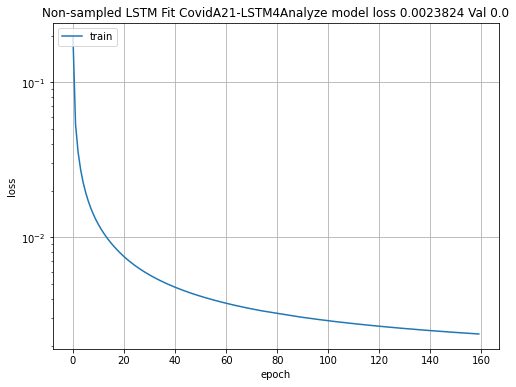

06/01/2021, 19:55:54 UTC CovidA21-LSTM4Analyze DLPrediction April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties


Times 0.0026 110.6608 TF 54.8812
06/01/2021, 19:58:40 UTC DLPrediction Averages CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties
Non-sampled LSTM Fit CovidA21-LSTM4Analyze Weighted sum over predicted values 0.001355 No Encoding Preds 0.001323 from
loss function 0.001355 TF version 0.001355 TFspec version 0.001355
Count ignoring NaN 1180500.0001 Counting NaN 1188000.0001 70
 Unwgt Count no NaN  7419000  Unwgt Count with NaN  7524000  Number Sequences  198000
 Errors by Prediction Components -- class weights not included except in final Loss components  Name Count
without NaN, Loss wgt * sum errors**2/count, sqrt(sum errors**2/sum target**2), sum(abs(error)/sum(abs(value),
abs(sum(abs(value)-abs(pred)))/sum(abs(pred)
0 Next Cases All Counts 198000.0 24.9316 20.1308 4.0802 Loss Coeffs  All Time Full 0.000252 Start
Full 0.000164 End Full 0.000339 All Time FULL 0.000252 Start FULL 0.000164 End FULL 0.000339
1 Next Deaths Al

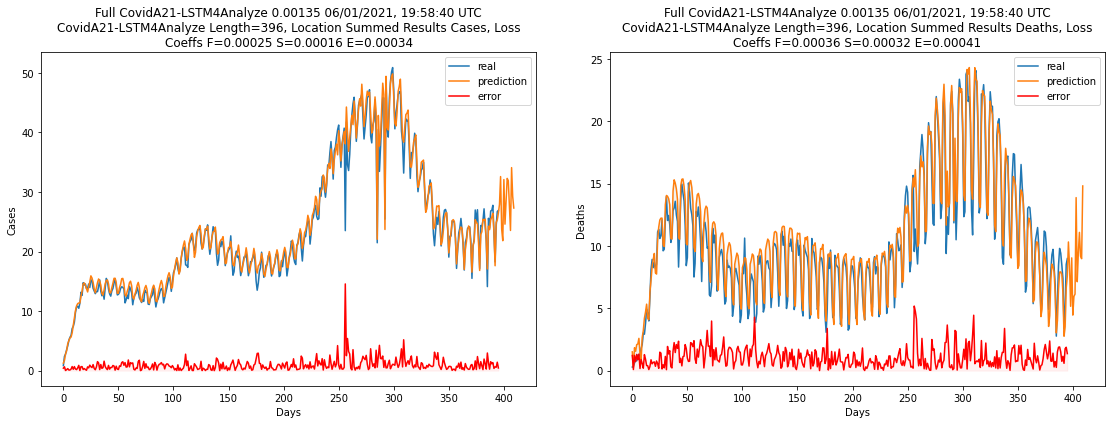

06/01/2021, 19:58:43 UTC Calculate NNSE  CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of
Properties; NO Validation; LSTM; Futures; 500 counties
NNSE  0 Next Cases Averaged 0.813 Training 0.813 Validation 0.0 Summed 0.982 Training 0.982
Validation 0.0
NNSE  1 Next Deaths Averaged 0.604 Training 0.604 Validation 0.0 Summed 0.931 Training 0.931
Validation 0.0
DLPrediction2F 06/01/2021, 19:58:49 UTC CovidA21-LSTM4AnalyzeApril 14 Covid 2021 Dataset; Old set of
Properties; NO Validation; LSTM; Futures; 500 counties
 Predict with 500 sequences per sample and batch size 396
Sensitivity using Property ScaleFactor 0.99
Basic Predictions


 Full Loss  Mean 0.00135 Std Deviation 0.0 Basic Predictions
Property 0 Cases Normed Mean 0.0451


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 0 Cases Normed Mean 0.0451
1728.6404 GS 946059.56 Property 0 Cases Normed Mean 0.0451
Property 1 Deaths Normed Mean 0.0199


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 1 Deaths Normed Mean 0.0199
396.58347 GS 946059.56 Property 1 Deaths Normed Mean 0.0199
Property 2 Age Distribution Normed Mean 0.3446


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 2 Age Distribution Normed Mean 0.3446
168.8794 GS 946059.56 Property 2 Age Distribution Normed Mean 0.3446
Property 3 Air Pollution Normed Mean 0.4129


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 3 Air Pollution Normed Mean 0.4129
153.14832 GS 946059.56 Property 3 Air Pollution Normed Mean 0.4129
Property 4 Co-morbidities Normed Mean 0.4634


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 4 Co-morbidities Normed Mean 0.4634
136.65608 GS 946059.56 Property 4 Co-morbidities Normed Mean 0.4634
Property 5 Demographics Normed Mean 0.3877


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 5 Demographics Normed Mean 0.3877
121.67387 GS 946059.56 Property 5 Demographics Normed Mean 0.3877
Property 6 Disease Spread Normed Mean 0.2338


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 6 Disease Spread Normed Mean 0.2338
100.64257 GS 946059.56 Property 6 Disease Spread Normed Mean 0.2338
Property 7 Health Disparities Normed Mean 0.3078


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 7 Health Disparities Normed Mean 0.3078
100.38229 GS 946059.56 Property 7 Health Disparities Normed Mean 0.3078
Property 8 Hospital Beds Normed Mean 0.4559


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 8 Hospital Beds Normed Mean 0.4559
121.12979 GS 946059.56 Property 8 Hospital Beds Normed Mean 0.4559
Property 9 Mobility Normed Mean 0.3668


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 9 Mobility Normed Mean 0.3668
183.0536 GS 946059.56 Property 9 Mobility Normed Mean 0.3668
Property 10 Residential Density Normed Mean 0.5738


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 10 Residential Density Normed Mean 0.5738
62.61908 GS 946059.56 Property 10 Residential Density Normed Mean 0.5738
Property 11 Social Distancing Normed Mean 0.9035


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 11 Social Distancing Normed Mean 0.9035
227.54411 GS 946059.56 Property 11 Social Distancing Normed Mean 0.9035
Property 12 Testing Normed Mean 0.5694


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 12 Testing Normed Mean 0.5694
158.5193 GS 946059.56 Property 12 Testing Normed Mean 0.5694
Property 13 Transmissible Cases Normed Mean 0.5273


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 13 Transmissible Cases Normed Mean 0.5273
671.32715 GS 946059.56 Property 13 Transmissible Cases Normed Mean 0.5273
Property 14 voting Normed Mean 0.4622


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 14 voting Normed Mean 0.4622
136.86023 GS 946059.56 Property 14 voting Normed Mean 0.4622
Property 15 LinearSpace


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 15 LinearSpace Normed Mean 0.5
1445.5673 GS 946059.56 Property 15 LinearSpace Normed Mean 0.5
Property 16 Constant


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 16 Constant Normed Mean 0.5
996.33856 GS 946059.56 Property 16 Constant Normed Mean 0.5
Property 17 LinearTime


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 17 LinearTime Normed Mean 0.5
768.9468 GS 946059.56 Property 17 LinearTime Normed Mean 0.5
Property 18 P2-Time


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 18 P2-Time Normed Mean 0.0
480.75183 GS 946059.56 Property 18 P2-Time Normed Mean 0.0
Property 19 P3-Time


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 19 P3-Time Normed Mean 0.0
844.4591 GS 946059.56 Property 19 P3-Time Normed Mean 0.0
Property 20 P4-Time


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 20 P4-Time Normed Mean 0.0
1050.5995 GS 946059.56 Property 20 P4-Time Normed Mean 0.0
Property 21 CosWeekly


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 21 CosWeekly Normed Mean 0.0
132.9848 GS 946059.56 Property 21 CosWeekly Normed Mean 0.0
Property 22 SinWeekly


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 22 SinWeekly Normed Mean 0.0
140.387 GS 946059.56 Property 22 SinWeekly Normed Mean 0.0

Summarize Changes Total 946059.56 Property ScaleFactor 0.99
0 Change 1728.64 Normed Change 0.18272 /std 4.2066 Std/Mean 0.9632 Cases Normed Mean 0.0451 Normed Std 0.0434
1 Change 396.58 Normed Change 0.04192 /std 1.37477 Std/Mean 1.53457 Deaths Normed Mean 0.0199 Normed Std 0.0305
2 Change 168.88 Normed Change 0.01785 /std 0.14794 Std/Mean 0.35016 Age Distribution Normed Mean 0.3446 Normed Std 0.1207
3 Change 153.15 Normed Change 0.01619 /std 0.14115 Std/Mean 0.27779 Air Pollution Normed Mean 0.4129 Normed Std 0.1147
4 Change 136.66 Normed Change 0.01444 /std 0.08051 Std/Mean 0.38712 Co-morbidities Normed Mean 0.4634 Normed Std 0.1794
5 Change 121.67 Normed Change 0.01286 /std 0.09276 Std/Mean 0.35761 Demographics Normed Mean 0.3877 Normed Std 0.1386
6 Change 100.64 Normed Change 0.01064 /std 0.04369 Std/Mean 1.04147 Disease Spread Normed Mean 0.2

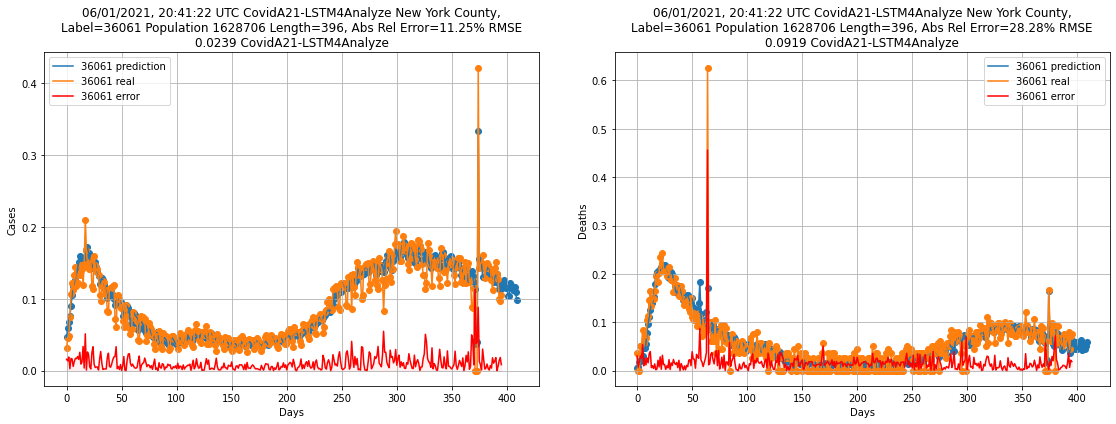

debugfipsoutput for 53033CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties

53033 # 479 King County Washington Pop 2252782
06/01/2021, 20:41:23 UTC plot by location 479 53033 King County CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties


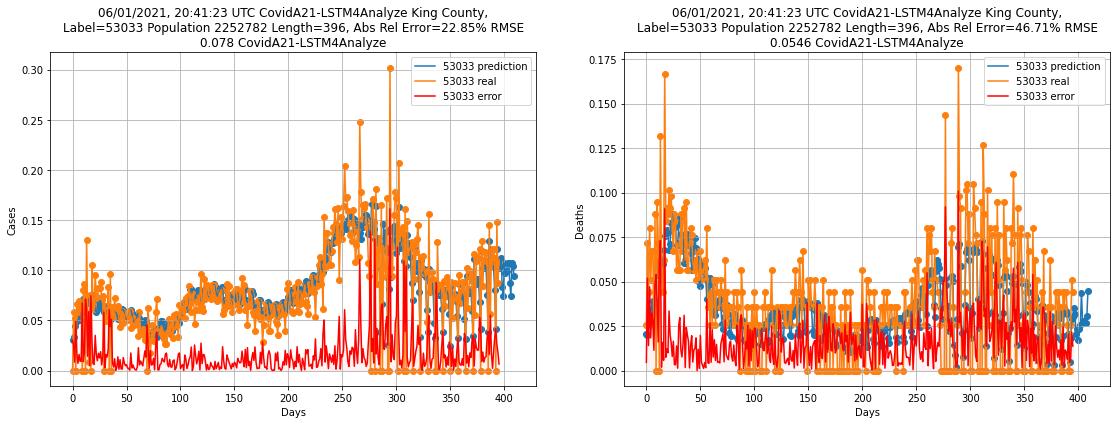

LSTM run completed Restarted CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [51]:

current_time = timenow()
runtype = ''
if Restorefromcheckpoint:
  runtype = 'Restarted '
if standaloneLSTMrun or ClassLSTMrun:
  print(wraptotext(startbold + startred +  current_time + ' '  + runtype + RunName + ' ' + RunComment + resetfonts))
  PrintLSTMandBasicStuff(0)
if standaloneLSTMrun:
  StandaloneLSTM()
if ClassLSTMrun:
  if SymbolicWindows:
    CustomTraining = True
  if CustomTraining:
    RunLSTMCustomVersion()
  else:
    RunLSTMClassVersion()
if standaloneLSTMrun or ClassLSTMrun:
  print(startbold + startpurple +  'LSTM run completed ' + runtype + RunName + ' ' + RunComment + resetfonts)
  sys.exit(0)
print(startbold + startpurple +  current_time + ' UTC Start Hybrid Transformer run ' + RunName + ' ' + RunComment + resetfonts)